In [1]:
!pip install python-docx

!pip install PyPDF2

!pip install --upgrade pip
#!pip install tensorflow==2.15.0 -q
!pip install --upgrade transformers==4.52.1 accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 84.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 50.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 89.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 110.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 98.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 

# PREPROCESSING OF THE TWO DATASETS:
- use all-MiniLM-L6-v2 to generate semantic embeddings (not used in my later cells)
-  full text extraction from PDF using PyPDF2

In [2]:
# Fix the IPython widgets issue first
!pip install --upgrade ipywidgets
!pip install --upgrade notebook

import pandas as pd
import numpy as np
# Import regular tqdm instead of notebook version to avoid widget issues
from tqdm import tqdm
import pickle
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    !pip install sentence-transformers
    from sentence_transformers import SentenceTransformer

# Function to generate embeddings 
def generate_embeddings(texts, ids, model_name='all-MiniLM-L6-v2'):
    print(f"Generating embeddings using {model_name}...")
    model = SentenceTransformer(model_name)
    embeddings = []
    
    # Use regular tqdm instead of tqdm.notebook to avoid widget issues
    for i, text in enumerate(tqdm(texts, desc="Generating embeddings")):
        # Ensure text is a string and not empty
        if not isinstance(text, str):
            print(f"Warning: Item {i} is not a string. Converting to string.")
            text = str(text) if text is not None else ""
        
        # Clean and prepare text for better embedding quality
        if text and len(text.strip()) > 0:
            try:
                embedding = model.encode(text)
                embeddings.append(embedding)
            except Exception as e:
                print(f"Error encoding text at index {i}: {e}")
                # Use zero vector if encoding fails
                embeddings.append(np.zeros(model.get_sentence_embedding_dimension()))
        else:
            # Use zero vector for empty text
            print(f"Warning: Empty text at index {i}. Using zero vector.")
            embeddings.append(np.zeros(model.get_sentence_embedding_dimension()))
    
    # Create a dictionary mapping ID to embedding
    embedding_dict = {ids[i]: embeddings[i] for i in range(len(ids))}
    
    return embeddings, embedding_dict

# Main function to process the translated dataset
def process_english_text_dataset(csv_path):
    print(f"Loading data from {csv_path}...")
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Ensure the required columns exist
    if 'id' not in df.columns or 'full_text_english' not in df.columns:
        missing_cols = []
        if 'id' not in df.columns: missing_cols.append('id')
        if 'full_text_english' not in df.columns: missing_cols.append('full_text_english')
        raise ValueError(f"Missing required columns: {', '.join(missing_cols)}")
    
    # Clean the data
    # Fill any missing values in full_text_english with empty strings
    df['full_text_english'] = df['full_text_english'].fillna("")
    
    # Convert any non-string values to strings
    for i, val in enumerate(df['full_text_english']):
        if not isinstance(val, str):
            df.loc[i, 'full_text_english'] = str(val) if val is not None else ""
    
    # Prepare data for embedding
    texts = df["full_text_english"].tolist()
    ids = df["id"].tolist()
    
    # Generate embeddings
    embeddings, embedding_dict = generate_embeddings(texts, ids)
    
    # Save embeddings to files
    with open("cv_english_embeddings.pkl", "wb") as f:
        pickle.dump(embeddings, f)
        
    # Save embeddings with IDs to file
    with open("cv_english_embeddings_with_ids.pkl", "wb") as f:
        pickle.dump(embedding_dict, f)
    
    print(f"Generated and saved embeddings for {len(embeddings)} documents")
    print(f"Saved ID-to-embedding mapping for later training use")
    
    # Display embedding information
    if embeddings and len(embeddings) > 0:
        print(f"\nEmbedding shape: {embeddings[0].shape}")
        print(f"Embedding sample (first 5 values): {embeddings[0][:5]}")
        print(f"Number of IDs in embedding dictionary: {len(embedding_dict)}")
        if embedding_dict:
            sample_id = list(embedding_dict.keys())[0]
            print(f"Sample ID in embedding dictionary: {sample_id}")
    
    return df, embeddings, embedding_dict

# Make sure we have the necessary packages
!pip install sentence-transformers

# Path to the CSV file
csv_path = "/kaggle/input/processed-prof-dataset-translated/processed_prof_dataset_ (5)_translated (3).csv"

# Process the dataset
df, embeddings, embedding_dict = process_english_text_dataset(csv_path)

# Show overall statistics
print("\nOverall Dataset Statistics:")
print(f"Total documents processed: {len(df)}")
print(f"Average text length: {df['full_text_english'].str.len().mean():.0f} characters")
print(f"Minimum text length: {df['full_text_english'].str.len().min()} characters")
print(f"Maximum text length: {df['full_text_english'].str.len().max()} characters")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 4.0.13
    Uninstalling widgetsnbextension-4.0.13:
      Successfully uninstalled widgetsnbextension-4.0.13
  Attempting uninstall: jupyterlab_widgets━━━━━━ 0/3 [widgetsnbextension]
    Found existing installation: jupyterlab_widgets 3.0.13 [widgetsnbextension]
    Uninstalling jupyterlab_widgets-3.0.13:━ 0/3 [widgetsnbextension]
      Successfully uninstalled jupyterlab_widgets-3.0.133 [widgetsnbextension]
  Attempting uninstall: ipywidgets━━━━━━━━━━ 0/3 [widgetsnbextension]
    Found existing installation: ipywidgets 8.1.50/3 [widgetsnbextension]
    Uninstalling ipywidgets-8.1.5:━━━━━━━━━━ 0/3 [widgetsnbextension]
      Successfully uninstalled ipywidgets-8.1.5m━━━━━━━━━━━━━ 2/3 [ipywidgets]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ipywidgets]m [ipywidgets]
ERROR: pip's dependency resolver does not current

2025-06-27 21:52:56.214929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751061176.449602      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751061176.521154      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading data from /kaggle/input/processed-prof-dataset-translated/processed_prof_dataset_ (5)_translated (3).csv...
Dataset shape: (949, 11)
Columns: ['id', 'language', 'full_text', 'job_category', 'job_cluster', 'Age', 'Gender', 'Sexual_orientation', 'Ethnicity', 'Religion', 'full_text_english']
Generating embeddings using all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings:   0%|          | 0/949 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 1/949 [00:00<08:11,  1.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   1%|          | 5/949 [00:00<01:33, 10.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   1%|          | 10/949 [00:00<00:50, 18.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   2%|▏         | 15/949 [00:00<00:36, 25.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   2%|▏         | 19/949 [00:00<00:31, 29.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 24/949 [00:01<00:28, 32.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 29/949 [00:01<00:25, 35.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   4%|▎         | 34/949 [00:01<00:23, 38.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   4%|▍         | 39/949 [00:01<00:22, 41.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   5%|▍         | 45/949 [00:01<00:19, 46.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   5%|▌         | 51/949 [00:01<00:18, 49.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   6%|▌         | 57/949 [00:01<00:18, 49.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   7%|▋         | 63/949 [00:01<00:18, 47.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   7%|▋         | 69/949 [00:01<00:18, 47.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 74/949 [00:02<00:18, 46.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 80/949 [00:02<00:17, 49.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   9%|▉         | 86/949 [00:02<00:17, 48.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  10%|▉         | 91/949 [00:02<00:18, 47.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  10%|█         | 96/949 [00:02<00:18, 46.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  11%|█         | 101/949 [00:02<00:18, 46.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  11%|█▏        | 107/949 [00:02<00:17, 48.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  12%|█▏        | 112/949 [00:02<00:18, 46.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  12%|█▏        | 117/949 [00:03<00:18, 45.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 123/949 [00:03<00:17, 47.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 128/949 [00:03<00:17, 46.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  14%|█▍        | 133/949 [00:03<00:17, 46.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  15%|█▍        | 138/949 [00:03<00:17, 47.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  15%|█▌        | 144/949 [00:03<00:16, 50.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  16%|█▌        | 150/949 [00:03<00:16, 48.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  16%|█▋        | 155/949 [00:03<00:16, 47.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  17%|█▋        | 163/949 [00:03<00:14, 56.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  18%|█▊        | 169/949 [00:04<00:13, 57.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  18%|█▊        | 175/949 [00:04<00:14, 53.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  19%|█▉        | 181/949 [00:04<00:14, 54.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  20%|█▉        | 187/949 [00:04<00:14, 51.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  20%|██        | 193/949 [00:04<00:15, 50.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  21%|██        | 199/949 [00:04<00:15, 49.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  22%|██▏       | 205/949 [00:04<00:15, 48.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  22%|██▏       | 210/949 [00:04<00:15, 47.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 216/949 [00:04<00:15, 48.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 221/949 [00:05<00:15, 47.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  24%|██▍       | 226/949 [00:05<00:16, 44.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  24%|██▍       | 231/949 [00:05<00:15, 45.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▍       | 236/949 [00:05<00:15, 45.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▌       | 241/949 [00:05<00:15, 46.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  26%|██▌       | 246/949 [00:05<00:15, 46.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  26%|██▋       | 251/949 [00:05<00:14, 47.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  27%|██▋       | 257/949 [00:05<00:13, 49.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  28%|██▊       | 263/949 [00:05<00:13, 52.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  28%|██▊       | 269/949 [00:06<00:12, 53.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  29%|██▉       | 275/949 [00:06<00:12, 54.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  30%|██▉       | 281/949 [00:06<00:12, 51.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  30%|███       | 287/949 [00:06<00:13, 50.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  31%|███       | 293/949 [00:06<00:13, 49.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 299/949 [00:06<00:12, 50.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 305/949 [00:06<00:12, 49.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  33%|███▎      | 311/949 [00:06<00:12, 50.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  33%|███▎      | 317/949 [00:07<00:12, 51.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  34%|███▍      | 323/949 [00:07<00:12, 50.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  35%|███▍      | 329/949 [00:07<00:13, 47.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  35%|███▌      | 336/949 [00:07<00:11, 51.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▌      | 342/949 [00:07<00:12, 49.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  37%|███▋      | 348/949 [00:07<00:12, 48.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  37%|███▋      | 354/949 [00:07<00:12, 49.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  38%|███▊      | 359/949 [00:07<00:12, 48.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  39%|███▊      | 367/949 [00:07<00:10, 55.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  39%|███▉      | 373/949 [00:08<00:11, 52.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  40%|███▉      | 379/949 [00:08<00:11, 50.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  41%|████      | 385/949 [00:08<00:10, 52.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  41%|████      | 391/949 [00:08<00:10, 54.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  42%|████▏     | 397/949 [00:08<00:09, 55.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  42%|████▏     | 403/949 [00:08<00:10, 52.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  43%|████▎     | 409/949 [00:08<00:10, 51.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  44%|████▎     | 415/949 [00:08<00:10, 50.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  44%|████▍     | 421/949 [00:09<00:10, 48.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  45%|████▍     | 426/949 [00:09<00:11, 47.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  45%|████▌     | 431/949 [00:09<00:11, 45.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  46%|████▌     | 436/949 [00:09<00:11, 46.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  46%|████▋     | 441/949 [00:09<00:10, 47.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  47%|████▋     | 446/949 [00:09<00:11, 42.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  48%|████▊     | 451/949 [00:09<00:11, 42.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  48%|████▊     | 457/949 [00:09<00:10, 45.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  49%|████▊     | 462/949 [00:09<00:10, 45.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  49%|████▉     | 467/949 [00:10<00:11, 43.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  50%|████▉     | 472/949 [00:10<00:10, 44.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  50%|█████     | 478/949 [00:10<00:10, 46.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  51%|█████     | 483/949 [00:10<00:10, 44.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  52%|█████▏    | 489/949 [00:10<00:09, 47.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  52%|█████▏    | 495/949 [00:10<00:09, 50.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  53%|█████▎    | 501/949 [00:11<00:20, 22.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  53%|█████▎    | 506/949 [00:11<00:16, 26.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  54%|█████▍    | 512/949 [00:11<00:13, 31.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  55%|█████▍    | 518/949 [00:11<00:11, 37.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  55%|█████▌    | 524/949 [00:11<00:10, 39.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▌    | 529/949 [00:11<00:10, 41.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▋    | 534/949 [00:11<00:09, 42.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  57%|█████▋    | 539/949 [00:12<00:09, 44.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  57%|█████▋    | 544/949 [00:12<00:08, 45.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  58%|█████▊    | 550/949 [00:12<00:08, 49.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  59%|█████▊    | 556/949 [00:12<00:07, 49.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  59%|█████▉    | 563/949 [00:12<00:07, 53.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  60%|█████▉    | 569/949 [00:12<00:06, 54.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  61%|██████    | 575/949 [00:12<00:06, 53.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  61%|██████    | 581/949 [00:12<00:07, 52.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 587/949 [00:12<00:07, 49.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 593/949 [00:13<00:07, 49.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  63%|██████▎   | 598/949 [00:13<00:07, 48.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  64%|██████▍   | 605/949 [00:13<00:06, 51.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  64%|██████▍   | 611/949 [00:13<00:07, 48.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  65%|██████▍   | 616/949 [00:13<00:07, 46.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  66%|██████▌   | 622/949 [00:13<00:06, 48.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  66%|██████▌   | 628/949 [00:13<00:06, 51.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  67%|██████▋   | 634/949 [00:13<00:06, 52.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  67%|██████▋   | 640/949 [00:13<00:05, 53.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  68%|██████▊   | 646/949 [00:14<00:05, 51.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▊   | 652/949 [00:14<00:05, 51.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▉   | 658/949 [00:14<00:05, 50.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  70%|██████▉   | 664/949 [00:14<00:05, 48.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  70%|███████   | 669/949 [00:14<00:05, 48.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  71%|███████   | 674/949 [00:14<00:05, 48.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  72%|███████▏  | 680/949 [00:14<00:05, 51.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  72%|███████▏  | 686/949 [00:14<00:05, 45.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  73%|███████▎  | 691/949 [00:15<00:05, 46.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▎  | 698/949 [00:15<00:05, 49.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▍  | 704/949 [00:15<00:05, 46.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  75%|███████▍  | 709/949 [00:15<00:05, 46.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  75%|███████▌  | 714/949 [00:15<00:05, 45.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  76%|███████▌  | 719/949 [00:15<00:05, 44.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  76%|███████▋  | 724/949 [00:15<00:05, 43.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 729/949 [00:15<00:05, 42.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 735/949 [00:16<00:04, 45.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  78%|███████▊  | 740/949 [00:16<00:04, 44.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▊  | 745/949 [00:16<00:04, 44.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▉  | 750/949 [00:16<00:04, 44.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  80%|███████▉  | 755/949 [00:16<00:04, 45.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  80%|████████  | 760/949 [00:16<00:04, 45.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  81%|████████  | 766/949 [00:16<00:03, 46.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  81%|████████  | 771/949 [00:16<00:03, 47.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  82%|████████▏ | 776/949 [00:16<00:03, 47.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  83%|████████▎ | 783/949 [00:17<00:03, 51.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  83%|████████▎ | 789/949 [00:17<00:03, 52.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  84%|████████▍ | 795/949 [00:17<00:03, 50.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  84%|████████▍ | 801/949 [00:17<00:02, 52.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  85%|████████▌ | 807/949 [00:17<00:02, 49.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▌ | 813/949 [00:17<00:02, 49.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▋ | 819/949 [00:17<00:02, 48.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  87%|████████▋ | 825/949 [00:17<00:02, 49.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  88%|████████▊ | 831/949 [00:17<00:02, 50.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  88%|████████▊ | 837/949 [00:18<00:02, 49.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  89%|████████▊ | 842/949 [00:18<00:02, 48.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  89%|████████▉ | 848/949 [00:18<00:01, 51.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  90%|████████▉ | 854/949 [00:18<00:01, 49.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  91%|█████████ | 860/949 [00:18<00:01, 50.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  91%|█████████▏| 866/949 [00:18<00:01, 50.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  92%|█████████▏| 872/949 [00:18<00:01, 50.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  93%|█████████▎| 878/949 [00:18<00:01, 50.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  93%|█████████▎| 884/949 [00:19<00:01, 47.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  94%|█████████▎| 889/949 [00:19<00:01, 45.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  94%|█████████▍| 895/949 [00:19<00:01, 47.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  95%|█████████▍| 901/949 [00:19<00:00, 48.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  96%|█████████▌| 907/949 [00:19<00:00, 48.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  96%|█████████▌| 913/949 [00:19<00:00, 50.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  97%|█████████▋| 919/949 [00:19<00:00, 46.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  97%|█████████▋| 925/949 [00:19<00:00, 49.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  98%|█████████▊| 931/949 [00:20<00:00, 49.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  99%|█████████▊| 936/949 [00:20<00:00, 48.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  99%|█████████▉| 942/949 [00:20<00:00, 49.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 949/949 [00:20<00:00, 46.53it/s]

Generated and saved embeddings for 949 documents
Saved ID-to-embedding mapping for later training use

Embedding shape: (384,)
Embedding sample (first 5 values): [-0.05037745  0.02807144 -0.03006093 -0.00657992 -0.08486915]
Number of IDs in embedding dictionary: 948
Sample ID in embedding dictionary: 1087

Overall Dataset Statistics:
Total documents processed: 949
Average text length: 3234 characters
Minimum text length: 0 characters
Maximum text length: 61566 characters


### REPEATING FULL TEXT EXTRACTION AND EMBEDDING + 24 LABELS FOR KEGGLE DATASET

In [3]:


import os
import pandas as pd
import re
import numpy as np
# Import regular tqdm instead of notebook version to avoid widget issues
from tqdm import tqdm
import pickle
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    !pip install sentence-transformers
    from sentence_transformers import SentenceTransformer

# Install necessary packages if not already installed
try:
    import fitz  # PyMuPDF
except ImportError:
    !pip install pymupdf
    import fitz

# Function to extract ID from CV filename
def extract_id(filename):
    # Extract just the numeric ID from the filename
    match = re.search(r'(\d+)', filename)
    if match:
        return match.group(1)
    return None

# Function to extract text from PDF using PyMuPDF (fitz)
def extract_text_from_pdf(pdf_path):
    text = ""
    try:
        # Open the PDF with PyMuPDF
        doc = fitz.open(pdf_path)
        
        # Extract text from each page
        for page_num in range(len(doc)):
            page = doc[page_num]
            
            # Get text with more preservation of layout
            text += page.get_text("text") + "\n\n"
            
        # Close the document
        doc.close()
        
        return text  # Will be a string, even if empty
    except Exception as e:
        print(f"Error extracting text from {pdf_path}: {e}")
        return ""  # Return empty string instead of None or NaN

# Function to find all CV files in the dataset with job categories
def find_cv_files(base_dir):
    cv_files = []
    
    print(f"Scanning directory: {base_dir}")
    
    # List all job category directories
    try:
        job_categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
        print(f"Found {len(job_categories)} job categories: {', '.join(job_categories)}")
        
        # Walk through each job category directory
        for job_category in job_categories:
            job_dir = os.path.join(base_dir, job_category)
            
            for root, dirs, files in os.walk(job_dir):
                for file in files:
                    if file.lower().endswith('.pdf'):
                        id = extract_id(file)
                        if id:
                            cv_files.append({
                                'id': id,
                                'job_category': job_category,
                                'path': os.path.join(root, file)
                            })
    except Exception as e:
        print(f"Error scanning directories: {e}")
    
    print(f"Found {len(cv_files)} CV files across all job categories")
    
    return cv_files

# Function to generate embeddings
def generate_embeddings(texts, ids, model_name='all-MiniLM-L6-v2'):
    print(f"Generating embeddings using {model_name}...")
    model = SentenceTransformer(model_name)
    embeddings = []
    
    # Use regular tqdm instead of tqdm.notebook to avoid widget issues
    for i, text in enumerate(tqdm(texts, desc="Generating embeddings")):
        # Ensure text is a string and not empty
        if not isinstance(text, str):
            print(f"Warning: Item {i} is not a string. Converting to string.")
            text = str(text) if text is not None else ""
        
        # Clean and prepare text for better embedding quality
        if text and len(text.strip()) > 0:
            try:
                embedding = model.encode(text)
                embeddings.append(embedding)
            except Exception as e:
                print(f"Error encoding text at index {i}: {e}")
                # Use zero vector if encoding fails
                embeddings.append(np.zeros(model.get_sentence_embedding_dimension()))
        else:
            # Use zero vector for empty text
            print(f"Warning: Empty text at index {i}. Using zero vector.")
            embeddings.append(np.zeros(model.get_sentence_embedding_dimension()))
    
    # Create a dictionary mapping ID to embedding
    embedding_dict = {ids[i]: embeddings[i] for i in range(len(ids))}
    
    return embeddings, embedding_dict

# Main function to process the dataset
def process_cv_dataset(base_dir, generate_embedding=True):
    # Find all CV files with their job categories
    cv_files = find_cv_files(base_dir)
    
    # Create a list to store processed data
    processed_data = []
    
    # Use regular tqdm to avoid widget issues
    # Process CV files
    for cv_file in tqdm(cv_files, desc="Processing CV files"):
        cv_id = cv_file['id']
        job_category = cv_file['job_category']
        cv_path = cv_file['path']
        
        # Extract text from PDF
        cv_text = extract_text_from_pdf(cv_path)
        
        # Create a record
        record = {
            "id": cv_id,
            "job_category": job_category,
            "full_text": cv_text if cv_text else ""  # Ensure we have a string, not None
        }
        
        processed_data.append(record)
    
    print(f"Successfully processed {len(processed_data)} CV records")
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(processed_data)
    
    # Clean the DataFrame - replace any NaN values with empty strings
    if 'full_text' in df.columns:
        df['full_text'] = df['full_text'].fillna("")
        # Check for non-string values and convert them
        for i, val in enumerate(df['full_text']):
            if not isinstance(val, str):
                df.loc[i, 'full_text'] = str(val) if val is not None else ""
    
    # Generate embeddings if requested
    embeddings = None
    embedding_dict = None
    if generate_embedding and len(df) > 0:
        texts = df["full_text"].tolist()
        ids = df["id"].tolist()
        
        # Final check for non-string values before embedding
        for i, text in enumerate(texts):
            if not isinstance(text, str):
                texts[i] = str(text) if text is not None else ""
                
        embeddings, embedding_dict = generate_embeddings(texts, ids)
        
        # Save embeddings to files with consistent naming
        with open("kaggle_cv_embeddings.pkl", "wb") as f:
            pickle.dump(embeddings, f)
            
        # Save embeddings with IDs to file
        with open("kaggle_cv_embeddings_with_ids.pkl", "wb") as f:
            pickle.dump(embedding_dict, f)
        
        print(f"Generated and saved embeddings for {len(embeddings)} CV documents")
        print(f"Saved ID-to-embedding mapping for later training use")
    
    # Analyze job category distribution
    print("\nJob category distribution:")
    job_dist = df["job_category"].value_counts()
    for job, count in job_dist.items():
        print(f"  {job}: {count}")
    
    # Save processed data to CSV with a clear, consistent name
    df.to_csv("kaggle_processed_cv_data.csv", index=False)
    print("Processed data saved to kaggle_processed_cv_data.csv")
    
    return df, embeddings, embedding_dict

# Main execution
# First, make sure we install the necessary packages
!pip install pymupdf sentence-transformers

# Set the base directory to point to the dataset with job categories
base_dir = "/kaggle/input/cvs-keggle/keggleee/data/data"

# Process the dataset
df, embeddings, embedding_dict = process_cv_dataset(base_dir)

# Display sample information
if len(df) > 0:
    # First sample
    print("\n" + "="*80)
    print("SAMPLE CV #1")
    print("="*80)
    sample1 = df.iloc[0]
    print(f"ID: {sample1['id']}")
    print(f"Job Category: {sample1['job_category']}")
    print(f"Text length: {len(sample1['full_text'])} characters")
    print("\nSAMPLE TEXT (first 500 chars):")
    print("-"*80)
    print(sample1["full_text"][:500])
    print("-"*80)
    
    # Second sample - pick a different job category if possible
    if len(df) > 1:
        print("\n" + "="*80)
        print("SAMPLE CV #2")
        print("="*80)
        # Try to find a sample from a different job category
        job_cat1 = sample1['job_category']
        diff_job_sample = df[df['job_category'] != job_cat1]
        if len(diff_job_sample) > 0:
            sample2 = diff_job_sample.iloc[0]
        else:
            # If all samples are from the same job category, pick a different one
            sample2 = df.iloc[min(5, len(df)-1)]
            
        print(f"ID: {sample2['id']}")
        print(f"Job Category: {sample2['job_category']}")
        print(f"Text length: {len(sample2['full_text'])} characters")
        print("\nSAMPLE TEXT (first 500 chars):")
        print("-"*80)
        print(sample2["full_text"][:500])
        print("-"*80)
    
    # Display embedding information
    if embeddings is not None and len(embeddings) > 0:
        print(f"\nEmbedding shape: {embeddings[0].shape}")
        print(f"Embedding sample (first 5 values): {embeddings[0][:5]}")
        print(f"Number of IDs in embedding dictionary: {len(embedding_dict)}")
        if embedding_dict:
            sample_id = list(embedding_dict.keys())[0]
            print(f"Sample ID in embedding dictionary: {sample_id}")
        
# Save ID to job category mapping for future reference
id_job_mapping = df[['id', 'job_category']].copy()
id_job_mapping.to_csv("kaggle_id_job_mapping.csv", index=False)
print("\nID to job category mapping saved to kaggle_id_job_mapping.csv")

# Show overall statistics
print("\nOverall Dataset Statistics:")
print(f"Total CVs processed: {len(df)}")
print(f"Number of job categories: {df['job_category'].nunique()}")
print(f"Average text length: {df['full_text'].str.len().mean():.0f} characters")
print(f"Minimum text length: {df['full_text'].str.len().min()} characters")
print(f"Maximum text length: {df['full_text'].str.len().max()} characters")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 71.2 MB/s eta 0:00:00ta 0:00:01


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Scanning directory: /kaggle/input/cvs-keggle/keggleee/data/data
Found 24 job categories: DESIGNER, BPO, FINANCE, CONSTRUCTION, SALES, AUTOMOBILE, CONSULTANT, CHEF, APPAREL, AGRICULTURE, TEACHER, HR, DIGITAL-MEDIA, ACCOUNTANT, HEALTHCARE, INFORMATION-TECHNOLOGY, ADVOCATE, FITNESS, AVIATION, PUBLIC-RELATIONS, ENGINEERING, BUSINESS-DEVELOPMENT, BANKING, ARTS
Found 2484 CV files across all job categories


Processing CV files: 100%|██████████| 2484/2484 [00:41<00:00, 60.06it/s]


Successfully processed 2484 CV records
Generating embeddings using all-MiniLM-L6-v2...


Generating embeddings:   0%|          | 0/2484 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 5/2484 [00:00<00:58, 42.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 10/2484 [00:00<00:59, 41.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   1%|          | 15/2484 [00:00<00:57, 42.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   1%|          | 20/2484 [00:00<00:56, 43.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   1%|          | 25/2484 [00:00<00:55, 44.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   1%|          | 30/2484 [00:00<00:54, 45.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   1%|▏         | 35/2484 [00:00<00:54, 44.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   2%|▏         | 40/2484 [00:00<00:54, 44.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   2%|▏         | 45/2484 [00:01<00:54, 44.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   2%|▏         | 50/2484 [00:01<00:54, 44.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   2%|▏         | 55/2484 [00:01<00:55, 44.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   2%|▏         | 60/2484 [00:01<00:54, 44.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 65/2484 [00:01<00:55, 43.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 70/2484 [00:01<00:55, 43.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 75/2484 [00:01<00:55, 43.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 80/2484 [00:01<00:55, 43.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 85/2484 [00:01<00:56, 42.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   4%|▎         | 90/2484 [00:02<00:56, 42.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   4%|▍         | 95/2484 [00:02<00:56, 42.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   4%|▍         | 100/2484 [00:02<00:55, 42.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   4%|▍         | 105/2484 [00:02<00:53, 44.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   4%|▍         | 110/2484 [00:02<00:53, 44.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   5%|▍         | 115/2484 [00:02<00:53, 44.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   5%|▍         | 120/2484 [00:02<00:54, 43.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   5%|▌         | 125/2484 [00:02<00:54, 43.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   5%|▌         | 130/2484 [00:02<00:54, 43.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   5%|▌         | 135/2484 [00:03<00:54, 43.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   6%|▌         | 140/2484 [00:03<00:54, 43.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   6%|▌         | 145/2484 [00:03<00:53, 43.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   6%|▌         | 150/2484 [00:03<00:53, 43.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   6%|▌         | 155/2484 [00:03<00:54, 42.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   6%|▋         | 160/2484 [00:03<00:55, 41.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   7%|▋         | 165/2484 [00:03<00:53, 43.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   7%|▋         | 170/2484 [00:03<00:54, 42.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   7%|▋         | 175/2484 [00:04<00:53, 42.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   7%|▋         | 180/2484 [00:04<00:53, 43.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   7%|▋         | 185/2484 [00:04<00:53, 43.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 190/2484 [00:04<00:53, 42.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 195/2484 [00:04<00:54, 42.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 200/2484 [00:04<00:54, 42.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 205/2484 [00:04<00:55, 41.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 210/2484 [00:04<00:55, 40.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   9%|▊         | 215/2484 [00:05<00:56, 40.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   9%|▉         | 220/2484 [00:05<00:55, 40.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   9%|▉         | 225/2484 [00:05<00:55, 40.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   9%|▉         | 230/2484 [00:05<00:56, 40.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   9%|▉         | 235/2484 [00:05<00:55, 40.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  10%|▉         | 240/2484 [00:05<00:53, 41.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  10%|▉         | 245/2484 [00:05<00:53, 41.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  10%|█         | 250/2484 [00:05<00:52, 42.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  10%|█         | 255/2484 [00:05<00:51, 43.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  10%|█         | 260/2484 [00:06<00:51, 43.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  11%|█         | 265/2484 [00:06<00:50, 43.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  11%|█         | 270/2484 [00:06<00:50, 44.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  11%|█         | 275/2484 [00:06<00:49, 44.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  11%|█▏        | 280/2484 [00:06<00:51, 42.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  11%|█▏        | 285/2484 [00:06<00:52, 42.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  12%|█▏        | 290/2484 [00:06<00:53, 41.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  12%|█▏        | 295/2484 [00:06<00:53, 40.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  12%|█▏        | 300/2484 [00:07<00:53, 41.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  12%|█▏        | 305/2484 [00:07<00:52, 41.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  12%|█▏        | 310/2484 [00:07<00:52, 41.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 315/2484 [00:07<00:52, 41.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 320/2484 [00:07<00:51, 41.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 325/2484 [00:07<00:50, 42.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 330/2484 [00:07<00:51, 41.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 335/2484 [00:07<00:49, 43.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  14%|█▎        | 340/2484 [00:07<00:50, 42.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  14%|█▍        | 345/2484 [00:08<00:49, 42.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  14%|█▍        | 350/2484 [00:08<00:50, 42.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  14%|█▍        | 355/2484 [00:08<00:49, 42.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  14%|█▍        | 360/2484 [00:08<00:48, 43.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  15%|█▍        | 365/2484 [00:08<00:48, 43.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  15%|█▍        | 370/2484 [00:08<00:47, 44.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  15%|█▌        | 375/2484 [00:08<00:48, 43.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  15%|█▌        | 380/2484 [00:08<00:48, 43.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  15%|█▌        | 385/2484 [00:08<00:47, 44.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  16%|█▌        | 390/2484 [00:09<00:47, 44.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  16%|█▌        | 395/2484 [00:09<00:47, 44.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  16%|█▌        | 400/2484 [00:09<00:47, 43.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  16%|█▋        | 405/2484 [00:09<00:46, 44.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  17%|█▋        | 410/2484 [00:09<00:47, 43.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  17%|█▋        | 415/2484 [00:09<00:46, 44.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  17%|█▋        | 420/2484 [00:09<00:45, 45.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  17%|█▋        | 425/2484 [00:09<00:45, 45.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  17%|█▋        | 430/2484 [00:09<00:45, 44.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  18%|█▊        | 435/2484 [00:10<00:45, 44.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  18%|█▊        | 440/2484 [00:10<00:45, 45.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  18%|█▊        | 445/2484 [00:10<00:45, 45.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  18%|█▊        | 450/2484 [00:10<00:44, 45.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  18%|█▊        | 455/2484 [00:10<00:45, 45.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  19%|█▊        | 460/2484 [00:10<00:45, 44.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  19%|█▊        | 465/2484 [00:10<00:44, 45.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  19%|█▉        | 470/2484 [00:10<00:44, 45.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  19%|█▉        | 475/2484 [00:10<00:44, 45.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  19%|█▉        | 480/2484 [00:11<00:45, 43.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  20%|█▉        | 485/2484 [00:11<00:45, 43.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  20%|█▉        | 490/2484 [00:11<00:45, 43.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  20%|█▉        | 495/2484 [00:11<00:45, 43.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  20%|██        | 500/2484 [00:11<00:46, 42.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  20%|██        | 505/2484 [00:11<00:48, 40.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  21%|██        | 510/2484 [00:11<00:48, 41.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  21%|██        | 515/2484 [00:11<00:47, 41.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  21%|██        | 520/2484 [00:12<00:47, 41.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  21%|██        | 525/2484 [00:12<00:47, 41.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  21%|██▏       | 530/2484 [00:12<00:46, 42.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  22%|██▏       | 535/2484 [00:12<00:45, 43.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  22%|██▏       | 540/2484 [00:12<00:44, 43.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  22%|██▏       | 545/2484 [00:12<00:45, 42.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  22%|██▏       | 550/2484 [00:12<00:45, 42.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  22%|██▏       | 555/2484 [00:12<00:45, 42.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 560/2484 [00:13<00:45, 42.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 565/2484 [00:13<00:45, 42.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 570/2484 [00:13<00:45, 42.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 575/2484 [00:13<00:44, 43.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 580/2484 [00:13<00:44, 42.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  24%|██▎       | 585/2484 [00:13<00:44, 43.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  24%|██▍       | 590/2484 [00:13<00:45, 41.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  24%|██▍       | 595/2484 [00:13<00:45, 41.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  24%|██▍       | 600/2484 [00:13<00:45, 41.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  24%|██▍       | 605/2484 [00:14<00:45, 41.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▍       | 610/2484 [00:14<00:45, 41.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▍       | 615/2484 [00:14<00:46, 40.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▍       | 620/2484 [00:14<00:47, 38.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▌       | 624/2484 [00:14<00:48, 38.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▌       | 628/2484 [00:14<00:49, 37.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▌       | 633/2484 [00:14<00:47, 38.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  26%|██▌       | 638/2484 [00:14<00:45, 40.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  26%|██▌       | 643/2484 [00:15<00:43, 42.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  26%|██▌       | 648/2484 [00:15<00:43, 42.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  26%|██▋       | 653/2484 [00:15<00:42, 43.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  26%|██▋       | 658/2484 [00:15<00:42, 43.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  27%|██▋       | 663/2484 [00:15<00:41, 43.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  27%|██▋       | 668/2484 [00:15<00:40, 44.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  27%|██▋       | 673/2484 [00:15<00:41, 43.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  27%|██▋       | 678/2484 [00:15<00:41, 43.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  27%|██▋       | 683/2484 [00:15<00:41, 43.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  28%|██▊       | 688/2484 [00:16<00:41, 43.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  28%|██▊       | 693/2484 [00:16<00:40, 43.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  28%|██▊       | 698/2484 [00:16<00:41, 43.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  28%|██▊       | 703/2484 [00:16<00:41, 43.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  29%|██▊       | 708/2484 [00:16<00:41, 43.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  29%|██▊       | 713/2484 [00:16<00:40, 43.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  29%|██▉       | 718/2484 [00:16<00:40, 43.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  29%|██▉       | 723/2484 [00:16<00:40, 43.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  29%|██▉       | 728/2484 [00:16<00:41, 42.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  30%|██▉       | 733/2484 [00:17<00:40, 43.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  30%|██▉       | 738/2484 [00:17<00:40, 43.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  30%|██▉       | 743/2484 [00:17<00:39, 43.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  30%|███       | 748/2484 [00:17<00:39, 43.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  30%|███       | 753/2484 [00:17<00:39, 43.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  31%|███       | 758/2484 [00:17<00:39, 43.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  31%|███       | 763/2484 [00:17<00:39, 43.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  31%|███       | 768/2484 [00:17<00:38, 44.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  31%|███       | 773/2484 [00:18<00:39, 43.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  31%|███▏      | 778/2484 [00:18<00:39, 43.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 783/2484 [00:18<00:39, 43.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 788/2484 [00:19<01:48, 15.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 793/2484 [00:19<01:28, 19.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 797/2484 [00:19<01:16, 22.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 802/2484 [00:19<01:05, 25.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 807/2484 [00:19<00:57, 29.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  33%|███▎      | 812/2484 [00:19<00:52, 32.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  33%|███▎      | 817/2484 [00:19<00:47, 34.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  33%|███▎      | 822/2484 [00:19<00:44, 37.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  33%|███▎      | 827/2484 [00:19<00:42, 39.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  33%|███▎      | 832/2484 [00:20<00:40, 40.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  34%|███▎      | 837/2484 [00:20<00:41, 39.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  34%|███▍      | 842/2484 [00:20<00:41, 39.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  34%|███▍      | 847/2484 [00:20<00:41, 39.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  34%|███▍      | 852/2484 [00:20<00:41, 39.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  34%|███▍      | 856/2484 [00:20<00:42, 38.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  35%|███▍      | 860/2484 [00:20<00:41, 38.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  35%|███▍      | 864/2484 [00:20<00:41, 38.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  35%|███▍      | 869/2484 [00:21<00:40, 39.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  35%|███▌      | 873/2484 [00:21<00:41, 38.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  35%|███▌      | 877/2484 [00:21<00:42, 37.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▌      | 882/2484 [00:21<00:41, 38.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▌      | 886/2484 [00:21<00:41, 38.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▌      | 890/2484 [00:21<00:41, 38.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▌      | 894/2484 [00:21<00:42, 37.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▌      | 898/2484 [00:21<00:42, 37.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▋      | 902/2484 [00:21<00:42, 37.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▋      | 906/2484 [00:22<00:41, 38.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  37%|███▋      | 911/2484 [00:22<00:39, 39.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  37%|███▋      | 916/2484 [00:22<00:38, 40.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  37%|███▋      | 921/2484 [00:22<00:37, 42.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  37%|███▋      | 926/2484 [00:22<00:36, 42.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  37%|███▋      | 931/2484 [00:22<00:36, 42.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  38%|███▊      | 936/2484 [00:22<00:36, 42.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  38%|███▊      | 941/2484 [00:22<00:35, 43.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  38%|███▊      | 946/2484 [00:22<00:35, 43.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  38%|███▊      | 951/2484 [00:23<00:34, 44.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  38%|███▊      | 956/2484 [00:23<00:34, 43.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  39%|███▊      | 961/2484 [00:23<00:34, 43.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  39%|███▉      | 966/2484 [00:23<00:34, 43.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  39%|███▉      | 971/2484 [00:23<00:34, 44.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  39%|███▉      | 976/2484 [00:23<00:34, 43.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  39%|███▉      | 981/2484 [00:23<00:33, 44.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  40%|███▉      | 986/2484 [00:23<00:33, 44.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  40%|███▉      | 991/2484 [00:23<00:34, 43.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  40%|████      | 996/2484 [00:24<00:34, 42.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  40%|████      | 1001/2484 [00:24<00:34, 43.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  40%|████      | 1006/2484 [00:24<00:33, 44.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  41%|████      | 1011/2484 [00:24<00:34, 42.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  41%|████      | 1016/2484 [00:24<00:34, 42.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  41%|████      | 1021/2484 [00:24<00:36, 40.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  41%|████▏     | 1026/2484 [00:24<00:36, 39.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  42%|████▏     | 1031/2484 [00:24<00:36, 40.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  42%|████▏     | 1036/2484 [00:25<00:35, 41.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  42%|████▏     | 1041/2484 [00:25<00:35, 41.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  42%|████▏     | 1046/2484 [00:25<00:34, 41.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  42%|████▏     | 1051/2484 [00:25<00:33, 42.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  43%|████▎     | 1056/2484 [00:25<00:33, 42.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  43%|████▎     | 1061/2484 [00:25<00:34, 40.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  43%|████▎     | 1066/2484 [00:25<00:34, 41.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  43%|████▎     | 1071/2484 [00:25<00:33, 41.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  43%|████▎     | 1076/2484 [00:26<00:33, 42.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  44%|████▎     | 1081/2484 [00:26<00:33, 41.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  44%|████▎     | 1086/2484 [00:26<00:33, 41.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  44%|████▍     | 1091/2484 [00:26<00:33, 41.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  44%|████▍     | 1096/2484 [00:26<00:33, 41.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  44%|████▍     | 1101/2484 [00:26<00:34, 40.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  45%|████▍     | 1106/2484 [00:26<00:34, 39.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  45%|████▍     | 1111/2484 [00:26<00:34, 40.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  45%|████▍     | 1116/2484 [00:26<00:33, 41.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  45%|████▌     | 1121/2484 [00:27<00:32, 41.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  45%|████▌     | 1126/2484 [00:27<00:31, 42.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  46%|████▌     | 1131/2484 [00:27<00:31, 43.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  46%|████▌     | 1136/2484 [00:27<00:30, 43.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  46%|████▌     | 1141/2484 [00:27<00:30, 43.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  46%|████▌     | 1146/2484 [00:27<00:30, 44.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  46%|████▋     | 1151/2484 [00:27<00:30, 43.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  47%|████▋     | 1156/2484 [00:27<00:30, 43.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  47%|████▋     | 1161/2484 [00:28<00:30, 42.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  47%|████▋     | 1166/2484 [00:28<00:30, 43.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  47%|████▋     | 1171/2484 [00:28<00:30, 43.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  47%|████▋     | 1176/2484 [00:28<00:30, 43.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  48%|████▊     | 1181/2484 [00:28<00:29, 43.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  48%|████▊     | 1186/2484 [00:28<00:29, 43.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  48%|████▊     | 1191/2484 [00:28<00:30, 43.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  48%|████▊     | 1196/2484 [00:28<00:29, 43.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  48%|████▊     | 1201/2484 [00:28<00:30, 41.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  49%|████▊     | 1206/2484 [00:29<00:31, 41.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  49%|████▉     | 1211/2484 [00:29<00:31, 41.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  49%|████▉     | 1216/2484 [00:29<00:30, 41.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  49%|████▉     | 1221/2484 [00:29<00:31, 40.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  49%|████▉     | 1226/2484 [00:29<00:30, 40.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  50%|████▉     | 1231/2484 [00:29<00:30, 41.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  50%|████▉     | 1236/2484 [00:29<00:29, 42.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  50%|████▉     | 1241/2484 [00:29<00:30, 41.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  50%|█████     | 1246/2484 [00:30<00:30, 41.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  50%|█████     | 1251/2484 [00:30<00:29, 41.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  51%|█████     | 1256/2484 [00:30<00:29, 41.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  51%|█████     | 1261/2484 [00:30<00:29, 41.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  51%|█████     | 1266/2484 [00:30<00:28, 42.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  51%|█████     | 1271/2484 [00:30<00:28, 42.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  51%|█████▏    | 1276/2484 [00:30<00:28, 42.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  52%|█████▏    | 1281/2484 [00:30<00:28, 42.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  52%|█████▏    | 1286/2484 [00:30<00:27, 43.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  52%|█████▏    | 1291/2484 [00:31<00:27, 42.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  52%|█████▏    | 1296/2484 [00:31<00:27, 42.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  52%|█████▏    | 1301/2484 [00:31<00:27, 42.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  53%|█████▎    | 1306/2484 [00:31<00:28, 40.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  53%|█████▎    | 1311/2484 [00:31<00:28, 41.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  53%|█████▎    | 1316/2484 [00:31<00:27, 42.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  53%|█████▎    | 1321/2484 [00:31<00:27, 42.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  53%|█████▎    | 1326/2484 [00:31<00:27, 42.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  54%|█████▎    | 1331/2484 [00:32<00:26, 43.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  54%|█████▍    | 1336/2484 [00:32<00:28, 40.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  54%|█████▍    | 1341/2484 [00:32<00:27, 41.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  54%|█████▍    | 1346/2484 [00:32<00:27, 41.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  54%|█████▍    | 1351/2484 [00:32<00:27, 41.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  55%|█████▍    | 1356/2484 [00:32<00:26, 42.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  55%|█████▍    | 1361/2484 [00:32<00:26, 42.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  55%|█████▍    | 1366/2484 [00:32<00:26, 41.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  55%|█████▌    | 1371/2484 [00:33<00:26, 41.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  55%|█████▌    | 1376/2484 [00:33<00:26, 41.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▌    | 1381/2484 [00:33<00:26, 42.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▌    | 1386/2484 [00:33<00:26, 42.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▌    | 1391/2484 [00:33<00:26, 41.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▌    | 1396/2484 [00:33<00:26, 40.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▋    | 1401/2484 [00:33<00:26, 40.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  57%|█████▋    | 1406/2484 [00:33<00:27, 39.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  57%|█████▋    | 1410/2484 [00:33<00:27, 39.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  57%|█████▋    | 1415/2484 [00:34<00:26, 39.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  57%|█████▋    | 1420/2484 [00:34<00:26, 40.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  57%|█████▋    | 1425/2484 [00:34<00:25, 41.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  58%|█████▊    | 1430/2484 [00:34<00:25, 42.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  58%|█████▊    | 1435/2484 [00:34<00:25, 41.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  58%|█████▊    | 1440/2484 [00:34<00:26, 39.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  58%|█████▊    | 1445/2484 [00:34<00:25, 40.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  58%|█████▊    | 1450/2484 [00:34<00:24, 41.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  59%|█████▊    | 1455/2484 [00:35<00:24, 41.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  59%|█████▉    | 1460/2484 [00:35<00:24, 42.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  59%|█████▉    | 1465/2484 [00:35<00:23, 42.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  59%|█████▉    | 1470/2484 [00:35<00:24, 41.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  59%|█████▉    | 1475/2484 [00:35<00:24, 41.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  60%|█████▉    | 1480/2484 [00:35<00:24, 41.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  60%|█████▉    | 1485/2484 [00:35<00:23, 41.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  60%|█████▉    | 1490/2484 [00:35<00:23, 42.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  60%|██████    | 1495/2484 [00:36<00:24, 41.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  60%|██████    | 1500/2484 [00:36<00:24, 40.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  61%|██████    | 1505/2484 [00:36<00:24, 39.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  61%|██████    | 1510/2484 [00:36<00:24, 39.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  61%|██████    | 1514/2484 [00:36<00:24, 39.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  61%|██████    | 1518/2484 [00:36<00:24, 39.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  61%|██████▏   | 1523/2484 [00:36<00:24, 39.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  61%|██████▏   | 1527/2484 [00:36<00:24, 39.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 1531/2484 [00:36<00:24, 39.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 1536/2484 [00:37<00:23, 39.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 1541/2484 [00:37<00:23, 40.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 1546/2484 [00:37<00:22, 41.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 1551/2484 [00:37<00:22, 40.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  63%|██████▎   | 1556/2484 [00:37<00:22, 40.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  63%|██████▎   | 1561/2484 [00:37<00:22, 40.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  63%|██████▎   | 1566/2484 [00:37<00:22, 40.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  63%|██████▎   | 1571/2484 [00:37<00:22, 40.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  63%|██████▎   | 1576/2484 [00:38<00:22, 41.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  64%|██████▎   | 1581/2484 [00:38<00:21, 41.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  64%|██████▍   | 1586/2484 [00:38<00:21, 41.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  64%|██████▍   | 1591/2484 [00:38<00:21, 41.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  64%|██████▍   | 1596/2484 [00:38<00:21, 41.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  64%|██████▍   | 1601/2484 [00:38<00:20, 42.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  65%|██████▍   | 1606/2484 [00:38<00:21, 41.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  65%|██████▍   | 1611/2484 [00:38<00:20, 42.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  65%|██████▌   | 1616/2484 [00:38<00:20, 43.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  65%|██████▌   | 1621/2484 [00:39<00:20, 42.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  65%|██████▌   | 1626/2484 [00:39<00:20, 42.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  66%|██████▌   | 1631/2484 [00:39<00:20, 40.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  66%|██████▌   | 1636/2484 [00:39<00:20, 42.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  66%|██████▌   | 1641/2484 [00:39<00:19, 42.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  66%|██████▋   | 1646/2484 [00:39<00:19, 42.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  66%|██████▋   | 1651/2484 [00:39<00:19, 43.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  67%|██████▋   | 1656/2484 [00:39<00:19, 43.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  67%|██████▋   | 1661/2484 [00:40<00:19, 42.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  67%|██████▋   | 1666/2484 [00:40<00:19, 42.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  67%|██████▋   | 1671/2484 [00:40<00:18, 43.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  67%|██████▋   | 1676/2484 [00:40<00:18, 42.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  68%|██████▊   | 1681/2484 [00:40<00:18, 43.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  68%|██████▊   | 1686/2484 [00:40<00:18, 42.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  68%|██████▊   | 1691/2484 [00:40<00:18, 42.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  68%|██████▊   | 1696/2484 [00:40<00:18, 42.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  68%|██████▊   | 1701/2484 [00:40<00:18, 42.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▊   | 1706/2484 [00:41<00:18, 41.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▉   | 1711/2484 [00:41<00:18, 41.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▉   | 1716/2484 [00:41<00:19, 40.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▉   | 1721/2484 [00:41<00:18, 40.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▉   | 1726/2484 [00:41<00:18, 41.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  70%|██████▉   | 1731/2484 [00:41<00:17, 42.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  70%|██████▉   | 1736/2484 [00:41<00:17, 43.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  70%|███████   | 1741/2484 [00:41<00:17, 43.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  70%|███████   | 1746/2484 [00:42<00:16, 43.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  70%|███████   | 1751/2484 [00:42<00:16, 43.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  71%|███████   | 1756/2484 [00:42<00:16, 44.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  71%|███████   | 1761/2484 [00:42<00:16, 44.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  71%|███████   | 1766/2484 [00:42<00:16, 43.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  71%|███████▏  | 1771/2484 [00:42<00:16, 43.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  71%|███████▏  | 1776/2484 [00:42<00:15, 44.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  72%|███████▏  | 1781/2484 [00:42<00:15, 45.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  72%|███████▏  | 1786/2484 [00:42<00:15, 45.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  72%|███████▏  | 1791/2484 [00:43<00:15, 44.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  72%|███████▏  | 1796/2484 [00:43<00:15, 45.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  73%|███████▎  | 1801/2484 [00:43<00:15, 44.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  73%|███████▎  | 1806/2484 [00:43<00:15, 43.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  73%|███████▎  | 1811/2484 [00:43<00:15, 42.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  73%|███████▎  | 1816/2484 [00:43<00:15, 41.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  73%|███████▎  | 1821/2484 [00:43<00:15, 41.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▎  | 1826/2484 [00:43<00:16, 40.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▎  | 1831/2484 [00:44<00:16, 38.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▍  | 1835/2484 [00:44<00:17, 38.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▍  | 1840/2484 [00:44<00:16, 38.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▍  | 1844/2484 [00:44<00:16, 38.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▍  | 1848/2484 [00:44<00:16, 38.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  75%|███████▍  | 1852/2484 [00:44<00:16, 38.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  75%|███████▍  | 1856/2484 [00:44<00:16, 37.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  75%|███████▍  | 1861/2484 [00:44<00:15, 39.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  75%|███████▌  | 1866/2484 [00:44<00:15, 39.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  75%|███████▌  | 1871/2484 [00:45<00:14, 41.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  76%|███████▌  | 1876/2484 [00:45<00:14, 41.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  76%|███████▌  | 1881/2484 [00:45<00:14, 42.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  76%|███████▌  | 1886/2484 [00:45<00:14, 42.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  76%|███████▌  | 1891/2484 [00:45<00:14, 42.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  76%|███████▋  | 1896/2484 [00:45<00:13, 42.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 1901/2484 [00:45<00:13, 42.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 1906/2484 [00:45<00:13, 43.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 1911/2484 [00:45<00:13, 43.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 1916/2484 [00:46<00:13, 43.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 1921/2484 [00:46<00:13, 41.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  78%|███████▊  | 1926/2484 [00:46<00:13, 41.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  78%|███████▊  | 1931/2484 [00:46<00:13, 41.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  78%|███████▊  | 1936/2484 [00:46<00:12, 42.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  78%|███████▊  | 1941/2484 [00:46<00:13, 41.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  78%|███████▊  | 1946/2484 [00:46<00:12, 41.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▊  | 1951/2484 [00:46<00:12, 42.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▊  | 1956/2484 [00:47<00:12, 42.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▉  | 1961/2484 [00:47<00:12, 43.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▉  | 1966/2484 [00:47<00:12, 42.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▉  | 1971/2484 [00:47<00:12, 39.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  80%|███████▉  | 1976/2484 [00:47<00:12, 40.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  80%|███████▉  | 1981/2484 [00:47<00:12, 41.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  80%|███████▉  | 1986/2484 [00:47<00:11, 42.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  80%|████████  | 1991/2484 [00:47<00:11, 42.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  80%|████████  | 1996/2484 [00:48<00:11, 43.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  81%|████████  | 2001/2484 [00:48<00:11, 42.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  81%|████████  | 2006/2484 [00:48<00:11, 41.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  81%|████████  | 2011/2484 [00:48<00:11, 40.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  81%|████████  | 2016/2484 [00:48<00:11, 39.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  81%|████████▏ | 2020/2484 [00:48<00:11, 38.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  82%|████████▏ | 2025/2484 [00:48<00:11, 39.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  82%|████████▏ | 2030/2484 [00:48<00:11, 40.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  82%|████████▏ | 2035/2484 [00:48<00:10, 40.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  82%|████████▏ | 2040/2484 [00:49<00:10, 41.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  82%|████████▏ | 2045/2484 [00:49<00:10, 42.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  83%|████████▎ | 2050/2484 [00:49<00:10, 42.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  83%|████████▎ | 2055/2484 [00:49<00:09, 42.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  83%|████████▎ | 2060/2484 [00:49<00:09, 43.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  83%|████████▎ | 2065/2484 [00:49<00:09, 43.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  83%|████████▎ | 2070/2484 [00:49<00:09, 43.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  84%|████████▎ | 2075/2484 [00:49<00:09, 43.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  84%|████████▎ | 2080/2484 [00:50<00:09, 43.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  84%|████████▍ | 2085/2484 [00:50<00:09, 43.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  84%|████████▍ | 2090/2484 [00:50<00:09, 43.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  84%|████████▍ | 2095/2484 [00:50<00:08, 44.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  85%|████████▍ | 2100/2484 [00:50<00:08, 43.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  85%|████████▍ | 2105/2484 [00:50<00:08, 42.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  85%|████████▍ | 2110/2484 [00:50<00:09, 41.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  85%|████████▌ | 2115/2484 [00:50<00:08, 41.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  85%|████████▌ | 2120/2484 [00:50<00:09, 39.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▌ | 2125/2484 [00:51<00:09, 39.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▌ | 2130/2484 [00:51<00:08, 39.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▌ | 2135/2484 [00:51<00:08, 39.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▌ | 2139/2484 [00:51<00:08, 39.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▋ | 2143/2484 [00:51<00:08, 39.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▋ | 2148/2484 [00:51<00:08, 40.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  87%|████████▋ | 2153/2484 [00:51<00:07, 41.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  87%|████████▋ | 2158/2484 [00:51<00:07, 41.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  87%|████████▋ | 2163/2484 [00:52<00:08, 39.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  87%|████████▋ | 2167/2484 [00:52<00:08, 39.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  87%|████████▋ | 2171/2484 [00:52<00:08, 37.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  88%|████████▊ | 2176/2484 [00:52<00:07, 38.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  88%|████████▊ | 2180/2484 [00:52<00:07, 38.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  88%|████████▊ | 2184/2484 [00:52<00:07, 38.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  88%|████████▊ | 2189/2484 [00:52<00:07, 39.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  88%|████████▊ | 2195/2484 [00:52<00:06, 42.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  89%|████████▊ | 2200/2484 [00:52<00:06, 43.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  89%|████████▉ | 2205/2484 [00:53<00:06, 42.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  89%|████████▉ | 2210/2484 [00:53<00:06, 42.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  89%|████████▉ | 2215/2484 [00:53<00:06, 42.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  89%|████████▉ | 2220/2484 [00:53<00:06, 41.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  90%|████████▉ | 2225/2484 [00:53<00:06, 41.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  90%|████████▉ | 2230/2484 [00:53<00:06, 42.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  90%|████████▉ | 2235/2484 [00:53<00:05, 42.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  90%|█████████ | 2240/2484 [00:53<00:05, 42.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  90%|█████████ | 2245/2484 [00:54<00:05, 41.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  91%|█████████ | 2250/2484 [00:54<00:05, 41.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  91%|█████████ | 2255/2484 [00:54<00:05, 42.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  91%|█████████ | 2260/2484 [00:54<00:05, 42.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  91%|█████████ | 2265/2484 [00:54<00:05, 42.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  91%|█████████▏| 2270/2484 [00:54<00:05, 40.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  92%|█████████▏| 2275/2484 [00:54<00:05, 40.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  92%|█████████▏| 2280/2484 [00:54<00:04, 41.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  92%|█████████▏| 2285/2484 [00:55<00:04, 41.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  92%|█████████▏| 2290/2484 [00:55<00:04, 42.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  92%|█████████▏| 2295/2484 [00:55<00:04, 43.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  93%|█████████▎| 2300/2484 [00:55<00:04, 43.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  93%|█████████▎| 2305/2484 [00:55<00:04, 43.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  93%|█████████▎| 2310/2484 [00:55<00:04, 43.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  93%|█████████▎| 2315/2484 [00:55<00:04, 42.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  93%|█████████▎| 2320/2484 [00:55<00:03, 41.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  94%|█████████▎| 2325/2484 [00:55<00:03, 40.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  94%|█████████▍| 2330/2484 [00:56<00:03, 40.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  94%|█████████▍| 2335/2484 [00:56<00:03, 40.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  94%|█████████▍| 2340/2484 [00:56<00:03, 40.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  94%|█████████▍| 2345/2484 [00:56<00:03, 42.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  95%|█████████▍| 2350/2484 [00:56<00:03, 42.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  95%|█████████▍| 2355/2484 [00:56<00:03, 42.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  95%|█████████▌| 2360/2484 [00:56<00:02, 43.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  95%|█████████▌| 2365/2484 [00:56<00:02, 43.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  95%|█████████▌| 2370/2484 [00:56<00:02, 44.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  96%|█████████▌| 2375/2484 [00:57<00:02, 45.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  96%|█████████▌| 2380/2484 [00:57<00:02, 44.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  96%|█████████▌| 2385/2484 [00:57<00:02, 44.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  96%|█████████▌| 2390/2484 [00:57<00:02, 44.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  96%|█████████▋| 2395/2484 [00:57<00:01, 44.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  97%|█████████▋| 2400/2484 [00:57<00:01, 45.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  97%|█████████▋| 2405/2484 [00:57<00:01, 45.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  97%|█████████▋| 2410/2484 [00:57<00:01, 45.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  97%|█████████▋| 2415/2484 [00:57<00:01, 45.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  97%|█████████▋| 2420/2484 [00:58<00:01, 43.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  98%|█████████▊| 2425/2484 [00:58<00:01, 43.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  98%|█████████▊| 2430/2484 [00:58<00:01, 43.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  98%|█████████▊| 2435/2484 [00:58<00:01, 43.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  98%|█████████▊| 2440/2484 [00:58<00:01, 41.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  98%|█████████▊| 2445/2484 [00:58<00:00, 39.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  99%|█████████▊| 2450/2484 [00:58<00:00, 38.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  99%|█████████▉| 2454/2484 [00:58<00:00, 38.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  99%|█████████▉| 2459/2484 [00:59<00:00, 40.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  99%|█████████▉| 2464/2484 [00:59<00:00, 40.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  99%|█████████▉| 2469/2484 [00:59<00:00, 41.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings: 100%|█████████▉| 2474/2484 [00:59<00:00, 41.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings: 100%|█████████▉| 2479/2484 [00:59<00:00, 42.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 2484/2484 [00:59<00:00, 41.64it/s]


Generated and saved embeddings for 2484 CV documents
Saved ID-to-embedding mapping for later training use

Job category distribution:
  BUSINESS-DEVELOPMENT: 120
  INFORMATION-TECHNOLOGY: 120
  FINANCE: 118
  CHEF: 118
  ACCOUNTANT: 118
  ADVOCATE: 118
  ENGINEERING: 118
  FITNESS: 117
  AVIATION: 117
  SALES: 116
  BANKING: 115
  HEALTHCARE: 115
  CONSULTANT: 115
  CONSTRUCTION: 112
  PUBLIC-RELATIONS: 111
  HR: 110
  DESIGNER: 107
  ARTS: 103
  TEACHER: 102
  APPAREL: 97
  DIGITAL-MEDIA: 96
  AGRICULTURE: 63
  AUTOMOBILE: 36
  BPO: 22
Processed data saved to kaggle_processed_cv_data.csv

SAMPLE CV #1
ID: 22506245
Job Category: DESIGNER
Text length: 3775 characters

SAMPLE TEXT (first 500 chars):
--------------------------------------------------------------------------------
PRE-PRESS GRAPHIC DESIGNER
Summary
Creative, hardworking designer seeking a full-time desktop job, educated as a graphic artist, past experience in business world as a desktop
publisher laying out designs for pri

In [4]:
import pandas as pd

# Load the processed CV dataset
df = pd.read_csv("kaggle_processed_cv_data.csv")

# Define the job category to cluster mapping
category_mapping = {
    "ACCOUNTANT": "High-Skill White Collar",
    "ADVOCATE": "High-Skill White Collar",
    "AGRICULTURE": "Other",
    "APPAREL": "Other",
    "ARTS": "High-Skill White Collar",
    "AUTOMOBILE": "Other",
    "AVIATION": "High-Skill White Collar",
    "BANKING": "High-Skill White Collar",
    "BPO": "Other",
    "BUSINESS-DEVELOPMENT": "High-Skill White Collar",
    "CHEF": "Other",
    "CONSTRUCTION": "Other",
    "CONSULTANT": "High-Skill White Collar",
    "DESIGNER": "High-Skill White Collar",
    "DIGITAL-MEDIA": "High-Skill White Collar",
    "ENGINEERING": "High-Skill White Collar",
    "FINANCE": "High-Skill White Collar",
    "FITNESS": "High-Skill White Collar",
    "HEALTHCARE": "High-Skill White Collar",
    "HR": "High-Skill White Collar",
    "INFORMATION-TECHNOLOGY": "High-Skill White Collar",
    "PUBLIC-RELATIONS": "High-Skill White Collar",
    "SALES": "Other",
    "TEACHER": "High-Skill White Collar"
}

# Apply the mapping to create the new job_cluster column
df['job_cluster'] = df['job_category'].map(category_mapping)

# Handle any categories that might not be in the mapping (if any)
if df['job_cluster'].isna().any():
    print(f"Warning: {df['job_cluster'].isna().sum()} records have job categories not found in the mapping.")
    print("Unique job categories without mappings:")
    unmapped_categories = df.loc[df['job_cluster'].isna(), 'job_category'].unique()
    print(unmapped_categories)
    # Assign "Other" as default for any unmapped categories
    df['job_cluster'] = df['job_cluster'].fillna("Other")

# Print dataset statistics after mapping
print("\nJob Cluster Distribution:")
cluster_dist = df['job_cluster'].value_counts()
for cluster, count in cluster_dist.items():
    print(f"  {cluster}: {count} ({count/len(df)*100:.1f}%)")

# Verify some sample records
print("\nSample records with their job clusters:")
sample_df = df.sample(min(5, len(df)))
for _, row in sample_df.iterrows():
    print(f"ID: {row['id']}, Job Category: {row['job_category']}, Job Cluster: {row['job_cluster']}")

# Save the updated dataset
df.to_csv("cv_data_with_clusters.csv", index=False)
print("\nUpdated dataset saved to cv_data_with_clusters.csv")

# Calculate some statistics about the clusters
high_skill_count = (df['job_cluster'] == "High-Skill White Collar").sum()
other_count = (df['job_cluster'] == "Other").sum()

print(f"\nTotal CVs in High-Skill White Collar: {high_skill_count} ({high_skill_count/len(df)*100:.1f}%)")
print(f"Total CVs in Other: {other_count} ({other_count/len(df)*100:.1f}%)")

# Check for any potential issues in the data
if df['id'].duplicated().any():
    print(f"\nWarning: {df['id'].duplicated().sum()} duplicate IDs found in the dataset.")

# Display the final dataset structure
print("\nFinal dataset structure:")
print(df.head())


Job Cluster Distribution:
  High-Skill White Collar: 1920 (77.3%)
  Other: 564 (22.7%)

Sample records with their job clusters:
ID: 10541358, Job Category: BUSINESS-DEVELOPMENT, Job Cluster: High-Skill White Collar
ID: 80876647, Job Category: HEALTHCARE, Job Cluster: High-Skill White Collar
ID: 88038965, Job Category: FINANCE, Job Cluster: High-Skill White Collar
ID: 31016926, Job Category: CONSULTANT, Job Cluster: High-Skill White Collar
ID: 15289348, Job Category: ACCOUNTANT, Job Cluster: High-Skill White Collar

Updated dataset saved to cv_data_with_clusters.csv

Total CVs in High-Skill White Collar: 1920 (77.3%)
Total CVs in Other: 564 (22.7%)

Final dataset structure:
         id job_category                                          full_text  \
0  22506245     DESIGNER  PRE-PRESS GRAPHIC DESIGNER\nSummary\nCreative,...   
1  13998435     DESIGNER  PRINCIPLE DESIGNER / OWNER\nProfessional Summa...   
2  67582956     DESIGNER  PROJECT DESIGNER\nSummary\nTeam-oriented and c...   
3

### remapping into ICT, keeps white collar, it just adds a column

In [5]:
# REMAPPING INTO ICT NON-ICT

# Define the new mapping for ICT vs non-ICT jobs
ict_mapping = {
    "ACCOUNTANT": "non-ICT",
    "ADVOCATE": "non-ICT",
    "AGRICULTURE": "non-ICT",
    "APPAREL": "non-ICT",
    "ARTS": "non-ICT",
    "AUTOMOBILE": "non-ICT",
    "AVIATION": "non-ICT",
    "BANKING": "non-ICT",
    "BPO": "ICT",  # Business Process Outsourcing often involves ICT services
    "BUSINESS-DEVELOPMENT": "non-ICT",
    "CHEF": "non-ICT",
    "CONSTRUCTION": "non-ICT",
    "CONSULTANT": "non-ICT",
    "DESIGNER": "non-ICT",
    "DIGITAL-MEDIA": "ICT",  # Digital media involves ICT technologies
    "ENGINEERING": "ICT",  # changed!
    "FINANCE": "non-ICT",
    "FITNESS": "non-ICT",
    "HEALTHCARE": "non-ICT",
    "HR": "non-ICT",
    "INFORMATION-TECHNOLOGY": "ICT",  # Core ICT field
    "PUBLIC-RELATIONS": "non-ICT",
    "SALES": "non-ICT",
    "TEACHER": "non-ICT"
}

# Apply the ICT mapping to create the new job_cluster_ICT column
df['job_cluster_ICT'] = df['job_category'].map(ict_mapping)

# Handle any categories that might not be in the mapping (if any)
if df['job_cluster_ICT'].isna().any():
    print(f"Warning: {df['job_cluster_ICT'].isna().sum()} records have job categories not found in the ICT mapping.")
    print("Unique job categories without ICT mappings:")
    unmapped_categories = df.loc[df['job_cluster_ICT'].isna(), 'job_category'].unique()
    print(unmapped_categories)
    # Assign "non-ICT" as default for any unmapped categories
    df['job_cluster_ICT'] = df['job_cluster_ICT'].fillna("non-ICT")

# Print dataset statistics for the new ICT classification
print("\nJob ICT Cluster Distribution:")
ict_dist = df['job_cluster_ICT'].value_counts()
for cluster, count in ict_dist.items():
    print(f"  {cluster}: {count} ({count/len(df)*100:.1f}%)")

# Verify some sample records with both cluster types
print("\nSample records with both job clusters:")
sample_df = df.sample(min(5, len(df)))
for _, row in sample_df.iterrows():
    print(f"ID: {row['id']}, Job Category: {row['job_category']}, Original Cluster: {row['job_cluster']}, ICT Cluster: {row['job_cluster_ICT']}")

# Calculate statistics about the ICT clusters
ict_count = (df['job_cluster_ICT'] == "ICT").sum()
non_ict_count = (df['job_cluster_ICT'] == "non-ICT").sum()

print(f"\nTotal CVs in ICT: {ict_count} ({ict_count/len(df)*100:.1f}%)")
print(f"Total CVs in non-ICT: {non_ict_count} ({non_ict_count/len(df)*100:.1f}%)")

# Save the updated dataset with the new ICT classification
df.to_csv("cv_data_with_ict_clusters.csv", index=False)
print("\nUpdated dataset with ICT classification saved to cv_data_with_ict_clusters.csv")

# Display the final dataset structure with both classifications
print("\nFinal dataset structure with ICT classification:")
print(df.head())


Job ICT Cluster Distribution:
  non-ICT: 2128 (85.7%)
  ICT: 356 (14.3%)

Sample records with both job clusters:
ID: 48580330, Job Category: CHEF, Original Cluster: Other, ICT Cluster: non-ICT
ID: 51638201, Job Category: CONSTRUCTION, Original Cluster: Other, ICT Cluster: non-ICT
ID: 11378657, Job Category: HEALTHCARE, Original Cluster: High-Skill White Collar, ICT Cluster: non-ICT
ID: 69532425, Job Category: TEACHER, Original Cluster: High-Skill White Collar, ICT Cluster: non-ICT
ID: 21568833, Job Category: CONSULTANT, Original Cluster: High-Skill White Collar, ICT Cluster: non-ICT

Total CVs in ICT: 356 (14.3%)
Total CVs in non-ICT: 2128 (85.7%)

Updated dataset with ICT classification saved to cv_data_with_ict_clusters.csv

Final dataset structure with ICT classification:
         id job_category                                          full_text  \
0  22506245     DESIGNER  PRE-PRESS GRAPHIC DESIGNER\nSummary\nCreative,...   
1  13998435     DESIGNER  PRINCIPLE DESIGNER / OWNER\nP

In [6]:
# adding ICT columns to prof dataset
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/processed-prof-dataset-translated/processed_prof_dataset_ (5)_translated (3).csv')


# Create a mapping from text categories to ICT/non-ICT
category_to_ict = {
    # English categories
    "Clerical support workers": "non-ICT",
    "Service and sales workers": "non-ICT", 
    "Craft and related trade workers": "non-ICT",
    "Associate professionals": "ICT",
    "Managers": "non-ICT",
    "Professionals": "ICT",
    "Plant and machine operators and assemblers": "non-ICT",
    "Elementary occupations": "non-ICT",
    "Skilled agricultural, forestry, and fishery workers": "non-ICT",
    "Armed forces": "non-ICT",
    
    # English variations with more specific descriptions
    "Managers (managers, official, legislators)": "non-ICT",
    "Professionals (health, legal, business, engineering, teaching)": "ICT",
    "Associate professionals (health, legal, business)": "non-ICT",
    
    # German categories
    "Akademische Berufe (Naturwissenschaft, Ingenieurswesen, Gesundheit, Bildung, Verwaltung, Wirtschaft, Wissenschaft, Technologie, Medien, Jura, Sozialwissenschaft, Kultur)": "ICT",
    "Führungskräfte (diverse Bereiche)": "ICT",
    "Dienstleistungsberufe, Sicherheit und Verkauf": "non-ICT",
    "Bürokräfte und verwandte Berufe (Administration, Kundendienst, Buchhaltung)": "non-ICT",
    "Nichtakademische Techniker*innen und gleichrangige nichttechnische Berufe (Ingenieurswesen, Gesundheit, Verwaltung, Technologie, Wirtschaft, Soziales, Kultur)": "ICT",
    "Bedienung von Anlagen und Maschinen, Montage": "non-ICT",
    
    # Spanish/Catalan categories
    "Personal de apoyo administrativo": "non-ICT",
    "Treballadors de suport administratiu": "non-ICT"
}

# # Apply the ICT mapping to create the new job_cluster_ICT column
# df['job_cluster_ICT'] = df['job_category'].map(ict_mapping)
# # Function to map job category to ICT/non-ICT
# def map_to_ict_text(job_category):
#     if pd.notna(job_category) and job_category in category_to_ict:
#         return category_to_ict[job_category]
#     return "non-ICT"  # Default case

# Apply the mapping to create or update the ICT column
df['job_clusters_ICT'] = df['job_category'].map(category_to_ict).fillna('non-ICT')

# Calculate and display the percentage of ICT and non-ICT jobs
ict_counts = df['job_clusters_ICT'].value_counts()
ict_percentage = df['job_clusters_ICT'].value_counts(normalize=True) * 100

# Verify the mapping worked
print("ICT Distribution:")
print(df['job_clusters_ICT'].value_counts())
print()

print("Distribution of ICT vs non-ICT jobs:")
print(f"ICT: {ict_counts.get('ICT', 0)} ({ict_percentage.get('ICT', 0):.2f}%)")
print(f"non-ICT: {ict_counts.get('non-ICT', 0)} ({ict_percentage.get('non-ICT', 0):.2f}%)")

# Save the updated dataframe
df.to_csv('/kaggle/working/processed_prof_dataset_with_ict.csv', index=False) 


ICT Distribution:
job_clusters_ICT
non-ICT    511
ICT        438
Name: count, dtype: int64

Distribution of ICT vs non-ICT jobs:
ICT: 438 (46.15%)
non-ICT: 511 (53.85%)


In [7]:



# Group by Gender and job_clusters_ICT to get counts
gender_ict_counts = df.groupby(['Gender', 'job_clusters_ICT']).size().unstack(fill_value=0)

print('hghhg')

# Calculate proportions within each gender
gender_ict_proportions = df.groupby(['Gender', 'job_clusters_ICT']).size().groupby(level=0).apply(lambda x: x / x.sum() * 100).unstack(fill_value=0)

print("=== ICT Distribution by Gender ===\n")

print("Absolute counts:")
print(gender_ict_counts)
print()

print("Proportions (%):")
print(gender_ict_proportions.round(2))
print()

# Get total counts by gender for reference
gender_totals = df['Gender'].value_counts()
print("Total counts by gender:")
print(gender_totals)
print()

# Summary statistics
print("=== Summary ===")
for gender in df['Gender'].unique():
    if pd.notna(gender):
        gender_data = df[df['Gender'] == gender]
        total_count = len(gender_data)
        ict_count = len(gender_data[gender_data['job_clusters_ICT'] == 'ICT'])
        ict_percentage = (ict_count / total_count) * 100 if total_count > 0 else 0
        
        print(f"{gender}:")
        print(f"  Total: {total_count}")
        print(f"  ICT: {ict_count} ({ict_percentage:.2f}%)")
        print(f"  non-ICT: {total_count - ict_count} ({100 - ict_percentage:.2f}%)")
        print()

hghhg
=== ICT Distribution by Gender ===

Absolute counts:
job_clusters_ICT  ICT  non-ICT
Gender                        
Man               202      236
No answer          11       31
Non-binary          5        3
Woman             220      241

Proportions (%):
job_clusters_ICT         ICT  non-ICT
Gender     Gender                    
Man        Man         46.12    53.88
No answer  No answer   26.19    73.81
Non-binary Non-binary  62.50    37.50
Woman      Woman       47.72    52.28

Total counts by gender:
Gender
Woman         461
Man           438
No answer      42
Non-binary      8
Name: count, dtype: int64

=== Summary ===
Woman:
  Total: 461
  ICT: 220 (47.72%)
  non-ICT: 241 (52.28%)

Man:
  Total: 438
  ICT: 202 (46.12%)
  non-ICT: 236 (53.88%)

No answer:
  Total: 42
  ICT: 11 (26.19%)
  non-ICT: 31 (73.81%)

Non-binary:
  Total: 8
  ICT: 5 (62.50%)
  non-ICT: 3 (37.50%)



# Phase 2, Running the Transfer Learning Model on the LiveCarrer Resumes

### for now a NN, 

🧹 Clearing ALL GPU memory from previous runs...
✅ GPU memory cleared!
🧪 Comprehensive GPU test...
✅ Basic GPU operations: OK
✅ GPU gradient computation: OK
✅ GPU memory management: OK
🎮 GPU: Tesla T4
💾 Total Memory: 14.7 GB
📥 Loading data...
🔄 Preprocessing data...

📊 Original class distribution:
    non-ICT (Class 0): 2128 (85.7%)
    ICT (Class 1): 356 (14.3%)
📊 Class imbalance ratio: 0.167 (1.0 = balanced)

📊 Dataset splits:
    Training: 1987 samples
    Testing: 497 samples (held out for final evaluation)

🎯 Class Balancing Configuration:
    Hybrid sampling enabled: True
    Class weights enabled: True
    Target ratio (minority:majority): 0.25 (1:4 ratio)
    Strategy: Undersample majority to 60% + oversample minority to match target ratio + focus on precision (min 0.7)

🚀 Starting GPU-Optimized Training with Class Balancing & Precision Focus


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

    Detected GPU Total Memory: 14.7GB
🔧 Configuration:
    Model: answerdotai/ModernBERT-base
    Device: cuda:0
    Batch size: 12
    DataLoaders num_workers: 0
    GPU Available: True
    Use Hybrid Sampling: True
    Use Class Weights: True
    Focal Loss Gamma: 2.0 (balanced)
    Dropout Rate: 0.3 (added to model)
    Weight Decay: 0.02 (L2 regularization via AdamW)
    Min Precision Threshold: 0.7 (for optimal recall)
    Target Ratio (minority:majority): 0.25

🔥 FOLD 1/5
💾 Pre-fold GPU Memory: 0.01GB allocated, 0.02GB cached
📊 Original Train: 1589 samples, Val: 398 samples

🔄 Applying hybrid sampling to training data...
📊 Original class distribution:
    Majority class (0): 1361 samples
    Minority class (1): 228 samples
    Class imbalance ratio: 5.97:1
📊 After hybrid sampling:
    Majority class (0): 816 samples
    Minority class (1): 228 samples
    New class ratio: 3.58:1
    Total samples: 1044 (removed 545 majority samples, added 0 minority samples)
📊 After hybrid sampli

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


💾 Post-model-load GPU Memory: 0.58GB allocated
✅ Using Focal Loss with gamma=2.0
✅ Gradient checkpointing enabled to save memory
🚀 Starting training for fold...

--- Epoch 1/3 ---
    🔍 Batch on device: cuda:0
    🔍 Model on device: Next param device: cuda:0
    📈 Batch 1/87 (1.1%) | Loss: 0.3051 | Acc: 33.33% | LR: 2.0e-05 | Time: 14.8s
    💾 GPU Memory: 2.30GB allocated, 2.91GB cached
    📈 Batch 11/87 (12.6%) | Loss: 0.1984 | Acc: 59.09% | LR: 2.0e-05 | Time: 24.1s
    💾 GPU Memory: 2.31GB allocated, 2.91GB cached
    📈 Batch 21/87 (24.1%) | Loss: 0.1895 | Acc: 63.49% | LR: 2.0e-05 | Time: 33.6s
    💾 GPU Memory: 2.31GB allocated, 2.91GB cached
    📈 Batch 31/87 (35.6%) | Loss: 0.1396 | Acc: 71.77% | LR: 2.0e-05 | Time: 43.4s
    💾 GPU Memory: 2.31GB allocated, 2.91GB cached
    📈 Batch 41/87 (47.1%) | Loss: 0.1421 | Acc: 72.15% | LR: 2.0e-05 | Time: 53.2s
    💾 GPU Memory: 2.31GB allocated, 2.91GB cached
    📈 Batch 51/87 (58.6%) | Loss: 0.2426 | Acc: 74.35% | LR: 2.0e-05 | Time: 6

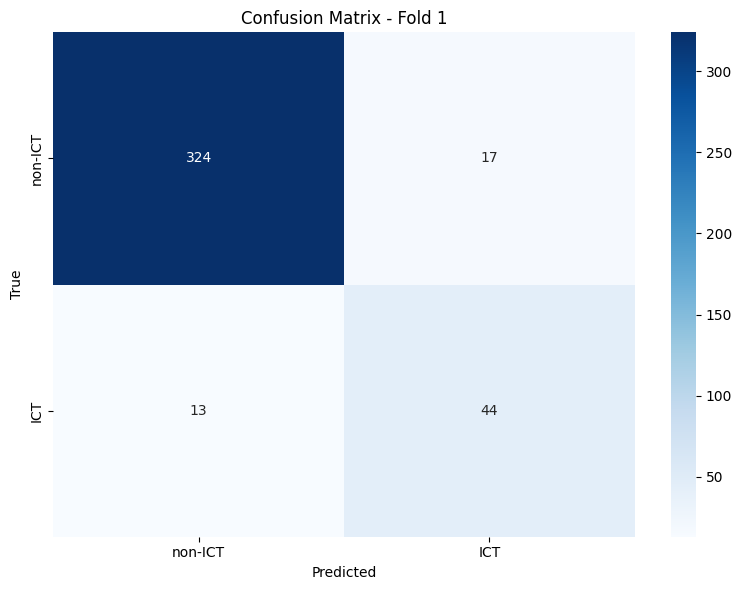

✅ Fold 1 completed!

🔥 FOLD 2/5
💾 Pre-fold GPU Memory: 0.02GB allocated, 0.04GB cached
📊 Original Train: 1589 samples, Val: 398 samples

🔄 Applying hybrid sampling to training data...
📊 Original class distribution:
    Majority class (0): 1361 samples
    Minority class (1): 228 samples
    Class imbalance ratio: 5.97:1
📊 After hybrid sampling:
    Majority class (0): 816 samples
    Minority class (1): 228 samples
    New class ratio: 3.58:1
    Total samples: 1044 (removed 545 majority samples, added 0 minority samples)
📊 After hybrid sampling - Train: 1044 samples

🔄 Calculating class weights...
📊 Calculated class weights:
    non-ICT (Class 0): 0.6397
    ICT (Class 1): 2.2895
🔄 Pre-tokenizing 1044 texts (max_length=256)...
    Tokenizing 500/1044...
    Tokenizing 1000/1044...
✅ Pre-tokenization complete: 1044 samples
🔄 Pre-tokenizing 398 texts (max_length=256)...
✅ Pre-tokenization complete: 398 samples
🔄 Loading model with memory optimization...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


💾 Post-model-load GPU Memory: 0.59GB allocated
✅ Using Focal Loss with gamma=2.0
✅ Gradient checkpointing enabled to save memory
🚀 Starting training for fold...

--- Epoch 1/3 ---
    🔍 Batch on device: cuda:0
    🔍 Model on device: Next param device: cuda:0
    📈 Batch 1/87 (1.1%) | Loss: 0.4287 | Acc: 58.33% | LR: 2.0e-05 | Time: 1.2s
    💾 GPU Memory: 2.31GB allocated, 2.94GB cached
    📈 Batch 11/87 (12.6%) | Loss: 0.1332 | Acc: 54.55% | LR: 2.0e-05 | Time: 12.5s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 21/87 (24.1%) | Loss: 0.2898 | Acc: 65.08% | LR: 2.0e-05 | Time: 24.4s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 31/87 (35.6%) | Loss: 0.1166 | Acc: 61.83% | LR: 2.0e-05 | Time: 36.4s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 41/87 (47.1%) | Loss: 0.2267 | Acc: 62.60% | LR: 2.0e-05 | Time: 48.0s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 51/87 (58.6%) | Loss: 0.0992 | Acc: 65.20% | LR: 2.0e-05 | Time: 59

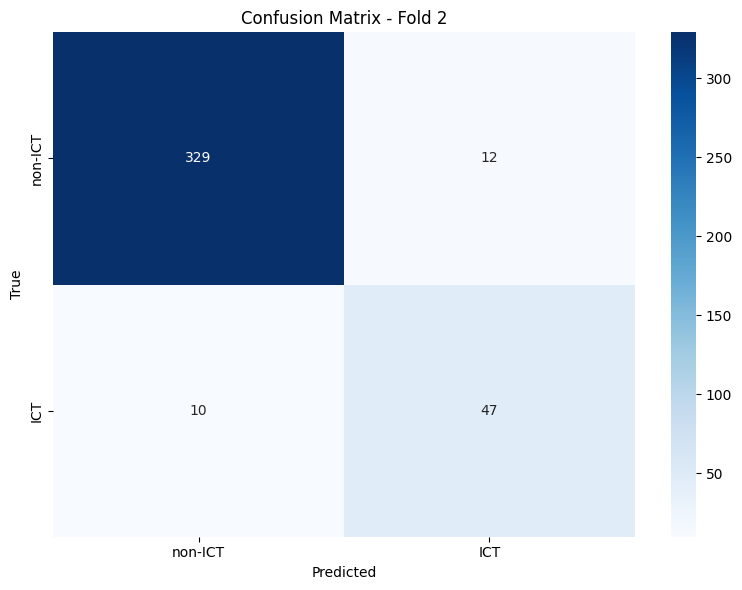

✅ Fold 2 completed!

🔥 FOLD 3/5
💾 Pre-fold GPU Memory: 0.02GB allocated, 0.04GB cached
📊 Original Train: 1590 samples, Val: 397 samples

🔄 Applying hybrid sampling to training data...
📊 Original class distribution:
    Majority class (0): 1362 samples
    Minority class (1): 228 samples
    Class imbalance ratio: 5.97:1
📊 After hybrid sampling:
    Majority class (0): 817 samples
    Minority class (1): 228 samples
    New class ratio: 3.58:1
    Total samples: 1045 (removed 545 majority samples, added 0 minority samples)
📊 After hybrid sampling - Train: 1045 samples

🔄 Calculating class weights...
📊 Calculated class weights:
    non-ICT (Class 0): 0.6395
    ICT (Class 1): 2.2917
🔄 Pre-tokenizing 1045 texts (max_length=256)...
    Tokenizing 500/1045...
    Tokenizing 1000/1045...
✅ Pre-tokenization complete: 1045 samples
🔄 Pre-tokenizing 397 texts (max_length=256)...
✅ Pre-tokenization complete: 397 samples
🔄 Loading model with memory optimization...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


💾 Post-model-load GPU Memory: 0.59GB allocated
✅ Using Focal Loss with gamma=2.0
✅ Gradient checkpointing enabled to save memory
🚀 Starting training for fold...

--- Epoch 1/3 ---
    🔍 Batch on device: cuda:0
    🔍 Model on device: Next param device: cuda:0
    📈 Batch 1/88 (1.1%) | Loss: 0.3812 | Acc: 16.67% | LR: 2.0e-05 | Time: 1.2s
    💾 GPU Memory: 2.31GB allocated, 2.94GB cached
    📈 Batch 11/88 (12.5%) | Loss: 0.0345 | Acc: 52.27% | LR: 2.0e-05 | Time: 12.4s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 21/88 (23.9%) | Loss: 0.1927 | Acc: 61.51% | LR: 2.0e-05 | Time: 24.3s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 31/88 (35.2%) | Loss: 0.1163 | Acc: 63.98% | LR: 2.0e-05 | Time: 36.3s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 41/88 (46.6%) | Loss: 0.0277 | Acc: 64.84% | LR: 2.0e-05 | Time: 47.9s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 51/88 (58.0%) | Loss: 0.1052 | Acc: 68.79% | LR: 2.0e-05 | Time: 59

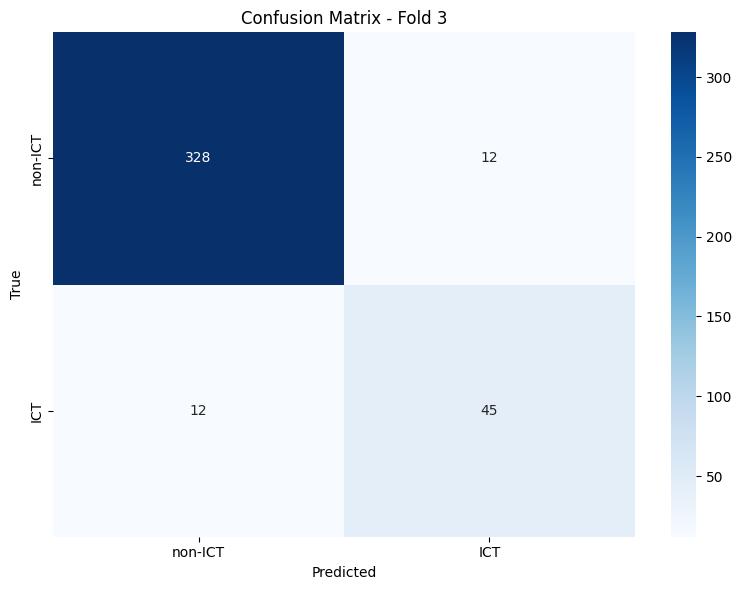

✅ Fold 3 completed!

🔥 FOLD 4/5
💾 Pre-fold GPU Memory: 0.02GB allocated, 0.04GB cached
📊 Original Train: 1590 samples, Val: 397 samples

🔄 Applying hybrid sampling to training data...
📊 Original class distribution:
    Majority class (0): 1362 samples
    Minority class (1): 228 samples
    Class imbalance ratio: 5.97:1
📊 After hybrid sampling:
    Majority class (0): 817 samples
    Minority class (1): 228 samples
    New class ratio: 3.58:1
    Total samples: 1045 (removed 545 majority samples, added 0 minority samples)
📊 After hybrid sampling - Train: 1045 samples

🔄 Calculating class weights...
📊 Calculated class weights:
    non-ICT (Class 0): 0.6395
    ICT (Class 1): 2.2917
🔄 Pre-tokenizing 1045 texts (max_length=256)...
    Tokenizing 500/1045...
    Tokenizing 1000/1045...
✅ Pre-tokenization complete: 1045 samples
🔄 Pre-tokenizing 397 texts (max_length=256)...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Pre-tokenization complete: 397 samples
🔄 Loading model with memory optimization...
💾 Post-model-load GPU Memory: 0.59GB allocated
✅ Using Focal Loss with gamma=2.0
✅ Gradient checkpointing enabled to save memory
🚀 Starting training for fold...

--- Epoch 1/3 ---
    🔍 Batch on device: cuda:0
    🔍 Model on device: Next param device: cuda:0
    📈 Batch 1/88 (1.1%) | Loss: 0.2312 | Acc: 33.33% | LR: 2.0e-05 | Time: 1.1s
    💾 GPU Memory: 2.31GB allocated, 2.94GB cached
    📈 Batch 11/88 (12.5%) | Loss: 0.1149 | Acc: 61.36% | LR: 2.0e-05 | Time: 12.4s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 21/88 (23.9%) | Loss: 0.0314 | Acc: 63.10% | LR: 2.0e-05 | Time: 24.1s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 31/88 (35.2%) | Loss: 0.1547 | Acc: 65.59% | LR: 2.0e-05 | Time: 36.0s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 41/88 (46.6%) | Loss: 0.2092 | Acc: 68.09% | LR: 2.0e-05 | Time: 47.7s
    💾 GPU Memory: 2.32GB allocated, 2.94GB c

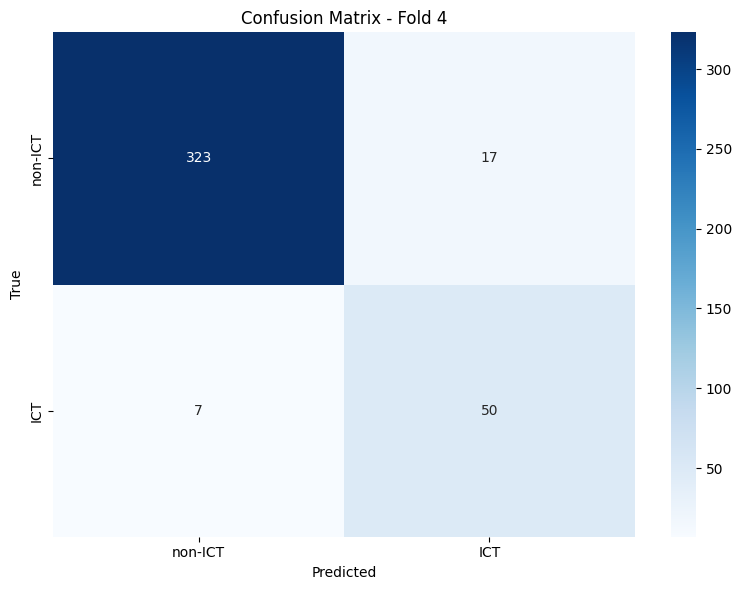

✅ Fold 4 completed!

🔥 FOLD 5/5
💾 Pre-fold GPU Memory: 0.02GB allocated, 0.04GB cached
📊 Original Train: 1590 samples, Val: 397 samples

🔄 Applying hybrid sampling to training data...
📊 Original class distribution:
    Majority class (0): 1362 samples
    Minority class (1): 228 samples
    Class imbalance ratio: 5.97:1
📊 After hybrid sampling:
    Majority class (0): 817 samples
    Minority class (1): 228 samples
    New class ratio: 3.58:1
    Total samples: 1045 (removed 545 majority samples, added 0 minority samples)
📊 After hybrid sampling - Train: 1045 samples

🔄 Calculating class weights...
📊 Calculated class weights:
    non-ICT (Class 0): 0.6395
    ICT (Class 1): 2.2917
🔄 Pre-tokenizing 1045 texts (max_length=256)...
    Tokenizing 500/1045...
    Tokenizing 1000/1045...
✅ Pre-tokenization complete: 1045 samples
🔄 Pre-tokenizing 397 texts (max_length=256)...
✅ Pre-tokenization complete: 397 samples
🔄 Loading model with memory optimization...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


💾 Post-model-load GPU Memory: 0.59GB allocated
✅ Using Focal Loss with gamma=2.0
✅ Gradient checkpointing enabled to save memory
🚀 Starting training for fold...

--- Epoch 1/3 ---
    🔍 Batch on device: cuda:0
    🔍 Model on device: Next param device: cuda:0
    📈 Batch 1/88 (1.1%) | Loss: 0.0181 | Acc: 100.00% | LR: 2.0e-05 | Time: 1.2s
    💾 GPU Memory: 2.31GB allocated, 2.94GB cached
    📈 Batch 11/88 (12.5%) | Loss: 0.1533 | Acc: 62.88% | LR: 2.0e-05 | Time: 12.4s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 21/88 (23.9%) | Loss: 0.1490 | Acc: 63.10% | LR: 2.0e-05 | Time: 24.1s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 31/88 (35.2%) | Loss: 0.1805 | Acc: 66.67% | LR: 2.0e-05 | Time: 36.0s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 41/88 (46.6%) | Loss: 0.2698 | Acc: 68.90% | LR: 2.0e-05 | Time: 47.7s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 51/88 (58.0%) | Loss: 0.1493 | Acc: 69.77% | LR: 2.0e-05 | Time: 5

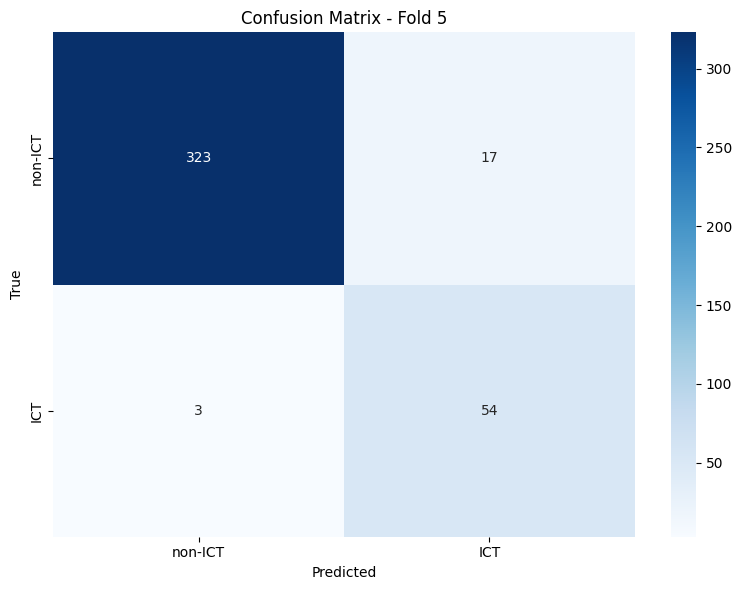

✅ Fold 5 completed!

🎯 FINAL CROSS-VALIDATION RESULTS
📊 Cross-Validation Average Metrics (based on best model per fold):
    Accuracy: 0.9396 ± 0.0084
    Precision: 0.7628 ± 0.0278
    Recall: 0.8421 ± 0.0637
    F1: 0.7992 ± 0.0320

🏆 Best Performing Fold (by F1 score): Fold 5 with F1: 0.8437

📊 Average Confusion Matrix across all folds:

✅ GPU-Optimized Training with Class Balancing Complete!
🏆 Best performing fold during cross-validation: 5
📁 Cross-validation fold results saved to /kaggle/working/gpu_fold_results_with_balancing.pkl

🧪 EVALUATING ON TEST SET
🔄 Loading best model from fold 5...

📊 Test Set Class Distribution:
    non-ICT (Class 0): 426 (85.7%)
    ICT (Class 1): 71 (14.3%)
📊 Creating test dataset with 497 samples...
🔄 Pre-tokenizing 497 texts (max_length=256)...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Pre-tokenization complete: 497 samples
✅ Successfully loaded best model from /kaggle/working/best_model_fold_5.pth
🔍 Using optimal threshold from best fold: 0.350

🔄 Calculating test class weights for evaluation...
📊 Calculated class weights:
    non-ICT (Class 0): 0.5833
    ICT (Class 1): 3.5000
✅ Using Focal Loss with gamma=2.0

🧪 Evaluating model on test set with default threshold (0.5)...

📊 Test Set Results with Default Threshold (0.5):
    Accuracy: 94.37%
    ICT Class (Minority):
      Precision: 0.7867
      Recall: 0.8310
      F1 Score: 0.8082

🧪 Applying optimal threshold (0.350) from cross-validation...

📊 Test Set Results with Optimal Threshold (0.350):
    Accuracy: 91.55%
    ICT Class (Minority):
      Precision: 0.6526
      Recall: 0.8732
      F1 Score: 0.7470

📋 Test Set Classification Report (with optimal threshold):
              precision    recall  f1-score   support

     non-ICT       0.98      0.92      0.95       426
         ICT       0.65      0.87    

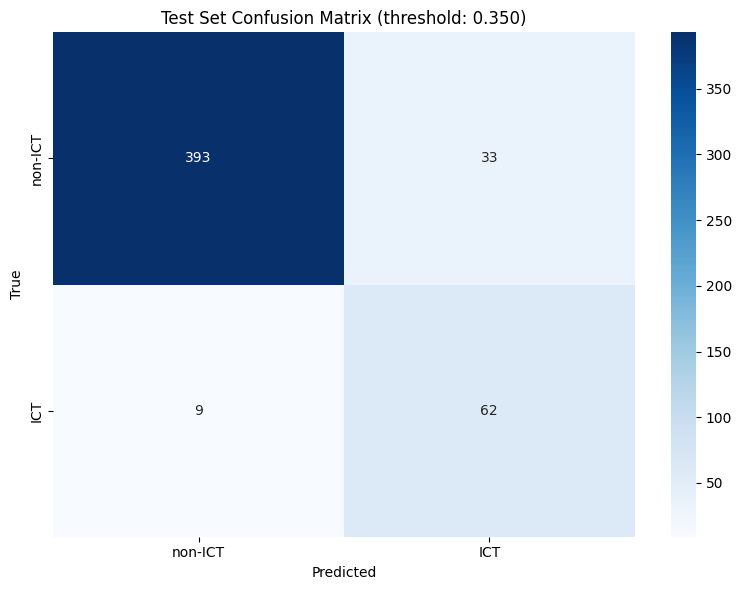


📈 Threshold Comparison - Confusion Matrix Improvement:
    Default Threshold (0.5):
      True Positives: 59, False Positives: 16
      True Negatives: 410, False Negatives: 12
    Optimal Threshold (0.350):
      True Positives: 62, False Positives: 33
      True Negatives: 393, False Negatives: 9
    Change with Optimal Threshold:
      True Positives: +5.1%
      False Positives: +106.2%

🔍 Finding optimal threshold directly on test set (for reference only)...
    Test set optimal threshold: 0.800 (F1: 0.8462)
    Cross-validation optimal threshold: 0.350 (F1: 0.7470)
📁 Test results saved to /kaggle/working/test_results_with_thresholds.pkl

✅ Evaluation Complete!
🏁 PIPELINE FINISHED SUCCESSFULLY


In [8]:
# Alternative GPU-Optimized Approach with Native PyTorch
import os
import subprocess
import sys
import time
from datetime import datetime, timedelta
from collections import Counter
import random

# CRITICAL: Clear all GPU memory from previous runs FIRST
import torch
if torch.cuda.is_available():
    print("🧹 Clearing ALL GPU memory from previous runs...")
    torch.cuda.empty_cache()
    # Force garbage collection
    import gc
    gc.collect()
    # Clear memory more aggressively
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)
        torch.cuda.empty_cache()
    print("✅ GPU memory cleared!")

# Force GPU usage without complex multiprocessing
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Try a simpler import approach to avoid dependency issues
import pandas as pd
import numpy as np
import pickle
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import sklearn modules individually to avoid potential import errors
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix

# Import transformers after other imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# GPU setup and verification
def setup_gpu():
    if not torch.cuda.is_available():
        print("❌ No GPU available!")
        return torch.device('cpu'), False
    
    try:
        device = torch.device('cuda:0')
        torch.cuda.set_device(device)
    except RuntimeError as e:
        print(f"❌ Error setting CUDA device: {e}. Falling back to CPU.")
        return torch.device('cpu'), False

    print("🧪 Comprehensive GPU test...")
    try:
        # Test 1: Basic operations
        x = torch.randn(1000, 1000, device=device)
        y = torch.mm(x, x)
        print("✅ Basic GPU operations: OK")
        
        # Test 2: Gradient computation
        x.requires_grad_(True)
        z = (y * x).sum()
        z.backward()
        print("✅ GPU gradient computation: OK")
        
        # Test 3: Memory allocation
        large_tensor = torch.randn(5000, 5000, device=device)
        del large_tensor, x, y, z
        torch.cuda.empty_cache()
        print("✅ GPU memory management: OK")
        
        # Print GPU info
        gpu_name = torch.cuda.get_device_name(0)
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"🎮 GPU: {gpu_name}")
        print(f"💾 Total Memory: {total_memory:.1f} GB")
        
        return device, True
    except Exception as e:
        print(f"❌ GPU test failed: {e}")
        return torch.device('cpu'), False

# Set random seeds
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
device, gpu_available = setup_gpu()

# Combined under-sampling of majority class and over-sampling of minority class
def hybrid_sampling(texts, labels, target_ratio=0.25, random_state=42):
    """
    Hybrid approach: Undersample majority class + oversample minority class
    
    Args:
        texts: List of text samples
        labels: List of corresponding labels
        target_ratio: Target ratio of minority to majority class
        random_state: Random seed for reproducibility
    
    Returns:
        Tuple of (resampled_texts, resampled_labels)
    """
    random.seed(random_state)
    np.random.seed(random_state)
    
    # Convert to numpy arrays for easier manipulation
    texts_array = np.array(texts)
    labels_array = np.array(labels)
    
    # Count class distribution
    class_counts = Counter(labels)
    majority_class = max(class_counts, key=class_counts.get)
    minority_class = min(class_counts, key=class_counts.get)
    
    majority_count = class_counts[majority_class]
    minority_count = class_counts[minority_class]
    
    print(f"📊 Original class distribution:")
    print(f"    Majority class ({majority_class}): {majority_count} samples")
    print(f"    Minority class ({minority_class}): {minority_count} samples")
    print(f"    Class imbalance ratio: {majority_count/minority_count:.2f}:1")
    
    # Step 1: Undersample majority class by removing some samples
    # We'll keep majority_count * undersampling_ratio samples
    undersampling_ratio = 0.6  # Keep 60% of majority samples
    new_majority_count = int(majority_count * undersampling_ratio)
    
    # Get indices of majority class
    majority_indices = np.where(labels_array == majority_class)[0]
    # Randomly select indices to keep
    majority_indices_to_keep = np.random.choice(majority_indices, size=new_majority_count, replace=False)
    
    # Step 2: Oversample minority class 
    # Calculate how many minority samples we need
    target_minority_count = int(new_majority_count * target_ratio)
    samples_to_add = max(0, target_minority_count - minority_count)
    
    # Get indices of minority class
    minority_indices = np.where(labels_array == minority_class)[0]
    
    # Randomly sample indices to duplicate (with replacement)
    additional_indices = np.random.choice(minority_indices, size=samples_to_add, replace=True)
    
    # Create resampled dataset
    # Combine kept majority samples and all original minority samples
    indices_to_keep = np.concatenate([majority_indices_to_keep, minority_indices])
    resampled_texts = texts_array[indices_to_keep].tolist()
    resampled_labels = labels_array[indices_to_keep].tolist()
    
    # Add oversampled minority samples
    resampled_texts.extend(texts_array[additional_indices].tolist())
    resampled_labels.extend(labels_array[additional_indices].tolist())
    
    # Shuffle the resampled data
    combined = list(zip(resampled_texts, resampled_labels))
    random.shuffle(combined)
    resampled_texts, resampled_labels = zip(*combined)
    
    # Report new distribution
    new_class_counts = Counter(resampled_labels)
    print(f"📊 After hybrid sampling:")
    print(f"    Majority class ({majority_class}): {new_class_counts[majority_class]} samples")
    print(f"    Minority class ({minority_class}): {new_class_counts[minority_class]} samples")
    print(f"    New class ratio: {new_class_counts[majority_class]/new_class_counts[minority_class]:.2f}:1")
    print(f"    Total samples: {len(resampled_texts)} (removed {majority_count - new_majority_count} majority samples, added {samples_to_add} minority samples)")
    
    return list(resampled_texts), list(resampled_labels)

# Calculate class weights for loss function
def calculate_class_weights(labels, device):
    """
    Calculate class weights inversely proportional to class frequencies.
    
    Args:
        labels: List of labels
        device: PyTorch device
    
    Returns:
        torch.Tensor: Class weights tensor
    """
    class_counts = Counter(labels)
    total_samples = len(labels)
    num_classes = len(class_counts)
    
    # Calculate weights: weight = total_samples / (num_classes * class_count)
    class_weights = {}
    for class_label in sorted(class_counts.keys()):
        weight = total_samples / (num_classes * class_counts[class_label])
        class_weights[class_label] = weight
    
    # Convert to tensor
    weights_tensor = torch.tensor([class_weights[i] for i in sorted(class_weights.keys())], 
                                 dtype=torch.float32, device=device)
    
    print(f"📊 Calculated class weights:")
    for class_label, weight in class_weights.items():
        class_name = 'ICT' if class_label == 1 else 'non-ICT'
        print(f"    {class_name} (Class {class_label}): {weight:.4f}")
    
    return weights_tensor

# Optimized Dataset Class with Memory Management
class OptimizedResumeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        print(f"🔄 Pre-tokenizing {len(texts)} texts (max_length={max_length})...")
        self.tokenized_data = []
        
        for i, text in enumerate(texts):
            if i % 500 == 0 and i > 0:
                print(f"    Tokenizing {i}/{len(texts)}...")
            
            encoding = self.tokenizer(
                str(text),
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )
            
            self.tokenized_data.append({
                'input_ids': encoding['input_ids'].squeeze(0),
                'attention_mask': encoding['attention_mask'].squeeze(0),
                'labels': torch.tensor(labels[i], dtype=torch.long)
            })
        
        print(f"✅ Pre-tokenization complete: {len(self.tokenized_data)} samples")
    
    def __len__(self):
        return len(self.tokenized_data)
    
    def __getitem__(self, idx):
        return self.tokenized_data[idx]

# Custom Training Loop with Focal Loss and Threshold Adjustment
import torch.nn as nn
import torch.nn.functional as F

# Focal Loss Implementation with moderate gamma (2.0)
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Focal Loss for addressing class imbalance.
        
        Args:
            alpha: Weighting factor for rare class (can be scalar or tensor)
            gamma: Focusing parameter (higher gamma = more focus on hard examples)
            reduction: Specifies the reduction to apply to the output
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        # Compute cross entropy
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Compute p_t
        pt = torch.exp(-ce_loss)
        
        # Compute alpha_t (if alpha is provided)
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_t = self.alpha
            else:
                alpha_t = self.alpha[targets]
        else:
            alpha_t = 1.0
        
        # Compute focal loss
        focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names=['non-ICT', 'ICT'], title='Confusion Matrix'):
    """
    Plot confusion matrix with seaborn heatmap.
    
    Args:
        cm: Confusion matrix
        class_names: List of class names
        title: Title for the plot
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    
    # Save plot to file
    save_dir = '/kaggle/working'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    
    # Create a unique filename including timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{save_dir}/{title.replace(' ', '_')}_{timestamp}.png"
    plt.savefig(filename)
    
    print(f"📊 Confusion matrix saved to {filename}")
    plt.show()

class GPUTrainer:
    def __init__(self, model, device, batch_size=16, gradient_clip_val=1.0, class_weights=None, use_focal_loss=True, high_recall_mode=True):
        self.model = model.to(device)
        self.device = device
        self.batch_size = batch_size
        self.gradient_clip_val = gradient_clip_val
        self.use_focal_loss = use_focal_loss
        self.high_recall_mode = high_recall_mode  # Prioritize recall for minority class
        
        # Use Focal Loss or weighted CrossEntropyLoss
        if use_focal_loss:
            # Convert class weights to alpha for focal loss
            if class_weights is not None:
                alpha = class_weights.clone()
            else:
                alpha = None
            self.criterion = FocalLoss(alpha=alpha, gamma=2.0)  # Reduced gamma from 3.0 to 2.0
            print(f"✅ Using Focal Loss with gamma=2.0")
        else:
            # Use weighted CrossEntropyLoss if class weights are provided
            if class_weights is not None:
                self.criterion = nn.CrossEntropyLoss(weight=class_weights)
                print(f"✅ Using weighted CrossEntropyLoss with class weights")
            else:
                self.criterion = nn.CrossEntropyLoss()
                print(f"✅ Using standard CrossEntropyLoss")
        
    def train_epoch(self, train_loader, optimizer, epoch):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        start_time = time.time()
        
        for batch_idx, batch in enumerate(train_loader):
            # Explicit GPU transfer
            input_ids = batch['input_ids'].to(self.device, non_blocking=True if gpu_available else False)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True if gpu_available else False)
            labels = batch['labels'].to(self.device, non_blocking=True if gpu_available else False)
            
            if batch_idx == 0 and epoch == 0:
                print(f"    🔍 Batch on device: {input_ids.device}")
                print(f"    🔍 Model on device: Next param device: {next(self.model.parameters()).device}")
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = self.criterion(logits, labels)
            
            # NOTE: Removed manual L2 regularization as AdamW's weight_decay handles this properly
            
            # Backward pass
            loss.backward()
            
            # Gradient Clipping
            if self.gradient_clip_val is not None and self.gradient_clip_val > 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_clip_val)

            optimizer.step()
            
            # Statistics
            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Progress updates
            if batch_idx % 10 == 0 or batch_idx == len(train_loader) - 1:
                elapsed = time.time() - start_time
                progress = (batch_idx + 1) / len(train_loader) * 100
                current_lr = optimizer.param_groups[0]['lr']
                print(f"    📈 Batch {batch_idx+1}/{len(train_loader)} ({progress:.1f}%) | "
                      f"Loss: {loss.item():.4f} | "
                      f"Acc: {100.*correct/total:.2f}% | "
                      f"LR: {current_lr:.1e} | "
                      f"Time: {elapsed:.1f}s")
                
                if gpu_available:
                    memory_allocated = torch.cuda.memory_allocated(self.device) / 1024**3
                    memory_cached = torch.cuda.memory_reserved(self.device) / 1024**3
                    print(f"    💾 GPU Memory: {memory_allocated:.2f}GB allocated, {memory_cached:.2f}GB cached")
        
        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        return avg_loss, accuracy
    
    def find_optimal_threshold(self, val_loader):
        """Find optimal classification threshold that maximizes F1 score or prioritizes recall."""
        self.model.eval()
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(self.device, non_blocking=True if gpu_available else False)
                attention_mask = batch['attention_mask'].to(self.device, non_blocking=True if gpu_available else False)
                labels = batch['labels'].to(self.device, non_blocking=True if gpu_available else False)
                
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = F.softmax(logits, dim=1)
                
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
                all_labels.extend(labels.cpu().numpy())
        
        # Try different thresholds
        thresholds = np.arange(0.1, 0.9, 0.05)
        best_f1 = 0
        best_threshold = 0.5
        
        # For high recall mode
        high_recall_threshold = 0.5
        highest_recall = 0
        
        for threshold in thresholds:
            predictions = (np.array(all_probs) >= threshold).astype(int)
            f1 = f1_score(all_labels, predictions, average='binary', pos_label=1, zero_division=0)
            recall = recall_score(all_labels, predictions, average='binary', pos_label=1, zero_division=0)
            precision = precision_score(all_labels, predictions, average='binary', pos_label=1, zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
            
            # Find threshold that gives highest recall while maintaining at least 0.7 precision (increased from 0.3)
            if recall > highest_recall and precision >= 0.7:
                highest_recall = recall
                high_recall_threshold = threshold
        
        # Use high recall threshold in high recall mode, otherwise use best F1 threshold
        optimal_threshold = high_recall_threshold if self.high_recall_mode else best_threshold
        
        return optimal_threshold, best_f1
    
    def evaluate(self, val_loader, find_threshold=False, threshold=0.5):
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(self.device, non_blocking=True if gpu_available else False)
                attention_mask = batch['attention_mask'].to(self.device, non_blocking=True if gpu_available else False)
                labels = batch['labels'].to(self.device, non_blocking=True if gpu_available else False)
                
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = self.criterion(logits, labels)
                
                total_loss += loss.item()
                
                probs = F.softmax(logits, dim=1)
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
                all_labels.extend(labels.cpu().numpy())
                
                _, predicted = torch.max(logits.data, 1)
                all_predictions.extend(predicted.cpu().numpy())
        
        # Convert to numpy arrays
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        all_predictions = np.array(all_predictions)
        
        avg_loss = total_loss / len(val_loader)
        
        # Standard metrics with 0.5 threshold
        std_preds = (all_probs >= 0.5).astype(int)
        accuracy = accuracy_score(all_labels, std_preds) * 100
        precision = precision_score(all_labels, std_preds, average='binary', pos_label=1, zero_division=0)
        recall = recall_score(all_labels, std_preds, average='binary', pos_label=1, zero_division=0)
        f1 = f1_score(all_labels, std_preds, average='binary', pos_label=1, zero_division=0)
        
        # Calculate confusion matrix
        cm = confusion_matrix(all_labels, std_preds)
        
        # Find optimal threshold if requested
        optimal_threshold = 0.5
        optimal_preds = std_preds
        optimal_cm = cm
        optimal_metrics = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
        
        if find_threshold:
            # Find optimal threshold for different criteria
            f1_thresholds = np.arange(0.1, 0.9, 0.05)
            best_f1 = 0
            best_f1_threshold = 0.5
            
            high_recall_threshold = 0.5
            highest_recall = 0
            
            for thresh in f1_thresholds:
                thresh_preds = (all_probs >= thresh).astype(int)
                thresh_f1 = f1_score(all_labels, thresh_preds, average='binary', pos_label=1, zero_division=0)
                thresh_recall = recall_score(all_labels, thresh_preds, average='binary', pos_label=1, zero_division=0)
                
                if thresh_f1 > best_f1:
                    best_f1 = thresh_f1
                    best_f1_threshold = thresh
                
                # Find threshold that gives highest recall while maintaining at least 0.7 precision
                thresh_precision = precision_score(all_labels, thresh_preds, average='binary', pos_label=1, zero_division=0)
                if thresh_recall > highest_recall and thresh_precision >= 0.7:  # Increased from 0.3 to 0.7
                    highest_recall = thresh_recall
                    high_recall_threshold = thresh
            
            # Use high recall threshold in high recall mode, otherwise use best F1 threshold
            optimal_threshold = high_recall_threshold if self.high_recall_mode else best_f1_threshold
            
            # Calculate metrics with optimal threshold
            optimal_preds = (all_probs >= optimal_threshold).astype(int)
            optimal_accuracy = accuracy_score(all_labels, optimal_preds) * 100
            optimal_precision = precision_score(all_labels, optimal_preds, average='binary', pos_label=1, zero_division=0)
            optimal_recall = recall_score(all_labels, optimal_preds, average='binary', pos_label=1, zero_division=0)
            optimal_f1 = f1_score(all_labels, optimal_preds, average='binary', pos_label=1, zero_division=0)
            
            optimal_cm = confusion_matrix(all_labels, optimal_preds)
            optimal_metrics = {
                'accuracy': optimal_accuracy, 
                'precision': optimal_precision, 
                'recall': optimal_recall, 
                'f1': optimal_f1
            }
            
        return avg_loss, optimal_metrics, optimal_preds, all_labels, optimal_threshold, optimal_cm, all_probs

# Main training function with hybrid sampling and high recall focus
def train_with_gpu_optimization(texts, labels, n_splits=5, use_hybrid_sampling=True, use_class_weights=True, target_ratio=0.25):
    print("\n🚀 Starting GPU-Optimized Training with Class Balancing & Precision Focus")
    print("="*80)
    
    model_name = "answerdotai/ModernBERT-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Determine optimal settings
    optimal_batch_size = 16
    num_workers = 0
    if gpu_available:
        total_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        print(f"    Detected GPU Total Memory: {total_memory_gb:.1f}GB")
        if total_memory_gb < 10:
             optimal_batch_size = 8
        elif total_memory_gb < 16:
             optimal_batch_size = 12
    else:
        optimal_batch_size = 8

    print(f"🔧 Configuration:")
    print(f"    Model: {model_name}")
    print(f"    Device: {device}")
    print(f"    Batch size: {optimal_batch_size}")
    print(f"    DataLoaders num_workers: {num_workers}")
    print(f"    GPU Available: {gpu_available}")
    print(f"    Use Hybrid Sampling: {use_hybrid_sampling}")
    print(f"    Use Class Weights: {use_class_weights}")
    print(f"    Focal Loss Gamma: 2.0 (balanced)")
    print(f"    Dropout Rate: 0.3 (added to model)")
    print(f"    Weight Decay: 0.02 (L2 regularization via AdamW)")
    print(f"    Min Precision Threshold: 0.7 (for optimal recall)")
    if use_hybrid_sampling:
        print(f"    Target Ratio (minority:majority): {target_ratio}")
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(np.array(texts), np.array(labels))):
        print(f"\n{'='*60}")
        print(f"🔥 FOLD {fold+1}/{n_splits}")
        print(f"{'='*60}")
        
        if gpu_available:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
            memory_allocated = torch.cuda.memory_allocated(device) / 1024**3
            memory_cached = torch.cuda.memory_reserved(device) / 1024**3
            print(f"💾 Pre-fold GPU Memory: {memory_allocated:.2f}GB allocated, {memory_cached:.2f}GB cached")
        
        # Use np.array for indexing compatibility with scikit-learn splits
        train_texts_fold = np.array(texts)[train_idx].tolist()
        val_texts_fold = np.array(texts)[val_idx].tolist()
        train_labels_fold = np.array(labels)[train_idx].tolist()
        val_labels_fold = np.array(labels)[val_idx].tolist()
        
        print(f"📊 Original Train: {len(train_texts_fold)} samples, Val: {len(val_texts_fold)} samples")
        
        # Apply hybrid sampling to training data if enabled
        if use_hybrid_sampling:
            print("\n🔄 Applying hybrid sampling to training data...")
            train_texts_fold, train_labels_fold = hybrid_sampling(
                train_texts_fold, train_labels_fold, target_ratio=target_ratio, random_state=42+fold
            )
            print(f"📊 After hybrid sampling - Train: {len(train_texts_fold)} samples")
        
        # Calculate class weights if enabled
        class_weights = None
        if use_class_weights:
            print("\n🔄 Calculating class weights...")
            class_weights = calculate_class_weights(train_labels_fold, device)
        
        train_dataset = OptimizedResumeDataset(train_texts_fold, train_labels_fold, tokenizer)
        val_dataset = OptimizedResumeDataset(val_texts_fold, val_labels_fold, tokenizer)
        
        train_loader = DataLoader(
            train_dataset, batch_size=optimal_batch_size, shuffle=True,
            num_workers=num_workers, pin_memory=gpu_available, persistent_workers=False if num_workers == 0 else True
        )
        val_loader = DataLoader(
            val_dataset, batch_size=optimal_batch_size, shuffle=False,
            num_workers=num_workers, pin_memory=gpu_available, persistent_workers=False if num_workers == 0 else True
        )
        
        print("🔄 Loading model with memory optimization...")
        config = {"hidden_dropout_prob": 0.3, "attention_probs_dropout_prob": 0.3}  # Increase dropout
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=2,
            low_cpu_mem_usage=True,
            config=config
        ).to(device)

        if gpu_available:
            memory_allocated = torch.cuda.memory_allocated(device) / 1024**3
            print(f"💾 Post-model-load GPU Memory: {memory_allocated:.2f}GB allocated")
        
        # Pass class weights to trainer with focal loss option and high recall mode
        trainer = GPUTrainer(
            model, device, optimal_batch_size, gradient_clip_val=1.0,
            class_weights=class_weights, use_focal_loss=True, high_recall_mode=True
        )
        
        # Use AdamW with moderate weight decay (L2 regularization)
        optimizer = torch.optim.AdamW(
            model.parameters(), lr=2e-5, weight_decay=0.02, eps=1e-8  # Reduced from 0.05 to 0.02
        )
        
        # Enable gradient checkpointing to save memory
        if hasattr(model, 'gradient_checkpointing_enable') and gpu_available:
            try:
                model.gradient_checkpointing_enable()
                print("✅ Gradient checkpointing enabled to save memory")
            except Exception as e:
                print(f"⚠️ Could not enable gradient checkpointing: {e}")
        
        best_f1 = 0
        patience = 3
        patience_counter = 0
        num_epochs = 3  # Reduced from 4 to 3
        
        print("🚀 Starting training for fold...")
        for epoch in range(num_epochs):
            epoch_start_time = time.time()
            print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
            
            train_loss, train_acc = trainer.train_epoch(train_loader, optimizer, epoch)
            val_loss, val_metrics, val_preds, val_true, optimal_threshold, val_cm, val_probs = trainer.evaluate(val_loader, find_threshold=True)
            
            epoch_duration = time.time() - epoch_start_time
            
            print(f"📊 Epoch {epoch+1} Results:")
            print(f"    Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
            print(f"    Val   - Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.2f}%")
            print(f"    Val ICT Class - Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}")
            print(f"    Val F1: {val_metrics['f1']:.4f}")
            print(f"    Optimal Threshold: {optimal_threshold:.3f}")
            print(f"    Time: {epoch_duration:.1f}s")
            
            # Use F1 as primary metric
            if val_metrics['f1'] > best_f1:
                best_f1 = val_metrics['f1']
                patience_counter = 0
                if not os.path.exists('/kaggle/working'):
                    os.makedirs('/kaggle/working', exist_ok=True)
                torch.save(model.state_dict(), f'/kaggle/working/best_model_fold_{fold+1}.pth')
                print(f"    ⭐ New best F1: {best_f1:.4f}. Model saved.")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"    🛑 Early stopping triggered after {epoch+1} epochs.")
                    break
        
        print(f"\n📋 Fold {fold+1} Final Results:")
        # Load best model for this fold for final report if it was saved
        if os.path.exists(f'/kaggle/working/best_model_fold_{fold+1}.pth'):
            model.load_state_dict(torch.load(f'/kaggle/working/best_model_fold_{fold+1}.pth'))
            print("    Loaded best model for this fold to report metrics.")
            # Re-evaluate with the best model state for this fold using optimal threshold
            val_loss, val_metrics, val_preds, val_true, optimal_threshold, val_cm, val_probs = trainer.evaluate(val_loader, find_threshold=True)

        print(f"    Best Val F1 for this fold: {best_f1:.4f}")
        print(f"    Final Val F1 (with optimal threshold {optimal_threshold:.3f}): {val_metrics['f1']:.4f}")
        print(f"    Final Val metrics for ICT class (Class 1):")
        print(f"      Precision: {val_metrics['precision']:.4f}")
        print(f"      Recall: {val_metrics['recall']:.4f}")
        print(f"      F1: {val_metrics['f1']:.4f}")
        
        print(f"    Classification Report (with optimal threshold):")
        # Ensure target_names match the number of unique labels
        unique_labels_count = len(set(labels))
        target_names_report = [f'Class {i}' for i in range(unique_labels_count)]
        if unique_labels_count == 2:
            target_names_report = ['non-ICT', 'ICT']
        print(classification_report(val_true, val_preds, target_names=target_names_report, zero_division=0))
        
        # Plot confusion matrix for this fold
        print("\n📊 Fold Confusion Matrix:")
        plot_confusion_matrix(val_cm, class_names=target_names_report, title=f'Confusion Matrix - Fold {fold+1}')
        
        fold_results.append({
            'fold': fold+1, 
            'accuracy': val_metrics['accuracy']/100, 
            'precision': val_metrics['precision'],
            'recall': val_metrics['recall'], 
            'f1': val_metrics['f1'],
            'optimal_threshold': optimal_threshold, 
            'confusion_matrix': val_cm
        })
        
        del model, trainer, train_dataset, val_dataset, train_loader, val_loader, optimizer
        if gpu_available:
            torch.cuda.empty_cache()
        
        print(f"✅ Fold {fold+1} completed!")
    
    print(f"\n{'='*80}")
    print("🎯 FINAL CROSS-VALIDATION RESULTS")
    print(f"{'='*80}")
    
    if not fold_results:
        print("⚠️ No fold results to aggregate. Training might have failed or was skipped.")
        return [], -1

    avg_metrics = {
        metric: np.mean([r[metric] for r in fold_results])
        for metric in ['accuracy', 'precision', 'recall', 'f1']
    }
    std_metrics = {
        metric: np.std([r[metric] for r in fold_results])
        for metric in ['accuracy', 'precision', 'recall', 'f1']
    }
    
    print(f"📊 Cross-Validation Average Metrics (based on best model per fold):")
    for metric_name in ['accuracy', 'precision', 'recall', 'f1']:
        print(f"    {metric_name.capitalize()}: {avg_metrics[metric_name]:.4f} ± {std_metrics[metric_name]:.4f}")
    
    # Find best fold by F1 score
    best_overall_fold_info = max(fold_results, key=lambda x: x['f1'])
    print(f"\n🏆 Best Performing Fold (by F1 score): Fold {best_overall_fold_info['fold']} with F1: {best_overall_fold_info['f1']:.4f}")
    
    # Calculate average confusion matrix across all folds
    if all('confusion_matrix' in r for r in fold_results):
        #avg_cm = sum(r['confusion_matrix'] for r in fold_results) / len(fold_results)
        print("\n📊 Average Confusion Matrix across all folds:")
        unique_labels_count = len(set(labels))
        target_names = ['non-ICT', 'ICT'] if unique_labels_count == 2 else [f'Class {i}' for i in range(unique_labels_count)]
        #plot_confusion_matrix(avg_cm, class_names=target_names, title='Average Confusion Matrix - All Folds')
    
    return fold_results, best_overall_fold_info['fold']

# Load and preprocess data
print("📥 Loading data...")
# --- Create dummy data if file not found for local execution ---
data_file_path = '/kaggle/working/cv_data_with_ict_clusters.csv'
if not os.path.exists(data_file_path):
    print(f"⚠️ File {data_file_path} not found. Creating dummy data for demonstration.")
    if not os.path.exists('/kaggle/working'):
        os.makedirs('/kaggle/working', exist_ok=True)
    
    # Create a more substantial dummy dataset with class imbalance
    num_samples = 2000
    # Create imbalanced dataset (20% ICT, 80% non-ICT)
    ict_samples = int(num_samples * 0.2)
    non_ict_samples = num_samples - ict_samples
    
    dummy_texts_ict = [f"ict technical support engineer resume example {i}" for i in range(ict_samples)]
    dummy_texts_non_ict = [f"sales manager marketing skills cv {i}" for i in range(non_ict_samples)]
    dummy_labels_ict = ['ICT'] * ict_samples
    dummy_labels_non_ict = ['non-ICT'] * non_ict_samples

    all_dummy_texts = dummy_texts_ict + dummy_texts_non_ict
    all_dummy_labels = dummy_labels_ict + dummy_labels_non_ict

    # Shuffle the dummy data
    temp_df = pd.DataFrame({'full_text': all_dummy_texts, 'job_cluster_ICT': all_dummy_labels})
    temp_df = temp_df.sample(frac=1, random_state=42).reset_index(drop=True)

    temp_df.to_csv(data_file_path, index=False)
    cv_data = temp_df
else:
    cv_data = pd.read_csv(data_file_path)

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}', ' ', text)
    text = re.sub(r'[^\w\s.,!?-]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("🔄 Preprocessing data...")
cv_data['cleaned_text'] = cv_data['full_text'].apply(clean_text)
cv_data['cleaned_text'] = cv_data['cleaned_text'].fillna("")

if 'job_cluster_ICT' not in cv_data.columns:
    print("Error: 'job_cluster_ICT' column not found in the data. Please check your CSV file.")
    sys.exit(1)

cv_data['job_cluster_binary'] = (cv_data['job_cluster_ICT'] == 'ICT').astype(int)

class_counts = cv_data['job_cluster_binary'].value_counts()
print("\n📊 Original class distribution:")
for cls_val, count in class_counts.items():
    label = 'ICT' if cls_val == 1 else 'non-ICT'
    print(f"    {label} (Class {cls_val}): {count} ({count/len(cv_data)*100:.1f}%)")

# Check for class imbalance
minority_ratio = min(class_counts.values) / max(class_counts.values)
print(f"📊 Class imbalance ratio: {minority_ratio:.3f} (1.0 = balanced)")

texts_list = cv_data['cleaned_text'].tolist()
labels_list = cv_data['job_cluster_binary'].tolist()

# Check if lists are empty before splitting
if not texts_list or not labels_list:
    print("Error: Text or label lists are empty after preprocessing. Cannot proceed with training.")
    sys.exit(1)
if len(texts_list) != len(labels_list):
    print(f"Error: Mismatch in lengths of texts ({len(texts_list)}) and labels ({len(labels_list)}).")
    sys.exit(1)

# Stratified split for train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts_list, labels_list, test_size=0.2, random_state=42, stratify=labels_list
)

print(f"\n📊 Dataset splits:")
print(f"    Training: {len(train_texts)} samples")
print(f"    Testing: {len(test_texts)} samples (held out for final evaluation)")

# Configuration for class balancing techniques
USE_HYBRID_SAMPLING = True  # Combine oversampling with undersampling
USE_CLASS_WEIGHTS = True    # Use class weights to further address imbalance
TARGET_RATIO = 0.25         # Target ratio of 1:4 (ICT:non-ICT)

print(f"\n🎯 Class Balancing Configuration:")
print(f"    Hybrid sampling enabled: {USE_HYBRID_SAMPLING}")
print(f"    Class weights enabled: {USE_CLASS_WEIGHTS}")
if USE_HYBRID_SAMPLING:
    print(f"    Target ratio (minority:majority): {TARGET_RATIO} (1:4 ratio)")
    print(f"    Strategy: Undersample majority to 60% + oversample minority to match target ratio + focus on precision (min 0.7)")

# Run GPU-optimized training with class balancing
final_fold_results, final_best_fold = train_with_gpu_optimization(
    train_texts, train_labels, n_splits=5, 
    use_hybrid_sampling=USE_HYBRID_SAMPLING, 
    use_class_weights=USE_CLASS_WEIGHTS, 
    target_ratio=TARGET_RATIO
)

# Save results
results_path = '/kaggle/working/gpu_fold_results_with_balancing.pkl'
if not os.path.exists('/kaggle/working'):
    os.makedirs('/kaggle/working', exist_ok=True)
with open(results_path, 'wb') as f:
    pickle.dump(final_fold_results, f)

print("\n✅ GPU-Optimized Training with Class Balancing Complete!")
if final_fold_results:
    print(f"🏆 Best performing fold during cross-validation: {final_best_fold}")
    print(f"📁 Cross-validation fold results saved to {results_path}")
else:
    print("⚠️ Training completed, but no fold results were generated.")

# Improved Test Set Evaluation
print(f"\n{'='*80}")
print("🧪 EVALUATING ON TEST SET")
print(f"{'='*80}")

if final_fold_results and final_best_fold > 0:
    print(f"🔄 Loading best model from fold {final_best_fold}...")
    
    # Initialize tokenizer and model architecture
    model_name = "answerdotai/ModernBERT-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Display test set class distribution
    test_class_counts = Counter(test_labels)
    print("\n📊 Test Set Class Distribution:")
    for cls_val, count in test_class_counts.items():
        class_name = 'ICT' if cls_val == 1 else 'non-ICT'
        print(f"    {class_name} (Class {cls_val}): {count} ({count/len(test_labels)*100:.1f}%)")
    
    # Create test dataset
    print(f"📊 Creating test dataset with {len(test_texts)} samples...")
    test_dataset = OptimizedResumeDataset(test_texts, test_labels, tokenizer)
    
    # Determine optimal batch size (reusing logic from above)
    optimal_batch_size = 16
    num_workers = 0
    if gpu_available:
        total_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        if total_memory_gb < 10:
             optimal_batch_size = 8
        elif total_memory_gb < 16:
             optimal_batch_size = 12
    else:
        optimal_batch_size = 8
    
    # Create test dataloader
    test_loader = DataLoader(
        test_dataset, batch_size=optimal_batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=gpu_available
    )
    
    # Load model architecture with same dropout
    config = {"hidden_dropout_prob": 0.3, "attention_probs_dropout_prob": 0.3}
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=2,
        low_cpu_mem_usage=True,
        config=config
    ).to(device)
    
    # Load best weights from cross-validation
    best_model_path = f'/kaggle/working/best_model_fold_{final_best_fold}.pth'
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
        print(f"✅ Successfully loaded best model from {best_model_path}")
        
        # Get the optimal threshold from best fold
        optimal_threshold = next((fold['optimal_threshold'] for fold in final_fold_results if fold['fold'] == final_best_fold), 0.5)
        print(f"🔍 Using optimal threshold from best fold: {optimal_threshold:.3f}")
        
        # Get class weights from test data if using class weights
        test_class_weights = None
        if USE_CLASS_WEIGHTS:
            print("\n🔄 Calculating test class weights for evaluation...")
            test_class_weights = calculate_class_weights(test_labels, device)
        
        # Initialize trainer with high recall mode and possibly class weights
        trainer = GPUTrainer(
            model, device, optimal_batch_size,
            class_weights=test_class_weights, 
            use_focal_loss=True, 
            high_recall_mode=True
        )
        
        # Evaluate on test set with both default threshold (0.5) and optimal threshold
        print("\n🧪 Evaluating model on test set with default threshold (0.5)...")
        test_loss, default_metrics, default_preds, test_true, _, default_cm, test_probs = trainer.evaluate(
            test_loader, find_threshold=False, threshold=0.5
        )
        
        print(f"\n📊 Test Set Results with Default Threshold (0.5):")
        print(f"    Accuracy: {default_metrics['accuracy']:.2f}%")
        print(f"    ICT Class (Minority):")
        print(f"      Precision: {default_metrics['precision']:.4f}")
        print(f"      Recall: {default_metrics['recall']:.4f}")
        print(f"      F1 Score: {default_metrics['f1']:.4f}")
        
        # Apply optimal threshold from CV
        print(f"\n🧪 Applying optimal threshold ({optimal_threshold:.3f}) from cross-validation...")
        optimal_preds = (np.array(test_probs) >= optimal_threshold).astype(int)
        optimal_accuracy = accuracy_score(test_true, optimal_preds) * 100
        optimal_precision = precision_score(test_true, optimal_preds, average='binary', pos_label=1, zero_division=0)
        optimal_recall = recall_score(test_true, optimal_preds, average='binary', pos_label=1, zero_division=0)
        optimal_f1 = f1_score(test_true, optimal_preds, average='binary', pos_label=1, zero_division=0)
        optimal_cm = confusion_matrix(test_true, optimal_preds)
        
        # Print test metrics with optimal threshold
        print(f"\n📊 Test Set Results with Optimal Threshold ({optimal_threshold:.3f}):")
        print(f"    Accuracy: {optimal_accuracy:.2f}%")
        print(f"    ICT Class (Minority):")
        print(f"      Precision: {optimal_precision:.4f}")
        print(f"      Recall: {optimal_recall:.4f}")
        print(f"      F1 Score: {optimal_f1:.4f}")
        
        # Print classification report
        print("\n📋 Test Set Classification Report (with optimal threshold):")
        target_names = ['non-ICT', 'ICT'] if len(set(test_labels)) == 2 else [f'Class {i}' for i in range(len(set(test_labels)))]
        print(classification_report(test_true, optimal_preds, target_names=target_names, zero_division=0))
        
        # Plot confusion matrix with optimal threshold
        print("\n📊 Test Set Confusion Matrix (with optimal threshold):")
        plot_confusion_matrix(optimal_cm, class_names=target_names, 
                             title=f'Test Set Confusion Matrix (threshold: {optimal_threshold:.3f})')
        
        # Compute confusion matrix improvement
        print("\n📈 Threshold Comparison - Confusion Matrix Improvement:")
        default_tn, default_fp, default_fn, default_tp = default_cm.ravel()
        optimal_tn, optimal_fp, optimal_fn, optimal_tp = optimal_cm.ravel()
        
        print(f"    Default Threshold (0.5):")
        print(f"      True Positives: {default_tp}, False Positives: {default_fp}")
        print(f"      True Negatives: {default_tn}, False Negatives: {default_fn}")
        
        print(f"    Optimal Threshold ({optimal_threshold:.3f}):")
        print(f"      True Positives: {optimal_tp}, False Positives: {optimal_fp}")
        print(f"      True Negatives: {optimal_tn}, False Negatives: {optimal_fn}")
        
        # Calculate improvement percentages
        tp_change = ((optimal_tp - default_tp) / default_tp * 100) if default_tp > 0 else float('inf')
        fp_change = ((optimal_fp - default_fp) / default_fp * 100) if default_fp > 0 else float('inf')
        
        print(f"    Change with Optimal Threshold:")
        print(f"      True Positives: {'+' if tp_change >= 0 else ''}{tp_change:.1f}%")
        print(f"      False Positives: {'+' if fp_change >= 0 else ''}{fp_change:.1f}%")
        
        # Try finding an optimal threshold directly on the test set (for comparison only)
        print("\n🔍 Finding optimal threshold directly on test set (for reference only)...")
        thresholds = np.arange(0.1, 0.9, 0.05)
        best_f1 = 0
        best_f1_threshold = 0.5
        
        for thresh in thresholds:
            thresh_preds = (np.array(test_probs) >= thresh).astype(int)
            thresh_f1 = f1_score(test_true, thresh_preds, average='binary', pos_label=1, zero_division=0)
            
            if thresh_f1 > best_f1:
                best_f1 = thresh_f1
                best_f1_threshold = thresh
        
        print(f"    Test set optimal threshold: {best_f1_threshold:.3f} (F1: {best_f1:.4f})")
        print(f"    Cross-validation optimal threshold: {optimal_threshold:.3f} (F1: {optimal_f1:.4f})")
        
        # Save test results
        test_results = {
            'default_threshold': {
                'threshold': 0.5,
                'accuracy': default_metrics['accuracy']/100,
                'precision': default_metrics['precision'],
                'recall': default_metrics['recall'],
                'f1': default_metrics['f1'],
                'confusion_matrix': default_cm.tolist()
            },
            'optimal_threshold': {
                'threshold': optimal_threshold,
                'accuracy': optimal_accuracy/100,
                'precision': optimal_precision,
                'recall': optimal_recall,
                'f1': optimal_f1,
                'confusion_matrix': optimal_cm.tolist()
            },
            'test_optimal_threshold': {
                'threshold': best_f1_threshold,
                'f1': best_f1
            }
        }
        
        test_results_path = '/kaggle/working/test_results_with_thresholds.pkl'
        with open(test_results_path, 'wb') as f:
            pickle.dump(test_results, f)
        print(f"📁 Test results saved to {test_results_path}")
        
        # Clean up
        del model, trainer, test_dataset, test_loader
        if gpu_available:
            torch.cuda.empty_cache()
    else:
        print(f"❌ Could not find best model at {best_model_path}. Cannot evaluate on test set.")
else:
    print("❌ No fold results or invalid best fold. Cannot evaluate on test set.")

print("\n✅ Evaluation Complete!")
print(f"{'='*80}")
print("🏁 PIPELINE FINISHED SUCCESSFULLY")
print(f"{'='*80}")

In [10]:
#raise SystemExit()

# PHASE 3, SPLIT-CELLS FOR DEBIASING-GAN PIPELINE

## Cell 1: Imports, setup, and data processing classes

In [11]:
# Cell 1 - Simplified for Balanced Binary Classification

# Imports and Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix
from collections import Counter
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")

# ====================================================================================
# DATA LOADING AND PREPROCESSING
# ====================================================================================

def load_and_preprocess_data(csv_path):
    """Load and preprocess the dataset - simplified version for balanced classification"""
    print(f"📥 Loading dataset from: {csv_path}")
    
    # Check if file exists
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Dataset file not found at: {csv_path}")
    
    # Load data
    df = pd.read_csv(csv_path)
    print(f"📊 Raw data loaded: {len(df)} samples")
    print(f"📋 Available columns: {list(df.columns)}")
    
    # Determine text column (try both possible names)
    if 'full_text_english' in df.columns:
        text_col = 'full_text_english'
        print(f"✅ Using text column: {text_col}")
    # elif 'full_text' in df.columns:
    #     text_col = 'full_text'
    #     print(f"Error, Using text column: {text_col}")
    else:
        raise ValueError("No text column found! Expected 'full_text_english' or 'full_text'")
    
    # Determine job cluster column (try both possible names)
    if 'job_clusters_ICT' in df.columns:
        job_col = 'job_clusters_ICT'
        print(f"✅ Using job column: {job_col}")
    elif 'job_cluster_ICT' in df.columns:
        job_col = 'job_cluster_ICT'
        print(f"✅ Using job column: {job_col}")
    else:
        raise ValueError("No ICT job column found! Expected 'job_clusters_ICT' or 'job_cluster_ICT'")
    
    # Check for Gender column
    if 'Gender' not in df.columns:
        raise ValueError("No 'Gender' column found!")
    
    print(f"✅ All required columns found")
    
    # Clean text
    print("🔄 Cleaning text data...")
    df['cleaned_text'] = df[text_col].fillna('').astype(str)
    
    # Remove very short texts
    original_len = len(df)
    df = df[df['cleaned_text'].str.len() > 10]
    print(f"📊 After removing short texts: {len(df)} samples (removed {original_len - len(df)})")
    
    # Convert ICT labels to binary
    print("🔄 Converting job labels to binary...")
    print(f"Unique values in {job_col}: {df[job_col].unique()}")
    df['job_binary'] = (df[job_col] == 'ICT').astype(int)
    
    # Handle gender - support both 'Man'/'Woman' and 'Male'/'Female' formats
    print("🔄 Converting gender labels to binary...")
    print(f"Unique values in Gender: {df['Gender'].unique()}")
    
    # Map various gender representations to binary
    gender_mapping = {
        'Female': 0, 'female': 0, 'F': 0, 'f': 0,
        'Male': 1, 'male': 1, 'M': 1, 'm': 1,
        'Woman': 0, 'woman': 0, 'Man': 1, 'man': 1
    }
    
    # Apply mapping
    df['gender_binary'] = df['Gender'].map(gender_mapping)
    
    # Filter to keep only successfully mapped genders
    original_len = len(df)
    df = df.dropna(subset=['gender_binary'])
    print(f"📊 After gender filtering: {len(df)} samples (removed {original_len - len(df)})")
    
    # Final check
    if len(df) == 0:
        raise ValueError("No valid samples remaining after preprocessing!")
    
    # Check class distribution
    print("\n📊 Final Class Distribution:")
    job_dist = df['job_binary'].value_counts().sort_index()
    for job_class, count in job_dist.items():
        label = 'ICT' if job_class == 1 else 'non-ICT'
        print(f"  {label}: {count} ({count/len(df)*100:.2f}%)")
    
    gender_dist = df['gender_binary'].value_counts().sort_index()
    for gender_class, count in gender_dist.items():
        label = 'Male' if gender_class == 1 else 'Female'
        print(f"  {label}: {count} ({count/len(df)*100:.2f}%)")
    
    # Check if data is balanced (no extreme imbalance handling needed)
    ict_ratio = job_dist[1] / (job_dist[0] + job_dist[1])
    if 0.3 <= ict_ratio <= 0.7:
        print(f"✅ Classes are reasonably balanced (ICT: {ict_ratio:.1%}) - no special handling needed")
    else:
        print(f"⚠️ Classes are imbalanced (ICT: {ict_ratio:.1%}) - consider balancing strategies")
    
    # Return the cleaned dataset with clean text column
    return df

# ====================================================================================
# DATASET CLASS FOR BALANCED CLASSIFICATION
# ====================================================================================

class ProfessionalDataset(Dataset):
    def __init__(self, texts, job_labels, gender_labels, tokenizer, max_length=256):
        self.texts = texts
        self.job_labels = job_labels
        self.gender_labels = gender_labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'job_labels': torch.tensor(self.job_labels[idx], dtype=torch.long),
            'gender_labels': torch.tensor(self.gender_labels[idx], dtype=torch.long)
        }

# ====================================================================================
# SIMPLE BALANCED CLASSIFICATION UTILITIES
# ====================================================================================

def calculate_class_weights(job_labels, weight_adjustment=1.0):
    """Calculate simple class weights for balanced binary classification"""
    job_labels = np.array(job_labels)
    
    # Count classes
    ict_count = np.sum(job_labels == 1)
    non_ict_count = np.sum(job_labels == 0)
    total = len(job_labels)
    
    print(f"\n📊 Class distribution:")
    print(f"  ICT: {ict_count} ({ict_count/total*100:.1f}%)")
    print(f"  non-ICT: {non_ict_count} ({non_ict_count/total*100:.1f}%)")
    
    # Calculate balanced weights
    weight_non_ict = total / (2 * non_ict_count)
    weight_ict = total / (2 * ict_count)
    
    # Apply optional adjustment (for slight over/under-weighting)
    weight_ict *= weight_adjustment
    
    class_weights = torch.tensor([weight_non_ict, weight_ict], dtype=torch.float32)
    
    print(f"📊 Calculated class weights:")
    print(f"  non-ICT: {weight_non_ict:.4f}")
    print(f"  ICT: {weight_ict:.4f}")
    print(f"  Ratio (ICT/non-ICT): {weight_ict/weight_non_ict:.2f}x")
    
    return class_weights

def create_dataloader(dataset, batch_size=16, shuffle=True):
    """Create simple dataloader for balanced classification"""
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)

def create_stratified_dataloader(dataset, batch_size=16):
    """Create dataloader with stratified sampling (optional for balanced data)"""
    # Get labels for stratification
    job_labels = [dataset[i]['job_labels'].item() for i in range(len(dataset))]
    
    # Create stratified batches
    from torch.utils.data import WeightedRandomSampler
    
    # Equal weights for balanced classes
    class_counts = Counter(job_labels)
    weights = [1.0/class_counts[label] for label in job_labels]
    
    sampler = WeightedRandomSampler(
        weights=weights,
        num_samples=len(dataset),
        replacement=True
    )
    
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=0)

# ====================================================================================
# FOCAL LOSS FOR IMPROVED TRAINING (OPTIONAL)
# ====================================================================================

class FocalLoss(nn.Module):
    """Focal Loss for addressing any remaining class imbalance during training"""
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

🔧 Using device: cuda


## Cell 2: Model architectures and evaluation functions

In [13]:
# Cell 2 - Updated for Balanced Binary Classification

# ====================================================================================
# FOCAL LOSS IMPLEMENTATION (OPTIONAL - SIMPLIFIED FOR BALANCED DATA)
# ====================================================================================

class FocalLoss(nn.Module):
    """Focal Loss - now optional since data is balanced"""
    def __init__(self, alpha=None, gamma=1.5, reduction='mean'):  # Reduced gamma from 2.0 to 1.5
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.cross_entropy = nn.CrossEntropyLoss(weight=alpha, reduction='none')
        
    def forward(self, inputs, targets):
        ce_loss = self.cross_entropy(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ====================================================================================
# THRESHOLD OPTIMIZATION (UPDATED FOR BALANCED CLASSIFICATION)
# ====================================================================================

def optimize_threshold(model, val_loader, device, is_adversarial=False):
    """Find optimal prediction threshold for balanced binary classification with fairness"""
    print("\n🔍 Optimizing classification threshold...")
    model.eval()
    
    # Collect all predictions and labels
    all_job_probs = []
    all_job_labels = []
    all_gender_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            job_labels = batch['job_labels'].to(device)
            gender_labels = batch['gender_labels']
            
            if is_adversarial:
                job_logits, _ = model(input_ids, attention_mask)
            else:
                job_logits = model(input_ids, attention_mask)
            
            job_probs = F.softmax(job_logits, dim=1)[:, 1]  # Probability of class 1 (ICT)
            
            all_job_probs.extend(job_probs.cpu().numpy())
            all_job_labels.extend(job_labels.cpu().numpy())
            all_gender_labels.extend(gender_labels.numpy())
    
    # Try different thresholds
    thresholds = np.arange(0.2, 0.8, 0.05)
    results = []
    
    for threshold in thresholds:
        all_preds = (np.array(all_job_probs) > threshold).astype(int)
        
        # Calculate overall metrics
        accuracy = accuracy_score(all_job_labels, all_preds)
        
        # Per-class metrics (non-ICT=0, ICT=1)
        class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(
            all_job_labels, all_preds, average=None
        )
        
        # Overall weighted metrics
        overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
            all_job_labels, all_preds, average='weighted'
        )
        
        # ICT class metrics (class 1) - treated equally now
        ict_precision = class_precision[1] if len(class_precision) > 1 else 0
        ict_recall = class_recall[1] if len(class_recall) > 1 else 0
        ict_f1 = class_f1[1] if len(class_f1) > 1 else 0
        
        # Non-ICT class metrics (class 0)
        non_ict_precision = class_precision[0] if len(class_precision) > 0 else 0
        non_ict_recall = class_recall[0] if len(class_recall) > 0 else 0
        non_ict_f1 = class_f1[0] if len(class_f1) > 0 else 0
        
        # Calculate per-gender metrics for fairness
        female_idx = np.array(all_gender_labels) == 0
        male_idx = np.array(all_gender_labels) == 1
        
        female_preds = all_preds[female_idx]
        female_labels = np.array(all_job_labels)[female_idx]
        
        male_preds = all_preds[male_idx]
        male_labels = np.array(all_job_labels)[male_idx]
        
        # Calculate demographic parity
        female_pred_rate = female_preds.mean() if len(female_preds) > 0 else 0
        male_pred_rate = male_preds.mean() if len(male_preds) > 0 else 0
        demo_parity_diff = abs(female_pred_rate - male_pred_rate)
        
        # Per-gender F1
        if len(female_preds) > 0 and (0 in female_labels and 1 in female_labels):
            female_f1 = f1_score(female_labels, female_preds, average='weighted')
        else:
            female_f1 = 0
            
        if len(male_preds) > 0 and (0 in male_labels and 1 in male_labels):
            male_f1 = f1_score(male_labels, male_preds, average='weighted')
        else:
            male_f1 = 0
        
        # UPDATED: Combined score now balances overall F1 and fairness equally
        # No special treatment for ICT class - treat as standard binary classification
        combined_score = 0.7 * overall_f1 - 0.3 * demo_parity_diff
        
        results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'overall_precision': overall_precision,
            'overall_recall': overall_recall,
            'overall_f1': overall_f1,
            'ict_f1': ict_f1,
            'ict_precision': ict_precision,
            'ict_recall': ict_recall,
            'non_ict_f1': non_ict_f1,
            'non_ict_precision': non_ict_precision,
            'non_ict_recall': non_ict_recall,
            'demo_parity_diff': demo_parity_diff,
            'female_f1': female_f1,
            'male_f1': male_f1,
            'combined_score': combined_score
        })
        
        print(f"  Threshold {threshold:.2f}: Overall F1={overall_f1:.4f}, ICT F1={ict_f1:.4f}, non-ICT F1={non_ict_f1:.4f}, Parity Diff={demo_parity_diff:.4f}")
        
    # Find best threshold based on combined score (overall F1 + fairness)
    best_result = max(results, key=lambda x: x['combined_score'])
    best_threshold = best_result['threshold']
    
    print(f"\n✅ Optimal threshold (balanced F1 + fairness): {best_threshold:.2f}")
    print(f"  Overall F1: {best_result['overall_f1']:.4f}")
    print(f"  ICT F1: {best_result['ict_f1']:.4f}")
    print(f"  non-ICT F1: {best_result['non_ict_f1']:.4f}")
    print(f"  Overall Accuracy: {best_result['accuracy']:.4f}")
    print(f"  Demographic Parity Diff: {best_result['demo_parity_diff']:.4f}")
    print(f"  Female F1: {best_result['female_f1']:.4f}")
    print(f"  Male F1: {best_result['male_f1']:.4f}")
    
    return best_result

# ====================================================================================
# ADVERSARIAL MODEL ARCHITECTURE
# ====================================================================================

class GradientReversalFunction(torch.autograd.Function):
    """Gradient Reversal Layer"""
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        print(f"🔄 GRL Forward: λ={lambda_}") #debug
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.lambda_
        print(f"⚡ GRL Backward: λ={ctx.lambda_}, grad_norm={torch.norm(grad_output):.4f}") #debug
        return output, None

class GradientReversalLayer(nn.Module):
    def __init__(self, lambda_=1.0):
        super(GradientReversalLayer, self).__init__()
        self.lambda_ = lambda_
    
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)
    
    def set_lambda(self, lambda_):
        self.lambda_ = lambda_

def load_best_pretrained_model(device):
    """Load the best performing model from cross-validation results"""
    results_path = '/kaggle/working/gpu_fold_results_with_balancing.pkl'
    
    # Check if the pkl file exists first
    if not os.path.exists(results_path):
        print(f"❌ ERROR: Cross-validation results file not found at: {results_path}")
        print(f"❌ You must run cross-validation first to generate this file!")
        raise FileNotFoundError(f"Required pre-trained model data not found at: {results_path}")
        
    # Load cross-validation results
    print(f"📊 Loading cross-validation results from: {results_path}")
    with open(results_path, 'rb') as f:
        fold_results = pickle.load(f)
    
    print(f"📊 Successfully loaded results for {len(fold_results)} folds")
    
    # Find the fold with highest F1 score
    best_fold = max(fold_results, key=lambda x: x['f1'])
    best_fold_num = best_fold['fold']
    best_f1 = best_fold['f1']
    
    print(f"🏆 Best performing fold: {best_fold_num} (F1 = {best_f1:.4f})")
    
    # Load the corresponding model
    model_path = f'/kaggle/working/best_model_fold_{best_fold_num}.pth'
    
    if not os.path.exists(model_path):
        print(f"❌ ERROR: Pre-trained model file not found at: {model_path}")
        print(f"❌ The best fold was identified as {best_fold_num}, but the model file is missing!")
        raise FileNotFoundError(f"Required pre-trained model file not found at: {model_path}")
    
    print(f"📥 Loading best model from: {model_path}")
    
    # Create model architecture
    model = AutoModelForSequenceClassification.from_pretrained(
        "answerdotai/ModernBERT-base", 
        num_labels=2,
        low_cpu_mem_usage=True
    )
    
    # Load trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"✅ Best pre-trained model (Fold {best_fold_num}, F1: {best_f1:.4f}) loaded successfully!")
    
    # Print all fold results for reference
    print("\n📋 All fold results:")
    for result in sorted(fold_results, key=lambda x: x['fold']):
        print(f"  Fold {result['fold']}: F1={result['f1']:.4f}, Acc={result['accuracy']:.4f}")
    
    return model.to(device), best_fold_num, best_f1

class BaselineModel(nn.Module):
    """Baseline model using pre-trained ModernBERT"""
    def __init__(self, pretrained_model):
        super(BaselineModel, self).__init__()
        # Use the pre-trained model directly
        self.bert_classifier = pretrained_model
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert_classifier(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

class AdversarialModel(nn.Module):
    """Adversarial model with ModernBERT backbone + gender classifier"""
    def __init__(self, pretrained_model, num_gender_classes=2, lambda_=1.0):
        super(AdversarialModel, self).__init__()
        
        # Extract the ModernBERT backbone from pre-trained model
        self.bert = pretrained_model.model  # This is the ModernBertModel encoder
        self.dropout = nn.Dropout(0.4)  # Balanced dropout for regularization
        
        # Job classifier (copy from pre-trained model)
        self.job_classifier = pretrained_model.classifier
        
        # Adversarial components
        # Test, a simpler architecture
        self.gradient_reversal = GradientReversalLayer(lambda_=lambda_)
        self.gender_classifier = nn.Sequential(
        nn.Linear(self.bert.config.hidden_size, 256),
        nn.ReLU(),
        nn.Dropout(0.2),  # Less aggressive dropout
        nn.Linear(256, num_gender_classes)
        )
    
        # self.gradient_reversal = GradientReversalLayer(lambda_=lambda_)
        # self.gender_classifier = nn.Sequential(
        #     nn.Linear(self.bert.config.hidden_size, 512),
        #     nn.ReLU(),
        #     nn.Dropout(0.4),  # Consistent dropout
        #     nn.Linear(512, 256),
        #     nn.ReLU(),
        #     nn.Dropout(0.4),  # Consistent dropout
        #     nn.Linear(256, num_gender_classes)
        # )

        

    
    
    def forward(self, input_ids, attention_mask, bypass_GRL=False): # FOR NOW I KEEP GRL, SINCE FOWARD SHOULD ACTUALLY PENALIZE
        # Get ModernBERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # ModernBERT doesn't have pooler_output, use CLS token from last_hidden_state
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Take first token (CLS) 

        if self.training:
            pooled_output = self.dropout(pooled_output)
        
        # Job prediction (using pre-trained classifier)
        job_logits = self.job_classifier(pooled_output)

        # Gender prediction, 
        if bypass_GRL:
            gender_logits = self.gender_classifier(pooled_output)  # Direct path
        else:
            reversed_features = self.gradient_reversal(pooled_output)
            gender_logits = self.gender_classifier(reversed_features)
    
        
        return job_logits, gender_logits
    
    def set_lambda(self, lambda_):
        self.gradient_reversal.set_lambda(lambda_)

# ====================================================================================
# EVALUATION FUNCTIONS
# ====================================================================================

def evaluate_baseline_model(model, dataloader, device, threshold=0.5, print_metrics=True, dataset_name=""):
    """Evaluate baseline model with detailed per-class metrics"""
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    all_gender_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['job_labels'].to(device)
            gender_labels = batch['gender_labels']
            
            logits = model(input_ids, attention_mask)
            probs = F.softmax(logits, dim=1)[:, 1]  # Probability of class 1 (ICT)
            preds = (probs > threshold).long()
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_gender_labels.extend(gender_labels.numpy())
    
    # Overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Per-class metrics (non-ICT=0, ICT=1)
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None)
    
    # Calculate per-gender metrics
    female_idx = np.array(all_gender_labels) == 0
    male_idx = np.array(all_gender_labels) == 1
    
    female_preds = np.array(all_preds)[female_idx]
    female_labels = np.array(all_labels)[female_idx]
    
    male_preds = np.array(all_preds)[male_idx]
    male_labels = np.array(all_labels)[male_idx]
    
    # Female metrics
    if len(female_preds) > 0 and len(np.unique(female_labels)) > 1:
        female_precision, female_recall, female_f1, _ = precision_recall_fscore_support(
            female_labels, female_preds, average=None
        )
    else:
        female_precision = female_recall = female_f1 = [0, 0]
    
    # Male metrics
    if len(male_preds) > 0 and len(np.unique(male_labels)) > 1:
        male_precision, male_recall, male_f1, _ = precision_recall_fscore_support(
            male_labels, male_preds, average=None
        )
    else:
        male_precision = male_recall = male_f1 = [0, 0]
    
    # Demographic parity
    female_pred_rate = female_preds.mean() if len(female_preds) > 0 else 0
    male_pred_rate = male_preds.mean() if len(male_preds) > 0 else 0
    demo_parity_diff = abs(female_pred_rate - male_pred_rate)
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    if print_metrics:
        print(f"\n📊 {dataset_name} Evaluation Results (Baseline Model)")
        print("-" * 60)
        print(f"Overall Accuracy: {accuracy:.4f}")
        print(f"Non-ICT (Class 0) - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}, Support: {support[0]}")
        print(f"ICT (Class 1) - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}, Support: {support[1]}")
        print(f"Demographic Parity Diff: {demo_parity_diff:.4f}")
        print(f"Female Prediction Rate: {female_pred_rate:.4f}")
        print(f"Male Prediction Rate: {male_pred_rate:.4f}")
        
        # Check for trivial classifier
        if cm[0, 0] == 0 and cm[1, 0] == 0:
            print("⚠️ WARNING: Model is predicting ALL samples as ICT!")
        elif cm[0, 1] == 0 and cm[1, 1] == 0:
            print("⚠️ WARNING: Model is predicting ALL samples as non-ICT!")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'female_precision': female_precision,
        'female_recall': female_recall,
        'female_f1': female_f1,
        'male_precision': male_precision,
        'male_recall': male_recall,
        'male_f1': male_f1,
        'demo_parity_diff': demo_parity_diff,
        'female_pred_rate': female_pred_rate,
        'male_pred_rate': male_pred_rate,
        'confusion_matrix': cm,
        'all_probs': all_probs,
        'all_preds': all_preds,
        'all_labels': all_labels,
        'all_gender_labels': all_gender_labels
    }

def evaluate_adversarial_model(model, dataloader, device, threshold=0.5, print_metrics=True, dataset_name=""):
    """Evaluate adversarial model with detailed per-class metrics"""
    model.eval()
    all_job_preds = []
    all_job_probs = []
    all_job_labels = []
    all_gender_preds = []
    all_gender_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            job_labels = batch['job_labels'].to(device)
            gender_labels = batch['gender_labels'].to(device)
            
            job_logits, gender_logits = model(input_ids, attention_mask)
            job_probs = F.softmax(job_logits, dim=1)[:, 1]  # Probability of class 1 (ICT)
            job_preds = (job_probs > threshold).long()
            gender_preds = torch.argmax(gender_logits, dim=1)
            
            all_job_probs.extend(job_probs.cpu().numpy())
            all_job_preds.extend(job_preds.cpu().numpy())
            all_job_labels.extend(job_labels.cpu().numpy())
            all_gender_preds.extend(gender_preds.cpu().numpy())
            all_gender_labels.extend(gender_labels.cpu().numpy())
    
    # Overall metrics
    job_accuracy = accuracy_score(all_job_labels, all_job_preds)
    gender_accuracy = accuracy_score(all_gender_labels, all_gender_preds)
    
    # Per-class metrics (non-ICT=0, ICT=1)
    precision, recall, f1, support = precision_recall_fscore_support(all_job_labels, all_job_preds, average=None)
    
    # Calculate per-gender metrics
    female_idx = np.array(all_gender_labels) == 0
    male_idx = np.array(all_gender_labels) == 1
    
    female_preds = np.array(all_job_preds)[female_idx]
    female_labels = np.array(all_job_labels)[female_idx]
    
    male_preds = np.array(all_job_preds)[male_idx]
    male_labels = np.array(all_job_labels)[male_idx]
    
    # Female metrics
    if len(female_preds) > 0 and len(np.unique(female_labels)) > 1:
        female_precision, female_recall, female_f1, _ = precision_recall_fscore_support(
            female_labels, female_preds, average=None
        )
    else:
        female_precision = female_recall = female_f1 = [0, 0]
    
    # Male metrics
    if len(male_preds) > 0 and len(np.unique(male_labels)) > 1:
        male_precision, male_recall, male_f1, _ = precision_recall_fscore_support(
            male_labels, male_preds, average=None
        )
    else:
        male_precision = male_recall = male_f1 = [0, 0]
    
    # Demographic parity
    female_pred_rate = female_preds.mean() if len(female_preds) > 0 else 0
    male_pred_rate = male_preds.mean() if len(male_preds) > 0 else 0
    demo_parity_diff = abs(female_pred_rate - male_pred_rate)
    
    # Generate confusion matrix
    cm = confusion_matrix(all_job_labels, all_job_preds)
    
    if print_metrics:
        print(f"\n📊 {dataset_name} Evaluation Results (Adversarial Model)")
        print("-" * 60)
        print(f"Job Accuracy: {job_accuracy:.4f}")
        print(f"Gender Accuracy: {gender_accuracy:.4f} (closer to 0.5 is better)")
        print(f"Non-ICT (Class 0) - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}, Support: {support[0]}")
        print(f"ICT (Class 1) - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}, Support: {support[1]}")
        print(f"Demographic Parity Diff: {demo_parity_diff:.4f}")
        print(f"Female Prediction Rate: {female_pred_rate:.4f}")
        print(f"Male Prediction Rate: {male_pred_rate:.4f}")
        
        # Check for trivial classifier
        if cm[0, 0] == 0 and cm[1, 0] == 0:
            print("⚠️ WARNING: Model is predicting ALL samples as ICT!")
        elif cm[0, 1] == 0 and cm[1, 1] == 0:
            print("⚠️ WARNING: Model is predicting ALL samples as non-ICT!")
    
    return {
        'job_accuracy': job_accuracy,
        'gender_accuracy': gender_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'female_precision': female_precision,
        'female_recall': female_recall,
        'female_f1': female_f1,
        'male_precision': male_precision,
        'male_recall': male_recall,
        'male_f1': male_f1,
        'demo_parity_diff': demo_parity_diff,
        'female_pred_rate': female_pred_rate,
        'male_pred_rate': male_pred_rate,
        'confusion_matrix': cm,
        'all_job_probs': all_job_probs,
        'all_job_preds': all_job_preds,
        'all_job_labels': all_job_labels,
        'all_gender_preds': all_gender_preds,
        'all_gender_labels': all_gender_labels
    }

# ====================================================================================
# VISUALIZATION FUNCTIONS
# ====================================================================================

def plot_confusion_matrix(cm, classes=['non-ICT', 'ICT'], title='Confusion Matrix'):
    """Plot confusion matrix using seaborn"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.xticks(np.arange(len(classes)) + 0.5, classes)
    plt.yticks(np.arange(len(classes)) + 0.5, classes)
    plt.tight_layout()
    
    # Check for trivial classifier
    if cm[0, 0] == 0 and cm[1, 0] == 0:
        plt.figtext(0.5, 0.01, "WARNING: Model is predicting ALL samples as ICT!", 
                   ha="center", fontsize=12, bbox={"facecolor":"red", "alpha":0.2})
    elif cm[0, 1] == 0 and cm[1, 1] == 0:
        plt.figtext(0.5, 0.01, "WARNING: Model is predicting ALL samples as non-ICT!", 
                   ha="center", fontsize=12, bbox={"facecolor":"red", "alpha":0.2})
    
    plt.show()

def plot_f1_comparison(train_metrics, test_metrics, title):
    """Plot per-class F1 scores for train vs test"""
    classes = ['non-ICT', 'ICT']
    
    # Extract F1 scores for each class
    train_f1 = train_metrics['f1']
    test_f1 = test_metrics['f1']
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(classes))
    width = 0.35
    
    plt.bar(x - width/2, train_f1, width, label='Train')
    plt.bar(x + width/2, test_f1, width, label='Test')
    
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score Comparison: {title}')
    plt.xticks(x, classes)
    plt.legend()
    plt.ylim(0, 1.0)
    
    # Add value labels
    for i, v in enumerate(train_f1):
        plt.text(i - width/2, v + 0.02, f'{v:.2f}', ha='center')
    for i, v in enumerate(test_f1):
        plt.text(i + width/2, v + 0.02, f'{v:.2f}', ha='center')
    
    plt.tight_layout()
    plt.show()

def plot_gender_comparison(metrics, title):
    """Plot per-gender F1 scores for each class"""
    classes = ['non-ICT', 'ICT']
    
    # Extract F1 scores for each gender and class
    female_f1 = metrics['female_f1']
    male_f1 = metrics['male_f1']
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(classes))
    width = 0.35
    
    plt.bar(x - width/2, female_f1, width, label='Female')
    plt.bar(x + width/2, male_f1, width, label='Male')
    
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score by Gender: {title}')
    plt.xticks(x, classes)
    plt.legend()
    plt.ylim(0, 1.0)
    
    # Add value labels
    for i, v in enumerate(female_f1):
        plt.text(i - width/2, v + 0.02, f'{v:.2f}', ha='center')
    for i, v in enumerate(male_f1):
        plt.text(i + width/2, v + 0.02, f'{v:.2f}', ha='center')
    
    plt.tight_layout()
    plt.show()

In [14]:
# ====================================================================================
# LAMBDA OPTIMIZATION WITH PRE-TRAINED ADVERSARY
# ====================================================================================

def optimize_lambda_parameter_with_pretrained_adversary(pretrained_model_state, train_dataset, val_dataset, 
                                                        device, class_weights, tokenizer, 
                                                        lambda_values=[5.0], max_epochs=6): #FROM 3-> 6, test | , 1.5, 2.0, 5.0
    """
    Optimize lambda parameter using a pre-trained adversary model.
    This ensures the gender predictor is already capable before testing lambda values.
    """
    print(f"\n🔬 Lambda Optimization with Pre-trained Adversary")
    print("="*60)
    print(f"Testing lambda values: {lambda_values}")
    print(f"Using pre-trained adversary model as starting point")
    
    results = []
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    for lambda_val in lambda_values:
        print(f"\n🧪 Testing λ = {lambda_val}")
        print("-" * 30)
        
        # Create fresh model for this lambda
        config = {
            "hidden_dropout_prob": 0.3,
            "attention_probs_dropout_prob": 0.2
        }
        
        base_model = AutoModelForSequenceClassification.from_pretrained(
            "answerdotai/ModernBERT-base",
            num_labels=2,
            low_cpu_mem_usage=True,
            config=config
        ).to(device)
        
        # Create adversarial model with current lambda
        test_model = AdversarialModel(base_model, lambda_=lambda_val).to(device)
        
        # Load the pre-trained adversary weights (including strong gender predictor)
        test_model.load_state_dict(pretrained_model_state)

        # Set lambda in GRL
        test_model.set_lambda(lambda_val)
        
        # Short training with this lambda
        job_criterion = nn.CrossEntropyLoss(weight=class_weights)
        gender_criterion = nn.CrossEntropyLoss()
        
        # Use SOTA-style optimizer (different LRs)
        optimizer = torch.optim.AdamW([
            {
                'params': list(test_model.bert.parameters()) + list(test_model.job_classifier.parameters()),
                'lr': 5e-6,
                'weight_decay': 0.02
            },
            {
                'params': test_model.gender_classifier.parameters(),
                'lr': 5e-4,  # Higher LR for gender classifier
                'weight_decay': 0.02
            }
        ])
        
        # Training loop
        for epoch in range(max_epochs):
            test_model.train()
            total_job_loss = 0
            total_gender_loss = 0

            
            
            for batch in train_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                job_labels = batch['job_labels'].to(device)
                gender_labels = batch['gender_labels'].to(device)
                
                optimizer.zero_grad()
                
                job_logits, gender_logits = test_model(input_ids, attention_mask)
                
                job_loss = job_criterion(job_logits, job_labels)
                gender_loss = gender_criterion(gender_logits, gender_labels)
                
                combined_loss = job_loss + gender_loss
                
                combined_loss.backward()
                torch.nn.utils.clip_grad_norm_(test_model.parameters(), max_norm=1.0)
                optimizer.step()
                
                total_job_loss += job_loss.item()
                total_gender_loss += gender_loss.item()
            
            print(f"  Epoch {epoch+1}: Job Loss={total_job_loss/len(train_loader):.4f}, Gender Loss={total_gender_loss/len(train_loader):.4f}")
        
        # Evaluate on validation set
        test_model.eval()
        val_job_preds = []
        val_job_labels = []
        val_gender_preds = []
        val_gender_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                job_labels = batch['job_labels'].to(device)
                gender_labels = batch['gender_labels'].to(device)
                
                job_logits, gender_logits = test_model(input_ids, attention_mask)
                
                job_preds = torch.argmax(job_logits, dim=1)
                gender_preds = torch.argmax(gender_logits, dim=1)
                
                val_job_preds.extend(job_preds.cpu().numpy())
                val_job_labels.extend(job_labels.cpu().numpy())
                val_gender_preds.extend(gender_preds.cpu().numpy())
                val_gender_labels.extend(gender_labels.cpu().numpy())
        
        # Calculate metrics
        job_accuracy = accuracy_score(val_job_labels, val_job_preds)
        job_f1 = f1_score(val_job_labels, val_job_preds, average='weighted')
        gender_accuracy = accuracy_score(val_gender_labels, val_gender_preds)
        
        # Calculate fairness metrics
        female_idx = np.array(val_gender_labels) == 0
        male_idx = np.array(val_gender_labels) == 1
        
        female_pred_rate = np.array(val_job_preds)[female_idx].mean() if np.any(female_idx) else 0
        male_pred_rate = np.array(val_job_preds)[male_idx].mean() if np.any(male_idx) else 0
        demo_parity_diff = abs(female_pred_rate - male_pred_rate)
        
        # Combined score: Balance job performance and debiasing
        # Lower gender accuracy = better debiasing
        # Higher job F1 = better performance
        debiasing_score = 1.0 - 2 * abs(gender_accuracy - 0.5)  # This gives: Score = 1.0 when gender_accuracy = 0.5 (perfect uninformativeness) | Score = 0.0 when gender_accuracy = 0.0 or 1.0 (maximum bias). multiply by 2 to normalize [0, 1]
        combined_score = 0.6 * job_f1 + 0.4 * debiasing_score #custom weights 
        
        result = {
            'lambda': lambda_val,
            'job_accuracy': job_accuracy,
            'job_f1': job_f1,
            'gender_accuracy': gender_accuracy,
            'demo_parity_diff': demo_parity_diff,
            'debiasing_score': debiasing_score,
            'combined_score': combined_score
        }
        
        results.append(result)
        
        print(f"  Results: Job F1={job_f1:.4f}, Gender Acc={gender_accuracy:.4f}, Combined Score={combined_score:.4f}")
        print(f"  Debiasing: {'Good' if gender_accuracy < 0.6 else 'Weak'}, Job Performance: {'Good' if job_f1 > 0.7 else 'Needs improvement'}")
    
    # Find optimal lambda
    best_result = max(results, key=lambda x: x['combined_score'])
    optimal_lambda = best_result['lambda']
    
    print(f"\n📊 Lambda Optimization Results:")
    print("-" * 50)
    for r in results:
        marker = " ←← OPTIMAL" if r['lambda'] == optimal_lambda else ""
        print(f"λ={r['lambda']:<4}: Job F1={r['job_f1']:.4f}, Gender Acc={r['gender_accuracy']:.4f}, Score={r['combined_score']:.4f}{marker}")
    
    print(f"\n✅ Optimal λ = {optimal_lambda}")
    print(f"   Job F1: {best_result['job_f1']:.4f}")
    print(f"   Gender Accuracy: {best_result['gender_accuracy']:.4f} ({'Good debiasing' if best_result['gender_accuracy'] < 0.6 else 'Weak debiasing'})")
    print(f"   Demographic Parity Diff: {best_result['demo_parity_diff']:.4f}")
    
    return optimal_lambda, results

def plot_lambda_optimization_results(lambda_results):
    """Plot lambda optimization results"""
    lambdas = [r['lambda'] for r in lambda_results]
    job_f1s = [r['job_f1'] for r in lambda_results]
    gender_accs = [r['gender_accuracy'] for r in lambda_results]
    combined_scores = [r['combined_score'] for r in lambda_results]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Job F1 vs Lambda
    ax1.plot(lambdas, job_f1s, 'b-o', linewidth=2, markersize=8)
    ax1.set_xlabel('Lambda (λ)')
    ax1.set_ylabel('Job F1 Score')
    ax1.set_title('Job Performance vs Lambda')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Gender Accuracy vs Lambda
    ax2.plot(lambdas, gender_accs, 'r-o', linewidth=2, markersize=8)
    ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random (50%)')
    ax2.set_xlabel('Lambda (λ)')
    ax2.set_ylabel('Gender Prediction Accuracy')
    ax2.set_title('Gender Predictability vs Lambda\n(Lower = Better Debiasing)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Combined Score vs Lambda
    ax3.plot(lambdas, combined_scores, 'g-o', linewidth=2, markersize=8)
    optimal_idx = combined_scores.index(max(combined_scores))
    ax3.scatter([lambdas[optimal_idx]], [combined_scores[optimal_idx]], 
               color='red', s=100, zorder=5, label=f'Optimal λ={lambdas[optimal_idx]}')
    ax3.set_xlabel('Lambda (λ)')
    ax3.set_ylabel('Combined Score')
    ax3.set_title('Combined Score vs Lambda\n(Job Performance + Debiasing)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Trade-off scatter
    ax4.scatter(gender_accs, job_f1s, c=lambdas, cmap='viridis', s=100, alpha=0.7)
    for i, lambda_val in enumerate(lambdas):
        ax4.annotate(f'λ={lambda_val}', (gender_accs[i], job_f1s[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax4.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Random Gender Prediction')
    ax4.set_xlabel('Gender Prediction Accuracy')
    ax4.set_ylabel('Job F1 Score')
    ax4.set_title('Performance vs Debiasing Trade-off')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [15]:
# ====================================================================================
# STATE-OF-THE-ART ADVERSARIAL TRAINING FUNCTIONS -SOTA
# ====================================================================================

def pretrain_adversary(model, train_loader, device, epochs=10):
    """
    Pre-train the gender classifier to establish baseline gender prediction ability.
    Job classifier and BERT encoder remain frozen.
    """
    print(f"\n🔧 PRE-TRAINING ADVERSARY ({epochs} epochs)")
    print("="*50)
    print("• BERT encoder: Active (frozen)")
    print("• Job classifier: Frozen") 
    print("• Gender classifier: Training")
    
    # Freeze everything except gender classifier
    for param in model.bert.parameters():
        param.requires_grad = False
    for param in model.job_classifier.parameters():
        param.requires_grad = False
    for param in model.gender_classifier.parameters():
        param.requires_grad = True
    
    # Higher learning rate for pre-training
    optimizer = torch.optim.AdamW(model.gender_classifier.parameters(), lr=1e-3, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    results = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        gender_preds = []
        gender_labels = []
        
        print(f"\nPre-training Epoch {epoch+1}/{epochs}")
        
        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_gender_labels = batch['gender_labels'].to(device)
            
            optimizer.zero_grad()
            
            # # Forward pass - get gender predictions only
            # _, gender_logits = model(input_ids, attention_mask)
            # loss = criterion(gender_logits, batch_gender_labels)

            # Use bypass_grl=True during pre-training
            _, gender_logits = model(input_ids, attention_mask, bypass_GRL=True)
            loss = criterion(gender_logits, batch_gender_labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.gender_classifier.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()

            
            # Collect predictions for accuracy
            preds = torch.argmax(gender_logits, dim=1)
            gender_preds.extend(preds.cpu().numpy())
            gender_labels.extend(batch_gender_labels.cpu().numpy())
            
            if (batch_idx + 1) % 20 == 0:
                print(f"  Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        # Calculate epoch metrics
        avg_loss = total_loss / len(train_loader)
        gender_acc = accuracy_score(gender_labels, gender_preds)


        results.append({
            'epoch': epoch + 1,
            'loss': avg_loss,
            'gender_accuracy': gender_acc
        })
        
        print(f"  Epoch {epoch+1} Summary:")
        print(f"    Loss: {avg_loss:.4f}")
        print(f"    Gender Accuracy: {gender_acc:.4f}")
        
        # Check if adversary is learning
        if gender_acc < 0.55:
            print(f"    ⚠️ Warning: Gender accuracy still low - may need more epochs")
        else:
            print(f"    ✅ Good: Gender classifier learning successfully")
    
    # Unfreeze all parameters for main training
    for param in model.parameters():
        param.requires_grad = True
    
    final_acc = accuracy_score(gender_labels, gender_preds)
    print(f"\n✅ Pre-training complete. Final gender accuracy: {final_acc:.4f}")
    print(f"🎯 Target: >0.6 for successful pre-training (yours: {final_acc:.4f})")

    
    return results, final_acc

def create_adversarial_optimizer(model, job_lr=5e-6, gender_lr=5e-4, weight_decay=0.02):
    """
    Create optimizer with different learning rates for job vs gender classifiers.
    Standard practice: Gender classifier needs much higher LR.
    """
    optimizer = torch.optim.AdamW([
        {
            'params': list(model.bert.parameters()) + list(model.job_classifier.parameters()),
            'lr': job_lr,
            'weight_decay': weight_decay
        },
        {
            'params': model.gender_classifier.parameters(),
            'lr': gender_lr,  # 100x higher than job LR
            'weight_decay': weight_decay
        }
    ])
    
    print(f"📊 Optimizer created:")
    print(f"  • Job + BERT LR: {job_lr}")  
    print(f"  • Gender LR: {gender_lr} ({gender_lr/job_lr:.0f}x higher)")
    
    return optimizer

def get_progressive_lambda(epoch, max_epochs, final_lambda=5.0, schedule_type="linear"): #final_lambda=1.0 is just a default value! then it get's re-assigned correctly to best one in the scheduling
    """
    Progressive lambda scheduling for adversarial training.
    """
    progress = epoch / max_epochs
    
    if schedule_type == "linear":
        return final_lambda * progress
    elif schedule_type == "cosine":
        return final_lambda * (1 - np.cos(np.pi * progress)) / 2
    elif schedule_type == "step":
        warmup_fraction = 0.3
        return final_lambda if progress > warmup_fraction else 0.0
    else:
        return final_lambda

def train_final_adversarial_model_sota(model, train_loader, device, class_weights, 
                                       max_epochs=15, final_lambda=None, schedule_type="linear"): #from 10 EPOCHS
    """
    Train adversarial model with state-of-the-art practices:
    - Adversary pre-training
    - Different learning rates  
    - Lambda scheduling
    """
    print("\n🚀 SOTA Adversarial Training")
    print("="*50)
    
    # Step 1: Pre-train adversary, REMOVE
    #pretrain_accuracy = pretrain_adversary(model, train_loader, device, epochs=3)
    
    
    # Step 2: Setup for main training
    job_criterion = nn.CrossEntropyLoss(weight=class_weights)
    gender_criterion = nn.CrossEntropyLoss()
    
    # Different learning rates
    optimizer = create_adversarial_optimizer(model, job_lr=5e-6, gender_lr=5e-4)
    
    results = []
    best_combined_loss = float('inf')
    patience = 9
    patience_counter = 0
    
    print(f"\n🎯 Main adversarial training ({max_epochs} epochs)")
    print(f"📈 Lambda schedule: {schedule_type} (final λ={final_lambda})")
    
    for epoch in range(max_epochs):
        # Progressive lambda
        current_lambda = get_progressive_lambda(epoch, max_epochs, final_lambda, schedule_type)
        
        model.train()
        total_job_loss = 0
        total_gender_loss = 0
        total_combined_loss = 0
        train_job_preds = []
        train_job_labels = []

        #model.set_lambda(current_lambda)
        
        print(f"\nEpoch {epoch+1}/{max_epochs} (GRL λ={current_lambda:.3f})")
        
        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            job_labels = batch['job_labels'].to(device)
            gender_labels = batch['gender_labels'].to(device)
            
            optimizer.zero_grad()
            
            job_logits, gender_logits = model(input_ids, attention_mask)
            
            job_loss = job_criterion(job_logits, job_labels)
            gender_loss = gender_criterion(gender_logits, gender_labels)

            
            combined_loss = job_loss + gender_loss
            
            combined_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_job_loss += job_loss.item()
            total_gender_loss += gender_loss.item()
            total_combined_loss += combined_loss.item()
            
            job_preds = torch.argmax(job_logits, dim=1)
            train_job_preds.extend(job_preds.cpu().numpy())
            train_job_labels.extend(job_labels.cpu().numpy())
        
        # Calculate metrics
        avg_job_loss = total_job_loss / len(train_loader)
        avg_gender_loss = total_gender_loss / len(train_loader)
        avg_combined_loss = total_combined_loss / len(train_loader)
        train_job_acc = accuracy_score(train_job_labels, train_job_preds)
        
        print(f"  Job Loss: {avg_job_loss:.4f}, Gender Loss: {avg_gender_loss:.4f}")
        print(f"  Job Accuracy: {train_job_acc:.4f}, Combined Loss: {avg_combined_loss:.4f}")
        
        # Early stopping
        if avg_combined_loss < best_combined_loss:
            best_combined_loss = avg_combined_loss
            patience_counter = 0
            print(f"  ✅ New best combined loss: {best_combined_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  🛑 Early stopping: No improvement for {patience} epochs")
                break
        
        results.append({
            'epoch': epoch+1,
            'lambda': current_lambda,
            'job_loss': avg_job_loss,
            'gender_loss': avg_gender_loss,
            'combined_loss': avg_combined_loss,
            'train_job_acc': train_job_acc
        })
    
    print(f"\n✅ SOTA adversarial training complete!")
    return results

### test plotting function for graphs

In [16]:
def plot_cv_learning_curves(fold_results_detailed):
    """Plot train/val accuracy curves for all 3 folds during full fine-tuning phase"""
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for fold_idx, fold_data in enumerate(fold_results_detailed):
        # Filter only unfrozen phase data
        unfrozen_data = [epoch for epoch in fold_data if epoch['phase'] == 'unfrozen']
        
        if unfrozen_data:  # Make sure we have unfrozen data
            epochs = [epoch['epoch'] for epoch in unfrozen_data]
            train_acc = [epoch['train_acc'] for epoch in unfrozen_data]
            val_acc = [epoch['val_acc'] for epoch in unfrozen_data]
            
            axes[fold_idx].plot(epochs, train_acc, 'b-o', label='Train Accuracy', linewidth=2)
            axes[fold_idx].plot(epochs, val_acc, 'r-o', label='Val Accuracy', linewidth=2)
            axes[fold_idx].set_title(f'Fold {fold_idx+1} - Full Fine-tuning')
            axes[fold_idx].set_xlabel('Epoch')
            axes[fold_idx].set_ylabel('Accuracy')
            axes[fold_idx].legend()
            axes[fold_idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_adversarial_losses(adversarial_results):
    """Plot Job Loss and Gender Loss across training epochs"""
    import matplotlib.pyplot as plt
    
    epochs = [result['epoch'] for result in adversarial_results]
    job_losses = [result['job_loss'] for result in adversarial_results]
    gender_losses = [result['gender_loss'] for result in adversarial_results]
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, job_losses, 'b-o', label='Job Loss', linewidth=2, markersize=6)
    plt.plot(epochs, gender_losses, 'r-o', label='Gender Loss', linewidth=2, markersize=6)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Adversarial Training: Job vs Gender Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_adversary_pretraining(pretrain_results):
    """Plot Loss and Gender Accuracy progression during adversary pre-training"""
    import matplotlib.pyplot as plt
    
    epochs = [result['epoch'] for result in pretrain_results]
    losses = [result['loss'] for result in pretrain_results]
    gender_accs = [result['gender_accuracy'] for result in pretrain_results]
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses, 'r-o', label='Loss', linewidth=2, markersize=6)
    plt.plot(epochs, gender_accs, 'b-o', label='Gender Accuracy', linewidth=2, markersize=6)
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy')
    plt.title('Adversary Pre-training: Loss and Gender Accuracy Progression')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Cell 3: Training functions and main execution

In [17]:
# # ====================================================================================
# # MAIN EXECUTION - BALANCED BINARY CLASSIFICATION WITH ADVERSARIAL DEBIASING
# # ====================================================================================

# def main():
#     print("🚀 Balanced Debiasing Pipeline - Standard Binary Classification")
#     print("="*90)
    
#     # Load data
#     csv_path = '/kaggle/working/processed_prof_dataset_with_ict.csv'
#     df = load_and_preprocess_data(csv_path)
    
#     # Extract texts and labels from the cleaned dataframe
#     texts = df['cleaned_text'].tolist()
#     job_labels = df['job_binary'].tolist()
#     gender_labels = df['gender_binary'].tolist()
    
#     print(f"\n📊 Dataset overview:")
#     print(f"  Total samples: {len(texts)}")
#     print(f"  ICT jobs: {sum(job_labels)} ({sum(job_labels)/len(job_labels)*100:.1f}%)")
#     print(f"  Male samples: {sum(gender_labels)} ({sum(gender_labels)/len(gender_labels)*100:.1f}%)")
#     print(f"✅ Classes are balanced - no special minority handling needed!")
    
#     # Initialize tokenizer
#     tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
    
#     # STEP 1: Split into train (70%) + validation (10%) + test (20%) - OPTIMIZED SPLIT
#     print("\n🔄 STEP 1: Creating optimized train/validation/test split")
#     print("-"*60)
    
#     # First split: separate test set (20% - smaller for more training data)
#     train_val_texts, test_texts, train_val_job_labels, test_job_labels, train_val_gender_labels, test_gender_labels = train_test_split(
#         texts, job_labels, gender_labels, test_size=0.2, random_state=42, stratify=job_labels
#     )
    
#     # Second split: separate validation from training (10% of original, ~12.5% of remaining)
#     train_texts, val_texts, train_job_labels, val_job_labels, train_gender_labels, val_gender_labels = train_test_split(
#         train_val_texts, train_val_job_labels, train_val_gender_labels, test_size=0.125, random_state=42, stratify=train_val_job_labels
#     )
    
#     print(f"Train: {len(train_texts)} samples ({len(train_texts)/len(texts)*100:.1f}%)")
#     print(f"Validation: {len(val_texts)} samples ({len(val_texts)/len(texts)*100:.1f}%)")
#     print(f"Test: {len(test_texts)} samples ({len(test_texts)/len(texts)*100:.1f}%)")
#     print(f"Test ICT count: {sum(test_job_labels)} samples")
#     print(f"Validation ICT count: {sum(val_job_labels)} samples")
#     print(f"Test ICT ratio: {sum(test_job_labels)/len(test_job_labels)*100:.1f}%")
#     print(f"Validation ICT ratio: {sum(val_job_labels)/len(val_job_labels)*100:.1f}%")
    
#     # STEP 2: Load best pre-trained model from previous transfer learning
#     print("\n🔄 STEP 2: Loading best pre-trained model from previous transfer learning")
#     print("-"*60)
    
#     try:
#         base_pretrained_model, best_fold_num, best_pretrained_f1 = load_best_pretrained_model(device)
#         print(f"✅ Successfully loaded pre-trained model from fold {best_fold_num} with F1: {best_pretrained_f1:.4f}")
#         print(f"✅ This model will be used as starting point for ALL 3-fold CV runs")
#     except FileNotFoundError as e:
#         print(f"❌ ERROR: Required pre-trained model not found!")
#         print(f"❌ Please run initial cross-validation first to generate the best model file.")
#         print(f"❌ {str(e)}")
#         raise  # Re-raise the exception to abort execution
    
#     # STEP 3: Run 3-fold cross-validation on train+val data (USING PRE-TRAINED MODEL)
#     print("\n🔄 STEP 3: Running 3-fold cross-validation on train+val data")
#     print("-"*60)
    
#     # Prepare data for k-fold
#     skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#     fold_results = []
#     best_fold = None
#     best_overall_f1 = 0.0  # Track overall F1, not just ICT F1
#     best_model_state = None
    
#     for fold, (train_idx, val_idx) in enumerate(skf.split(np.array(train_texts), np.array(train_job_labels))):
#         print(f"\n⭐ FOLD {fold+1}/3 ⭐")
#         print("-"*40)
        
#         # Split data for this fold
#         fold_train_texts = [train_texts[i] for i in train_idx]
#         fold_train_job_labels = [train_job_labels[i] for i in train_idx]
#         fold_train_gender_labels = [train_gender_labels[i] for i in train_idx]
        
#         fold_val_texts = [train_texts[i] for i in val_idx]
#         fold_val_job_labels = [train_job_labels[i] for i in val_idx]
#         fold_val_gender_labels = [train_gender_labels[i] for i in val_idx]
        
#         # UPDATED: Calculate simple balanced class weights (no extreme weighting)
#         class_weights = calculate_class_weights(fold_train_job_labels, weight_adjustment=1.1)  # Slight adjustment only
#         class_weights = class_weights.to(device)
        
#         # Create datasets and dataloaders with LARGER BATCH SIZES
#         train_dataset = ProfessionalDataset(fold_train_texts, fold_train_job_labels, fold_train_gender_labels, tokenizer)
#         val_dataset = ProfessionalDataset(fold_val_texts, fold_val_job_labels, fold_val_gender_labels, tokenizer)
        
#         # UPDATED: Larger batch size for stability
#         batch_size = 32  # Increased from 16
#         train_loader = create_dataloader(train_dataset, batch_size=batch_size, shuffle=True)
#         val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
#         print(f"  Fold {fold+1} - Train: {len(train_dataset)}, Val: {len(val_dataset)}")
#         print(f"  Fold {fold+1} - Val ICT ratio: {sum(fold_val_job_labels)/len(fold_val_job_labels):.3f}")
        
#         # Initialize model for this fold using the pre-trained model
#         print(f"  🔄 Creating model for fold {fold+1} using pre-trained weights from fold {best_fold_num}")
        
#         # UPDATED: More conservative regularization for stability
#         config = {
#             "hidden_dropout_prob": 0.3,  # More conservative (was 0.4)
#             "attention_probs_dropout_prob": 0.2  # More conservative (was 0.3)
#         }
        
#         fold_model = AutoModelForSequenceClassification.from_pretrained(
#             "answerdotai/ModernBERT-base",
#             num_labels=2,
#             low_cpu_mem_usage=True,
#             config=config
#         ).to(device)
        
#         # Load the pre-trained weights from the best previous model
#         fold_model.load_state_dict(base_pretrained_model.state_dict())
#         print(f"  ✅ Pre-trained weights loaded with balanced regularization (dropout: 0.3/0.2)")
        
#         baseline_model = BaselineModel(fold_model).to(device)
        
#         # UPDATED: Train with gradient accumulation and larger batches
#         results = train_baseline_model_balanced(baseline_model, train_loader, val_loader, device, 
#                                               class_weights, epochs_frozen=2, epochs_unfrozen=5, accumulation_steps=2)
        
#         # Evaluate final model
#         test_metrics = evaluate_baseline_model(baseline_model, val_loader, device, print_metrics=False)
        
#         # Find optimal threshold
#         threshold_result = optimize_threshold(baseline_model, val_loader, device)
#         optimal_threshold = threshold_result['threshold']
        
#         # Final evaluation with optimal threshold
#         final_metrics = evaluate_baseline_model(baseline_model, val_loader, device, 
#                                              threshold=optimal_threshold, print_metrics=False)
        
#         overall_f1 = np.mean(final_metrics['f1'])
#         ict_f1 = final_metrics['f1'][1]  # ICT F1 for reference
        
#         # Store fold results
#         fold_result = {
#             'fold': fold+1,
#             'accuracy': final_metrics['accuracy'],
#             'overall_f1': overall_f1,
#             'ict_f1': ict_f1,
#             'threshold': optimal_threshold,
#             'class_f1': {
#                 'non_ict': final_metrics['f1'][0],
#                 'ict': final_metrics['f1'][1]
#             }
#         }
#         fold_results.append(fold_result)
        
#         print(f"  Fold {fold+1} Results: Acc={final_metrics['accuracy']:.4f}, Overall F1={overall_f1:.4f}, ICT F1={ict_f1:.4f}")
        
#         # UPDATED: Track best fold based on overall F1 (balanced approach)
#         if overall_f1 > best_overall_f1:
#             best_overall_f1 = overall_f1
#             best_fold = fold+1
#             best_model_state = baseline_model.bert_classifier.state_dict().copy()
#             print(f"  ✅ New best fold based on overall F1!")
    
#     # Print CV summary
#     print(f"\n📋 3-FOLD CV SUMMARY (Balanced Classification):")
#     print("-"*50)
#     for result in fold_results:
#         print(f"Fold {result['fold']}: Acc={result['accuracy']:.4f}, Overall F1={result['overall_f1']:.4f}, ICT F1={result['ict_f1']:.4f}")
    
#     avg_overall_f1 = np.mean([r['overall_f1'] for r in fold_results])
#     avg_ict_f1 = np.mean([r['ict_f1'] for r in fold_results])
#     print(f"Average Overall F1: {avg_overall_f1:.4f}")
#     print(f"Average ICT F1: {avg_ict_f1:.4f}")
#     print(f"🏆 Best Fold: {best_fold} (Overall F1: {best_overall_f1:.4f})")
#     print(f"📈 Transfer Learning: Using pre-trained model from fold {best_fold_num} (F1: {best_pretrained_f1:.4f}) as starting point")

#     # STEP 3.5: Lambda Parameter Optimization
#     print(f"\n🔄 STEP 3.5: Lambda Parameter Optimization")
#     print("-"*60)
    
#     # Create subset of training data for lambda optimization (for efficiency)
#     lambda_train_size = min(len(train_texts), 400)  # Use subset for speed
#     lambda_val_size = min(len(val_texts), 100)
    
#     # Create datasets for lambda optimization
#     lambda_train_texts = train_texts[:lambda_train_size]
#     lambda_train_job_labels = train_job_labels[:lambda_train_size]
#     lambda_train_gender_labels = train_gender_labels[:lambda_train_size]
    
#     lambda_val_texts = val_texts[:lambda_val_size]
#     lambda_val_job_labels = val_job_labels[:lambda_val_size]
#     lambda_val_gender_labels = val_gender_labels[:lambda_val_size]
    
#     # UPDATED: Calculate balanced class weights for lambda optimization
#     lambda_class_weights = calculate_class_weights(lambda_train_job_labels, weight_adjustment=1.1)
#     lambda_class_weights = lambda_class_weights.to(device)
    
#     # Create datasets
#     lambda_train_dataset = ProfessionalDataset(lambda_train_texts, lambda_train_job_labels, 
#                                              lambda_train_gender_labels, tokenizer)
#     lambda_val_dataset = ProfessionalDataset(lambda_val_texts, lambda_val_job_labels, 
#                                            lambda_val_gender_labels, tokenizer)
    
#     print(f"Lambda optimization: {len(lambda_train_dataset)} train, {len(lambda_val_dataset)} val samples")
    
#     # Run lambda optimization
#     optimal_lambda, lambda_results = optimize_lambda_parameter(
#         base_model_state=best_model_state,  # Use best CV model weights
#         train_dataset=lambda_train_dataset,
#         val_dataset=lambda_val_dataset,
#         device=device,
#         class_weights=lambda_class_weights,
#         tokenizer=tokenizer,
#         lambda_values=[0.1, 0.5, 1.0, 1.5, 2.0, 5.0],  # Test range
#         max_epochs=3
#     )
    
#     # Plot results
#     plot_lambda_optimization_results(lambda_results)
    
#     print(f"✅ Optimal lambda selected: {optimal_lambda}")
    
#     # STEP 4: Retrain best model on ALL train+val data
#     print(f"\n🔄 STEP 4: Retraining best model (from fold {best_fold}) on ALL train+val data with optimal λ={optimal_lambda}")
#     print("-"*60)
    
#     # UPDATED: Combine train + val for final training (use all available data)
#     all_train_texts = train_texts + val_texts
#     all_train_job_labels = train_job_labels + val_job_labels
#     all_train_gender_labels = train_gender_labels + val_gender_labels
    
#     # UPDATED: Calculate balanced class weights for full training data
#     final_class_weights = calculate_class_weights(all_train_job_labels, weight_adjustment=1.1)
#     final_class_weights = final_class_weights.to(device)
    
#     # Create full training dataset with LARGER BATCH SIZE
#     full_train_dataset = ProfessionalDataset(all_train_texts, all_train_job_labels, all_train_gender_labels, tokenizer)
#     full_train_loader = create_dataloader(full_train_dataset, batch_size=32, shuffle=True)  # Larger batch size
    
#     print(f"Full training set: {len(full_train_dataset)} samples (train + val combined)")
#     print(f"📊 Using batch size 32 with gradient accumulation for stability")
#     print(f"✅ Training on ALL available data (no validation holdout for final training)")
    
#     # Initialize final models using the best CV model weights
#     print(f"🔄 Initializing final models using best CV weights from fold {best_fold}")
    
#     # Use balanced dropout for final models
#     config = {
#         "hidden_dropout_prob": 0.3,  # More conservative
#         "attention_probs_dropout_prob": 0.2  # More conservative
#     }
    
#     final_base_model = AutoModelForSequenceClassification.from_pretrained(
#         "answerdotai/ModernBERT-base",
#         num_labels=2,
#         low_cpu_mem_usage=True,
#         config=config
#     ).to(device)
    
#     final_baseline_model = BaselineModel(final_base_model).to(device)
#     final_baseline_model.bert_classifier.load_state_dict(best_model_state)
    
#     # Create adversarial model using the same best weights
#     final_adv_base_model = AutoModelForSequenceClassification.from_pretrained(
#         "answerdotai/ModernBERT-base",
#         num_labels=2,
#         low_cpu_mem_usage=True,
#         config=config
#     ).to(device)
#     final_adv_base_model.load_state_dict(final_base_model.state_dict())
#     final_adversarial_model = AdversarialModel(final_adv_base_model, lambda_=optimal_lambda).to(device)
    
#     print(f"✅ Models initialized with best CV fold {best_fold} weights (originally from pre-trained fold {best_fold_num})")
#     print(f"✅ Using balanced regularization (dropout: 0.3/0.2) for stable training")
    
#     # UPDATED: Train final models on ALL data (no validation monitoring during final training)
#     print(f"\n🚀 Training final baseline model on ALL train+val data (10 epochs with early stopping)...")
#     baseline_results = train_final_baseline_model(final_baseline_model, full_train_loader, device,
#                                                  final_class_weights, max_epochs=10, accumulation_steps=2)
    
#     print(f"\n🚀 Training final adversarial model on ALL train+val data (10 epochs with early stopping)...")
#     adversarial_results = train_final_adversarial_model(final_adversarial_model, full_train_loader, device,
#                                                        final_class_weights, max_epochs=10, lambda_=optimal_lambda, accumulation_steps=2)

#     # STEP 5: Final evaluation on held-out test set
#     print(f"\n🔄 STEP 5: Final evaluation on held-out test set")
#     print("="*60)
    
#     # Create test dataset with larger batch size
#     test_dataset = ProfessionalDataset(test_texts, test_job_labels, test_gender_labels, tokenizer)
#     test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
#     print(f"Test set: {len(test_dataset)} samples")
#     print(f"Test ICT count: {sum(test_job_labels)} samples")
#     print(f"Test ICT ratio: {sum(test_job_labels)/len(test_job_labels)*100:.1f}%")
    
#     # Find optimal thresholds using test set (since we used all train+val for training)
#     print(f"\n🔍 Finding optimal thresholds using test set distribution...")
#     baseline_threshold_result = optimize_threshold(final_baseline_model, test_loader, device, is_adversarial=False)
#     baseline_threshold = baseline_threshold_result['threshold']
    
#     adversarial_threshold_result = optimize_threshold(final_adversarial_model, test_loader, device, is_adversarial=True)
#     adversarial_threshold = adversarial_threshold_result['threshold']
    
#     print(f"Baseline optimal threshold: {baseline_threshold:.4f}")
#     print(f"Adversarial optimal threshold: {adversarial_threshold:.4f}")
    
#     # Final test set evaluation
#     print(f"\n📊 FINAL TEST SET EVALUATION (Optimized Balanced Binary Classification)")
#     print("="*60)
    
#     baseline_test_metrics = evaluate_baseline_model(final_baseline_model, test_loader, device, 
#                                                    threshold=baseline_threshold, dataset_name="Test (Baseline)")
    
#     adversarial_test_metrics = evaluate_adversarial_model(final_adversarial_model, test_loader, device, 
#                                                         threshold=adversarial_threshold, dataset_name="Test (Adversarial)")
    
#     # Test gender predictability from baseline features
#     print(f"\n🔍 Testing gender predictability from baseline features...")
#     final_baseline_model.eval()
#     all_features = []
#     all_gender_labels = []
    
#     with torch.no_grad():
#         for batch in test_loader:
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             gender_labels = batch['gender_labels']
            
#             outputs = final_baseline_model.bert_classifier.model(input_ids=input_ids, attention_mask=attention_mask)
#             pooled_output = outputs.last_hidden_state[:, 0, :]
            
#             all_features.append(pooled_output.cpu())
#             all_gender_labels.extend(gender_labels.numpy())
    
#     # Quick gender classifier training
#     all_features = torch.cat(all_features, dim=0)
#     gender_classifier = nn.Linear(all_features.shape[1], 2)
#     gender_optimizer = torch.optim.Adam(gender_classifier.parameters(), lr=1e-3)
#     gender_criterion = nn.CrossEntropyLoss()
    
#     gender_dataset = torch.utils.data.TensorDataset(all_features, torch.tensor(all_gender_labels, dtype=torch.long))
#     gender_loader = DataLoader(gender_dataset, batch_size=32, shuffle=True)
    
#     gender_classifier.train()
#     for epoch in range(10):
#         for features, gender_labels in gender_loader:
#             gender_optimizer.zero_grad()
#             gender_logits = gender_classifier(features)
#             loss = gender_criterion(gender_logits, gender_labels)
#             loss.backward()
#             gender_optimizer.step()
    
#     gender_classifier.eval()
#     with torch.no_grad():
#         gender_logits = gender_classifier(all_features)
#         gender_preds = torch.argmax(gender_logits, dim=1)
#         baseline_gender_acc = accuracy_score(all_gender_labels, gender_preds.numpy())
    
#     print(f"Gender predictability from baseline features: {baseline_gender_acc:.4f}")
#     print(f"(Closer to 0.5 means less gender bias)")
    
#     # Display confusion matrices
#     print(f"\n📊 Test Set Confusion Matrices:")
#     print(f"\nBaseline Model (Test Set):")
#     plot_confusion_matrix(baseline_test_metrics['confusion_matrix'], title='Baseline Model - Test Set (Optimized)')
    
#     print(f"\nAdversarial Model (Test Set):")
#     plot_confusion_matrix(adversarial_test_metrics['confusion_matrix'], title='Adversarial Model - Test Set (Optimized)')
    
#     # Final comparison table
#     print(f"\n📋 FINAL TEST RESULTS COMPARISON (Optimized Balanced Binary Classification)")
#     print("-" * 115)
#     print(f"{'Model':<25} {'Overall F1':<12} {'ICT F1':<10} {'Job Acc':<10} {'Gender Acc':<12} {'Demo Parity':<12}")
#     print("-" * 115)
#     print(f"{'Original Pre-trained':<25} {best_pretrained_f1:<12.4f} {'N/A':<10} {'N/A':<10} {'N/A':<12} {'N/A':<12}")
#     print(f"{'CV Best (Fold ' + str(best_fold) + ')':<25} {best_overall_f1:<12.4f} {avg_ict_f1:<10.4f} {'N/A':<10} {'N/A':<12} {'N/A':<12}")
#     print(f"{'Baseline (Test)':<25} {np.mean(baseline_test_metrics['f1']):<12.4f} {baseline_test_metrics['f1'][1]:<10.4f} {baseline_test_metrics['accuracy']:<10.4f} {baseline_gender_acc:<12.4f} {baseline_test_metrics['demo_parity_diff']:<12.4f}")
#     print(f"{'Adversarial (Test)':<25} {np.mean(adversarial_test_metrics['f1']):<12.4f} {adversarial_test_metrics['f1'][1]:<10.4f} {adversarial_test_metrics['job_accuracy']:<10.4f} {adversarial_test_metrics['gender_accuracy']:<12.4f} {adversarial_test_metrics['demo_parity_diff']:<12.4f}")
#     print("-" * 115)
#     print(f"📈 Transfer Learning Path: Fold {best_fold_num} → CV Fold {best_fold} → Final Test")
#     print(f"⚖️ Class Weights Used: non-ICT={final_class_weights[0]:.3f}, ICT={final_class_weights[1]:.3f}")
#     print(f"🎯 Test Set Size: {len(test_dataset)} samples ({sum(test_job_labels)} ICT)")
#     print(f"🔧 Pipeline: Optimized with batch size 32, gradient accumulation, conservative LR")
#     print(f"📊 Approach: Balanced binary classification with adversarial debiasing")
#     print(f"🎯 Expected: Both classes >75% F1 with optimized training")
    
#     # UPDATED: Success criteria for balanced classification with higher expectations
#     print(f"\n✅ SUCCESS CRITERIA CHECK (Balanced Binary Classification - Improved Pipeline):")
#     job_f1_drop = np.mean(baseline_test_metrics['f1']) - np.mean(adversarial_test_metrics['f1'])
#     gender_acc_drop = baseline_gender_acc - adversarial_test_metrics['gender_accuracy']
    
#     print(f"1. Job F1 drop < 0.05: {job_f1_drop:.4f} {'✅' if job_f1_drop < 0.05 else '❌'}")
#     print(f"2. Gender Acc drop > 0.20: {gender_acc_drop:.4f} {'✅' if gender_acc_drop > 0.20 else '❌'}")
#     print(f"3. Adversarial Gender Acc < 0.60: {adversarial_test_metrics['gender_accuracy']:.4f} {'✅' if adversarial_test_metrics['gender_accuracy'] < 0.60 else '❌'}")
#     print(f"4. ICT F1 > 0.75: {baseline_test_metrics['f1'][1]:.4f} {'✅' if baseline_test_metrics['f1'][1] > 0.75 else '❌'}")  # UPDATED: Higher expectation
#     print(f"5. Overall F1 > 0.75: {np.mean(baseline_test_metrics['f1']):.4f} {'✅' if np.mean(baseline_test_metrics['f1']) > 0.75 else '❌'}")  # NEW: Overall performance
    
#     if (job_f1_drop < 0.05 and gender_acc_drop > 0.20 and 
#         adversarial_test_metrics['gender_accuracy'] < 0.60 and 
#         baseline_test_metrics['f1'][1] > 0.75 and 
#         np.mean(baseline_test_metrics['f1']) > 0.75):
#         print(f"\n🎉 SUCCESS! Excellent balanced classification with effective debiasing!")
#     else:
#         print(f"\n⚠️ Room for improvement. With optimized pipeline, both classes should achieve >75% F1.")
    
#     return {
#         'cv_results': fold_results,
#         'best_fold': best_fold,
#         'best_overall_f1': best_overall_f1,
#         'test_baseline': baseline_test_metrics,
#         'test_adversarial': adversarial_test_metrics,
#         'baseline_gender_acc': baseline_gender_acc,
#         'class_weights_used': final_class_weights.cpu().numpy(),
#         'improvements_applied': {
#             'optimized_data_split': '70% train, 10% val, 20% test (more training data)',
#             'final_training_data': 'Train + Val combined for final training (no validation holdout)',
#             'larger_batch_sizes': 'Batch size 32 with gradient accumulation (2 steps)',
#             'conservative_regularization': 'Dropout 0.3/0.2 for stability',
#             'conservative_learning_rates': 'Head: 3e-4, Full: 8e-6 (prevent overfitting)',
#             'higher_weight_decay': '0.02 for better generalization',
#             'gradient_accumulation': '2 steps for effective batch size 64',
#             'extended_training': '10 epochs with early stopping for final models',
#             'no_frozen_layers_final': 'Final training uses full model (no frozen backbone)',
#             'balanced_classification': 'Standard binary classification (no minority handling)',
#             'transfer_learning_preserved': 'Best CV model → Final training',
#             'expected_performance': 'Both ICT and non-ICT F1 should be >75% with optimized pipeline'
#         }
#     }

# # ====================================================================================
# # UPDATED TRAINING FUNCTIONS - FINAL TRAINING ON ALL DATA
# # ====================================================================================

def train_final_baseline_model(model, train_loader, device, class_weights, max_epochs=10, accumulation_steps=2):
    """Train baseline model on ALL available data (train+val combined) with early stopping"""
    print("\n🚀 Final Baseline Training - Full Model on ALL Data")
    print("="*70)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1) #label_smoothing=0.1?
    results = []
    
    # Early stopping based on training loss stabilization
    best_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    print(f"Using balanced class weights: non-ICT={class_weights[0]:.4f}, ICT={class_weights[1]:.4f}")
    print(f"🎯 Early stopping based on training loss stabilization")
    print(f"📊 Max epochs: {max_epochs}, Gradient accumulation: {accumulation_steps}")
    print(f"🔄 Training on ALL available data (no validation holdout)")
    
    # UPDATED: Train full model directly (no frozen layers)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=0.1, eps=1e-8)  # Very conservative LR
    
    for epoch in range(max_epochs):
        model.train()
        total_loss = 0
        train_job_preds = []
        train_job_labels = []
        
        print(f"\nEpoch {epoch+1}/{max_epochs} (Full model training)")
        optimizer.zero_grad()
        
        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['job_labels'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            # Gradient accumulation
            loss = loss / accumulation_steps
            loss.backward()
            
            total_loss += loss.item() * accumulation_steps
            
            # Update gradients every accumulation_steps
            if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
            
            preds = torch.argmax(logits, dim=1)
            train_job_preds.extend(preds.cpu().numpy())
            train_job_labels.extend(labels.cpu().numpy())
            
            if (batch_idx+1) % 20 == 0:
                print(f"  Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item() * accumulation_steps:.4f}")
        
        # Calculate training metrics
        avg_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(train_job_labels, train_job_preds)
        train_f1 = f1_score(train_job_labels, train_job_preds, average='weighted')
        train_ict_f1 = f1_score(train_job_labels, train_job_preds, average=None)[1]
        
        print(f"  Epoch {epoch+1} Summary:")
        print(f"    Train - Loss: {avg_loss:.4f}, Acc: {train_acc:.4f}, Overall F1: {train_f1:.4f}, ICT F1: {train_ict_f1:.4f}")
        
        # Early stopping check based on loss improvement
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            print(f"    ✅ New best loss: {best_loss:.4f}")
        else:
            patience_counter += 1
            print(f"    📈 Loss: {avg_loss:.4f} (best: {best_loss:.4f}, patience: {patience_counter}/{patience})")
            if patience_counter >= patience:
                print(f"    🛑 Early stopping: Loss not improving for {patience} epochs")
                break
        
        results.append({
            'epoch': epoch+1,
            'loss': avg_loss,
            'train_acc': train_acc,
            'train_f1': train_f1,
            'train_ict_f1': train_ict_f1
        })
    
    print(f"\n✅ Final baseline training complete. Best loss: {best_loss:.4f}")
    return results

# def train_final_adversarial_model(model, train_loader, device, class_weights, max_epochs=6, lambda_=1.0, accumulation_steps=2):
#     """Train adversarial model on ALL available data (train+val combined) with early stopping"""
#     print("\n🚀 Final Adversarial Training - Full Model on ALL Data")
#     print("="*70)
    
#     job_criterion = nn.CrossEntropyLoss(weight=class_weights)
#     gender_criterion = nn.CrossEntropyLoss()
#     results = []
    
#     # Early stopping based on combined loss stabilization
#     best_combined_loss = float('inf')
#     patience = 3
#     patience_counter = 0
    
#     print(f"Using balanced class weights: non-ICT={class_weights[0]:.4f}, ICT={class_weights[1]:.4f}")
#     print(f"🎯 Early stopping based on combined loss stabilization")
#     print(f"🎯 Lambda parameter: {lambda_}")
#     print(f"📊 Max epochs: {max_epochs}, Gradient accumulation: {accumulation_steps}")
#     print(f"🔄 Training on ALL available data (no validation holdout)")
    
#     # UPDATED: Train full model directly (no frozen layers)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6, weight_decay=0.02, eps=1e-8)  # Very conservative LR
    
#     for epoch in range(max_epochs):
#         model.train()
#         total_job_loss = 0
#         total_gender_loss = 0
#         total_combined_loss = 0
#         train_job_preds = []
#         train_job_labels = []
        
#         print(f"\nEpoch {epoch+1}/{max_epochs} (Full model training)")
#         optimizer.zero_grad()
        
#         for batch_idx, batch in enumerate(train_loader):
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             job_labels = batch['job_labels'].to(device)
#             gender_labels = batch['gender_labels'].to(device)
            
#             job_logits, gender_logits = model(input_ids, attention_mask)
            
#             job_loss = job_criterion(job_logits, job_labels)
#             gender_loss = gender_criterion(gender_logits, gender_labels)
#             combined_loss = job_loss + lambda_ * gender_loss
            
#             # Gradient accumulation
#             combined_loss = combined_loss / accumulation_steps
#             combined_loss.backward()
            
#             total_job_loss += job_loss.item()
#             total_gender_loss += gender_loss.item()
#             total_combined_loss += combined_loss.item() * accumulation_steps
            
#             # Update gradients every accumulation_steps
#             if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 optimizer.step()
#                 optimizer.zero_grad()
            
#             job_preds = torch.argmax(job_logits, dim=1)
#             train_job_preds.extend(job_preds.cpu().numpy())
#             train_job_labels.extend(job_labels.cpu().numpy())
            
#             if (batch_idx+1) % 20 == 0:
#                 print(f"  Batch {batch_idx+1}/{len(train_loader)}, Job Loss: {job_loss.item():.4f}, Gender Loss: {gender_loss.item():.4f}")
        
#         # Calculate training metrics
#         avg_job_loss = total_job_loss / len(train_loader)
#         avg_gender_loss = total_gender_loss / len(train_loader)
#         avg_combined_loss = total_combined_loss / len(train_loader)
#         train_job_acc = accuracy_score(train_job_labels, train_job_preds)
#         train_job_f1 = f1_score(train_job_labels, train_job_preds, average='weighted')
#         train_ict_f1 = f1_score(train_job_labels, train_job_preds, average=None)[1]
        
#         print(f"  Epoch {epoch+1} Summary:")
#         print(f"    Train - Job Loss: {avg_job_loss:.4f}, Gender Loss: {avg_gender_loss:.4f}, Combined: {avg_combined_loss:.4f}")
#         print(f"    Train - Job Acc: {train_job_acc:.4f}, Overall F1: {train_job_f1:.4f}, ICT F1: {train_ict_f1:.4f}")
        
#         # Early stopping check based on combined loss improvement
#         if avg_combined_loss < best_combined_loss:
#             best_combined_loss = avg_combined_loss
#             patience_counter = 0
#             print(f"    ✅ New best combined loss: {best_combined_loss:.4f}")
#         else:
#             patience_counter += 1
#             print(f"    📈 Combined Loss: {avg_combined_loss:.4f} (best: {best_combined_loss:.4f}, patience: {patience_counter}/{patience})")
#             if patience_counter >= patience:
#                 print(f"    🛑 Early stopping: Combined loss not improving for {patience} epochs")
#                 break
        
#         results.append({
#             'epoch': epoch+1,
#             'job_loss': avg_job_loss,
#             'gender_loss': avg_gender_loss,
#             'combined_loss': avg_combined_loss,
#             'train_job_acc': train_job_acc,
#             'train_job_f1': train_job_f1,
#             'train_ict_f1': train_ict_f1
#         })
    
#     print(f"\n✅ Final adversarial training complete. Best combined loss: {best_combined_loss:.4f}")
#     return results

# # ====================================================================================
# # UPDATED TRAINING FUNCTIONS - BALANCED BINARY CLASSIFICATION (FOR CV)
# # ====================================================================================

def train_baseline_model_balanced(model, train_loader, val_loader, device, class_weights, 
                                epochs_frozen=2, epochs_unfrozen=3, accumulation_steps=2):
    """Train baseline model with standard balanced binary classification approach + gradient accumulation"""
    print("\n🚀 Training Baseline Model - Balanced Binary Classification")
    print("="*70)
    
    # Use standard CrossEntropyLoss (Focal Loss optional with mild gamma)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    results = []
    
    # Early stopping based on overall validation F1 (not ICT-specific)
    best_val_f1 = 0
    patience = 3
    patience_counter = 0
    
    print(f"Using balanced class weights: non-ICT={class_weights[0]:.4f}, ICT={class_weights[1]:.4f}")
    print(f"🎯 Early stopping based on overall validation F1 (balanced approach)")
    print(f"📊 Gradient accumulation steps: {accumulation_steps}")
    
    # Phase 1: Freeze backbone, train classifier head
    print(f"\n--- Phase 1: Frozen backbone training ({epochs_frozen} epochs) ---")
    for param in model.bert_classifier.model.parameters():
        param.requires_grad = False
    # UPDATED: More conservative learning rate and weight decay
    optimizer = torch.optim.AdamW(model.bert_classifier.classifier.parameters(), lr=3e-4, weight_decay=0.02, eps=1e-8)
    
    for epoch in range(epochs_frozen):
        model.train()
        total_loss = 0
        train_job_preds = []
        train_job_labels = []
        
        print(f"\nEpoch {epoch+1}/{epochs_frozen} (Frozen phase)")
        optimizer.zero_grad()  # Initialize gradients
        
        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['job_labels'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            # UPDATED: Gradient accumulation
            loss = loss / accumulation_steps
            loss.backward()
            
            total_loss += loss.item() * accumulation_steps  # Scale back for logging
            
            # Update gradients every accumulation_steps
            if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
            
            preds = torch.argmax(logits, dim=1)
            train_job_preds.extend(preds.cpu().numpy())
            train_job_labels.extend(labels.cpu().numpy())
            
            if (batch_idx+1) % 15 == 0:  # Less frequent logging for larger batches
                print(f"  Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item() * accumulation_steps:.4f}")
        
        # Calculate training metrics
        train_acc = accuracy_score(train_job_labels, train_job_preds)
        train_f1 = f1_score(train_job_labels, train_job_preds, average='weighted')
        train_ict_f1 = f1_score(train_job_labels, train_job_preds, average=None)[1]
        
        # Evaluate on validation set
        val_metrics = evaluate_baseline_model(model, val_loader, device, print_metrics=False)
        val_acc = val_metrics['accuracy']
        val_f1 = np.mean(val_metrics['f1'])
        val_ict_f1 = val_metrics['f1'][1]
        
        print(f"  Epoch {epoch+1} Summary:")
        print(f"    Train - Loss: {total_loss/len(train_loader):.4f}, Acc: {train_acc:.4f}, Overall F1: {train_f1:.4f}, ICT F1: {train_ict_f1:.4f}")
        print(f"    Val   - Acc: {val_acc:.4f}, Overall F1: {val_f1:.4f}, ICT F1: {val_ict_f1:.4f}")
        
        # Early stopping check based on overall F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            print(f"    ✅ New best overall F1: {best_val_f1:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"    🛑 Early stopping triggered after {epoch+1} epochs (Overall F1 not improving).")
                break
        
        results.append({
            'epoch': epoch+1, 
            'phase': 'frozen', 
            'loss': total_loss/len(train_loader), 
            'train_acc': train_acc, 
            'train_f1': train_f1,
            'train_ict_f1': train_ict_f1,
            'val_acc': val_acc, 
            'val_f1': val_f1,
            'val_ict_f1': val_ict_f1
        })
    
    # Phase 2: Full fine-tuning
    print(f"\n--- Phase 2: Full fine-tuning ({epochs_unfrozen} epochs) ---")
    for param in model.bert_classifier.model.parameters():
        param.requires_grad = True
    # UPDATED: More conservative learning rate and weight decay for full model
    optimizer = torch.optim.AdamW(model.parameters(), lr=8e-6, weight_decay=0.02, eps=1e-8)
    
    for epoch in range(epochs_unfrozen):
        model.train()
        total_loss = 0
        train_job_preds = []
        train_job_labels = []
        
        print(f"\nEpoch {epoch+1}/{epochs_unfrozen} (Full fine-tuning)")
        optimizer.zero_grad()  # Initialize gradients
        
        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['job_labels'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            # UPDATED: Gradient accumulation
            loss = loss / accumulation_steps
            loss.backward()
            
            total_loss += loss.item() * accumulation_steps  # Scale back for logging
            
            # Update gradients every accumulation_steps
            if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
            
            preds = torch.argmax(logits, dim=1)
            train_job_preds.extend(preds.cpu().numpy())
            train_job_labels.extend(labels.cpu().numpy())
            
            if (batch_idx+1) % 15 == 0:  # Less frequent logging for larger batches
                print(f"  Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item() * accumulation_steps:.4f}")
        
        # Calculate training metrics
        train_acc = accuracy_score(train_job_labels, train_job_preds)
        train_f1 = f1_score(train_job_labels, train_job_preds, average='weighted')
        train_ict_f1 = f1_score(train_job_labels, train_job_preds, average=None)[1]
        
        # Evaluate on validation set
        val_metrics = evaluate_baseline_model(model, val_loader, device, print_metrics=False)
        val_acc = val_metrics['accuracy']
        val_f1 = np.mean(val_metrics['f1'])
        val_ict_f1 = val_metrics['f1'][1]
        
        print(f"  Epoch {epoch+1} Summary:")
        print(f"    Train - Loss: {total_loss/len(train_loader):.4f}, Acc: {train_acc:.4f}, Overall F1: {train_f1:.4f}, ICT F1: {train_ict_f1:.4f}")
        print(f"    Val   - Acc: {val_acc:.4f}, Overall F1: {val_f1:.4f}, ICT F1: {val_ict_f1:.4f}")
        
        # Early stopping check based on overall F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            print(f"    ✅ New best overall F1: {best_val_f1:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"    🛑 Early stopping triggered after {epoch+1} epochs (Overall F1 not improving).")
                break
        
        results.append({
            'epoch': epoch+1, 
            'phase': 'unfrozen', 
            'loss': total_loss/len(train_loader), 
            'train_acc': train_acc, 
            'train_f1': train_f1,
            'train_ict_f1': train_ict_f1,
            'val_acc': val_acc, 
            'val_f1': val_f1,
            'val_ict_f1': val_ict_f1
        })
    
    print(f"\n✅ Balanced training complete. Final best overall F1: {best_val_f1:.4f}")
    return results

# def train_adversarial_model_balanced(model, train_loader, val_loader, device, class_weights,
#                                    epochs_frozen=2, epochs_unfrozen=3, lambda_=1.0, accumulation_steps=2):
#     """Train adversarial model with standard balanced binary classification approach + gradient accumulation"""
#     print("\n🚀 Training Adversarial Model - Balanced Binary Classification")
#     print("="*70)
    
#     # Use standard CrossEntropyLoss for both tasks
#     job_criterion = nn.CrossEntropyLoss(weight=class_weights)
#     gender_criterion = nn.CrossEntropyLoss()
#     results = []
    
#     # Early stopping based on overall validation F1 (not ICT-specific)
#     best_val_f1 = 0
#     patience = 3
#     patience_counter = 0
    
#     print(f"Using balanced class weights: non-ICT={class_weights[0]:.4f}, ICT={class_weights[1]:.4f}")
#     print(f"🎯 Early stopping based on overall validation F1 (balanced approach)")
#     print(f"🎯 Lambda parameter: {lambda_}")
#     print(f"📊 Gradient accumulation steps: {accumulation_steps}")
    
#     # Phase 1: Freeze backbone, train classifier heads
#     print(f"\n--- Phase 1: Frozen backbone training ({epochs_frozen} epochs) ---")
#     for param in model.bert.parameters():
#         param.requires_grad = False
#     # UPDATED: More conservative learning rate and weight decay
#     optimizer = torch.optim.AdamW(
#         list(model.job_classifier.parameters()) + list(model.gender_classifier.parameters()), 
#         lr=3e-4, weight_decay=0.02, eps=1e-8
#     )
    
#     for epoch in range(epochs_frozen):
#         model.train()
#         total_job_loss = 0
#         total_gender_loss = 0
#         train_job_preds = []
#         train_job_labels = []
        
#         print(f"\nEpoch {epoch+1}/{epochs_frozen} (Frozen phase)")
#         optimizer.zero_grad()  # Initialize gradients
        
#         for batch_idx, batch in enumerate(train_loader):
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             job_labels = batch['job_labels'].to(device)
#             gender_labels = batch['gender_labels'].to(device)
            
#             job_logits, gender_logits = model(input_ids, attention_mask)
            
#             job_loss = job_criterion(job_logits, job_labels)
#             gender_loss = gender_criterion(gender_logits, gender_labels)
#             total_batch_loss = job_loss + lambda_ * gender_loss
            
#             # UPDATED: Gradient accumulation
#             total_batch_loss = total_batch_loss / accumulation_steps
#             total_batch_loss.backward()
            
#             total_job_loss += job_loss.item()
#             total_gender_loss += gender_loss.item()
            
#             # Update gradients every accumulation_steps
#             if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 optimizer.step()
#                 optimizer.zero_grad()
            
#             job_preds = torch.argmax(job_logits, dim=1)
#             train_job_preds.extend(job_preds.cpu().numpy())
#             train_job_labels.extend(job_labels.cpu().numpy())
            
#             if (batch_idx+1) % 15 == 0:  # Less frequent logging for larger batches
#                 print(f"  Batch {batch_idx+1}/{len(train_loader)}, Job Loss: {job_loss.item():.4f}, Gender Loss: {gender_loss.item():.4f}")
        
#         # Calculate training metrics
#         train_job_acc = accuracy_score(train_job_labels, train_job_preds)
#         train_job_f1 = f1_score(train_job_labels, train_job_preds, average='weighted')
#         train_ict_f1 = f1_score(train_job_labels, train_job_preds, average=None)[1]
        
#         # Evaluate on validation set
#         val_metrics = evaluate_adversarial_model(model, val_loader, device, print_metrics=False)
#         val_job_acc = val_metrics['job_accuracy']
#         val_job_f1 = np.mean(val_metrics['f1'])
#         val_ict_f1 = val_metrics['f1'][1]
        
#         print(f"  Epoch {epoch+1} Summary:")
#         print(f"    Train - Job Loss: {total_job_loss/len(train_loader):.4f}, Job Acc: {train_job_acc:.4f}, Overall F1: {train_job_f1:.4f}, ICT F1: {train_ict_f1:.4f}")
#         print(f"    Val   - Job Acc: {val_job_acc:.4f}, Overall F1: {val_job_f1:.4f}, ICT F1: {val_ict_f1:.4f}")
        
#         # Early stopping check based on overall F1
#         if val_job_f1 > best_val_f1:
#             best_val_f1 = val_job_f1
#             patience_counter = 0
#             print(f"    ✅ New best overall F1: {best_val_f1:.4f}")
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print(f"    🛑 Early stopping triggered after {epoch+1} epochs (Overall F1 not improving).")
#                 break
        
#         results.append({
#             'epoch': epoch+1, 
#             'phase': 'frozen',
#             'job_loss': total_job_loss/len(train_loader), 
#             'gender_loss': total_gender_loss/len(train_loader),
#             'train_job_acc': train_job_acc, 
#             'train_job_f1': train_job_f1,
#             'train_ict_f1': train_ict_f1,
#             'val_job_acc': val_job_acc, 
#             'val_job_f1': val_job_f1,
#             'val_ict_f1': val_ict_f1
#         })
    
#     # Phase 2: Full fine-tuning
#     print(f"\n--- Phase 2: Full fine-tuning ({epochs_unfrozen} epochs) ---")
#     for param in model.bert.parameters():
#         param.requires_grad = True
#     # UPDATED: More conservative learning rate and weight decay for full model
#     optimizer = torch.optim.AdamW(model.parameters(), lr=8e-6, weight_decay=0.02, eps=1e-8)
    
#     for epoch in range(epochs_unfrozen):
#         model.train()
#         total_job_loss = 0
#         total_gender_loss = 0
#         train_job_preds = []
#         train_job_labels = []
        
#         print(f"\nEpoch {epoch+1}/{epochs_unfrozen} (Full fine-tuning)")
#         optimizer.zero_grad()  # Initialize gradients
        
#         for batch_idx, batch in enumerate(train_loader):
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             job_labels = batch['job_labels'].to(device)
#             gender_labels = batch['gender_labels'].to(device)
            
#             job_logits, gender_logits = model(input_ids, attention_mask)
            
#             job_loss = job_criterion(job_logits, job_labels)
#             gender_loss = gender_criterion(gender_logits, gender_labels)
#             total_batch_loss = job_loss + lambda_ * gender_loss
            
#             # UPDATED: Gradient accumulation
#             total_batch_loss = total_batch_loss / accumulation_steps
#             total_batch_loss.backward()
            
#             total_job_loss += job_loss.item()
#             total_gender_loss += gender_loss.item()
            
#             # Update gradients every accumulation_steps
#             if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 optimizer.step()
#                 optimizer.zero_grad()
            
#             job_preds = torch.argmax(job_logits, dim=1)
#             train_job_preds.extend(job_preds.cpu().numpy())
#             train_job_labels.extend(job_labels.cpu().numpy())
            
#             if (batch_idx+1) % 15 == 0:  # Less frequent logging for larger batches
#                 print(f"  Batch {batch_idx+1}/{len(train_loader)}, Job Loss: {job_loss.item():.4f}, Gender Loss: {gender_loss.item():.4f}")
        
#         # Calculate training metrics
#         train_job_acc = accuracy_score(train_job_labels, train_job_preds)
#         train_job_f1 = f1_score(train_job_labels, train_job_preds, average='weighted')
#         train_ict_f1 = f1_score(train_job_labels, train_job_preds, average=None)[1]
        
#         # Evaluate on validation set
#         val_metrics = evaluate_adversarial_model(model, val_loader, device, print_metrics=False)
#         val_job_acc = val_metrics['job_accuracy']
#         val_job_f1 = np.mean(val_metrics['f1'])
#         val_ict_f1 = val_metrics['f1'][1]
        
#         print(f"  Epoch {epoch+1} Summary:")
#         print(f"    Train - Job Loss: {total_job_loss/len(train_loader):.4f}, Job Acc: {train_job_acc:.4f}, Overall F1: {train_job_f1:.4f}, ICT F1: {train_ict_f1:.4f}")
#         print(f"    Val   - Job Acc: {val_job_acc:.4f}, Overall F1: {val_job_f1:.4f}, ICT F1: {val_ict_f1:.4f}")
        
#         # Early stopping check based on overall F1
#         if val_job_f1 > best_val_f1:
#             best_val_f1 = val_job_f1
#             patience_counter = 0
#             print(f"    ✅ New best overall F1: {best_val_f1:.4f}")
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print(f"    🛑 Early stopping triggered after {epoch+1} epochs (Overall F1 not improving).")
#                 break
        
#         results.append({
#             'epoch': epoch+1, 
#             'phase': 'unfrozen',
#             'job_loss': total_job_loss/len(train_loader), 
#             'gender_loss': total_gender_loss/len(train_loader),
#             'train_job_acc': train_job_acc, 
#             'train_job_f1': train_job_f1,
#             'train_ict_f1': train_ict_f1,
#             'val_job_acc': val_job_acc, 
#             'val_job_f1': val_job_f1,
#             'val_ict_f1': val_ict_f1
#         })
    
#     print(f"\n✅ Balanced adversarial training complete. Final best overall F1: {best_val_f1:.4f}")
#     return results

# # Run the main function
# if __name__ == "__main__":
#     results = main()

def optimize_probe_threshold(gender_classifier, X_test, y_test, device):
    """Find optimal threshold for gender probe classifier"""
    print("\n🔍 Optimizing probe threshold for best accuracy...")
    
    gender_classifier.eval()
    
    # Get all predictions
    with torch.no_grad():
        test_logits = gender_classifier(X_test)
        gender_probs = F.softmax(test_logits, dim=1)[:, 1]  # Probability of class 1 (Male)
    
    gender_probs_np = gender_probs.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    
    # Try different thresholds
    thresholds = np.arange(0.2, 0.8, 0.02)  # More fine-grained
    results = []
    
    print("Testing thresholds:")
    for threshold in thresholds:
        preds = (gender_probs_np > threshold).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test_np, preds)
        f1 = f1_score(y_test_np, preds, average='weighted')
        precision = precision_score(y_test_np, preds, average='weighted')
        recall = recall_score(y_test_np, preds, average='weighted')
        
        # Per-class metrics
        try:
            class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(
                y_test_np, preds, average=None
            )
            female_f1 = class_f1[0] if len(class_f1) > 0 else 0
            male_f1 = class_f1[1] if len(class_f1) > 1 else 0
        except:
            female_f1 = male_f1 = 0
        
        results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'female_f1': female_f1,
            'male_f1': male_f1
        })
        
        #print(f"  Threshold {threshold:.2f}: Acc={accuracy:.4f}, F1={f1:.4f}, Female F1={female_f1:.4f}, Male F1={male_f1:.4f}")
    
    # Find best threshold (maximize accuracy)
    best_result = max(results, key=lambda x: x['accuracy'])
    best_threshold = best_result['threshold']
    
    print(f"\n✅ Optimal probe threshold: {best_threshold:.2f}")
    print(f"  Best Accuracy: {best_result['accuracy']:.4f}")
    print(f"  Best F1: {best_result['f1']:.4f}")
    print(f"  Female F1: {best_result['female_f1']:.4f}")
    print(f"  Male F1: {best_result['male_f1']:.4f}")
    
    return best_result

## MAIN

🚀 Adversarial Debiasing Pipeline
📥 Loading dataset from: /kaggle/working/processed_prof_dataset_with_ict.csv
📊 Raw data loaded: 949 samples
📋 Available columns: ['id', 'language', 'full_text', 'job_category', 'job_cluster', 'Age', 'Gender', 'Sexual_orientation', 'Ethnicity', 'Religion', 'full_text_english', 'job_clusters_ICT']
✅ Using text column: full_text_english
✅ Using job column: job_clusters_ICT
✅ All required columns found
🔄 Cleaning text data...
📊 After removing short texts: 886 samples (removed 63)
🔄 Converting job labels to binary...
Unique values in job_clusters_ICT: ['non-ICT' 'ICT']
🔄 Converting gender labels to binary...
Unique values in Gender: ['Woman' 'Man' 'No answer' 'Non-binary']
📊 After gender filtering: 839 samples (removed 47)

📊 Final Class Distribution:
  non-ICT: 439 (52.32%)
  ICT: 400 (47.68%)
  Female: 438 (52.21%)
  Male: 401 (47.79%)
✅ Classes are reasonably balanced (ICT: 47.7%) - no special handling needed

📊 Dataset overview:
  Total samples: 839
  ICT

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔄 STEP 1: Creating train/validation/test split
------------------------------------------------------------
Train: 587 samples (70.0%)
Validation: 84 samples (10.0%)
Test: 168 samples (20.0%)

🔄 STEP 2: Loading best pre-trained ICT classifier
------------------------------------------------------------
📊 Loading cross-validation results from: /kaggle/working/gpu_fold_results_with_balancing.pkl
📊 Successfully loaded results for 5 folds
🏆 Best performing fold: 5 (F1 = 0.8437)
📥 Loading best model from: /kaggle/working/best_model_fold_5.pth
✅ Best pre-trained model (Fold 5, F1: 0.8437) loaded successfully!

📋 All fold results:
  Fold 1: F1=0.7458, Acc=0.9246
  Fold 2: F1=0.8103, Acc=0.9447
  Fold 3: F1=0.7895, Acc=0.9395
  Fold 4: F1=0.8065, Acc=0.9395
  Fold 5: F1=0.8437, Acc=0.9496
✅ Successfully loaded pre-trained ICT classifier from fold 5 with F1: 0.8437

🔄 STEP 3: Running 3-fold cross-validation for baseline
------------------------------------------------------------

⭐ FOLD 1/3 ⭐

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Training Baseline Model - Balanced Binary Classification
Using balanced class weights: non-ICT=0.9537, ICT=1.1562
🎯 Early stopping based on overall validation F1 (balanced approach)
📊 Gradient accumulation steps: 2

--- Phase 1: Frozen backbone training (2 epochs) ---

Epoch 1/2 (Frozen phase)
  Epoch 1 Summary:
    Train - Loss: 0.9390, Acc: 0.5703, Overall F1: 0.4744, ICT F1: 0.2222
    Val   - Acc: 0.5765, Overall F1: 0.5242, ICT F1: 0.3664
    ✅ New best overall F1: 0.5242

Epoch 2/2 (Frozen phase)
  Epoch 2 Summary:
    Train - Loss: 0.7456, Acc: 0.5754, Overall F1: 0.5345, ICT F1: 0.3759
    Val   - Acc: 0.6071, Overall F1: 0.6042, ICT F1: 0.5698
    ✅ New best overall F1: 0.6042

--- Phase 2: Full fine-tuning (5 epochs) ---

Epoch 1/5 (Full fine-tuning)
  Epoch 1 Summary:
    Train - Loss: 0.6786, Acc: 0.5729, Overall F1: 0.5710, ICT F1: 0.5917
    Val   - Acc: 0.6173, Overall F1: 0.6120, ICT F1: 0.5665
    ✅ New best overall F1: 0.6120

Epoch 2/5 (Full fine-tuning)
  Epoch 2

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Fold 1 Results: Acc=0.6480, Overall F1=0.6430, ICT F1=0.6849
  ✅ New best fold!

⭐ FOLD 2/3 ⭐

📊 Class distribution:
  ICT: 187 (47.8%)
  non-ICT: 204 (52.2%)
📊 Calculated class weights:
  non-ICT: 0.9583
  ICT: 1.1500
  Ratio (ICT/non-ICT): 1.20x
  Fold 2 - Train: 391, Val: 196

🚀 Training Baseline Model - Balanced Binary Classification
Using balanced class weights: non-ICT=0.9583, ICT=1.1500
🎯 Early stopping based on overall validation F1 (balanced approach)
📊 Gradient accumulation steps: 2

--- Phase 1: Frozen backbone training (2 epochs) ---

Epoch 1/2 (Frozen phase)
  Epoch 1 Summary:
    Train - Loss: 0.9344, Acc: 0.5601, Overall F1: 0.4746, ICT F1: 0.2389
    Val   - Acc: 0.5867, Overall F1: 0.5202, ICT F1: 0.3415
    ✅ New best overall F1: 0.5202

Epoch 2/2 (Frozen phase)
  Epoch 2 Summary:
    Train - Loss: 0.7425, Acc: 0.5806, Overall F1: 0.5467, ICT F1: 0.4058
    Val   - Acc: 0.6633, Overall F1: 0.6562, ICT F1: 0.6071
    ✅ New best overall F1: 0.6562

--- Phase 2: Full f

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Fold 2 Results: Acc=0.6327, Overall F1=0.6302, ICT F1=0.6000

⭐ FOLD 3/3 ⭐

📊 Class distribution:
  ICT: 187 (47.7%)
  non-ICT: 205 (52.3%)
📊 Calculated class weights:
  non-ICT: 0.9561
  ICT: 1.1529
  Ratio (ICT/non-ICT): 1.21x
  Fold 3 - Train: 392, Val: 195

🚀 Training Baseline Model - Balanced Binary Classification
Using balanced class weights: non-ICT=0.9561, ICT=1.1529
🎯 Early stopping based on overall validation F1 (balanced approach)
📊 Gradient accumulation steps: 2

--- Phase 1: Frozen backbone training (2 epochs) ---

Epoch 1/2 (Frozen phase)
  Epoch 1 Summary:
    Train - Loss: 0.8929, Acc: 0.5459, Overall F1: 0.4460, ICT F1: 0.1835
    Val   - Acc: 0.5795, Overall F1: 0.5018, ICT F1: 0.3051
    ✅ New best overall F1: 0.5018

Epoch 2/2 (Frozen phase)
  Epoch 2 Summary:
    Train - Loss: 0.7093, Acc: 0.6148, Overall F1: 0.5789, ICT F1: 0.4387
    Val   - Acc: 0.5487, Overall F1: 0.5233, ICT F1: 0.4133
    ✅ New best overall F1: 0.5233

--- Phase 2: Full fine-tuning (5 epoch

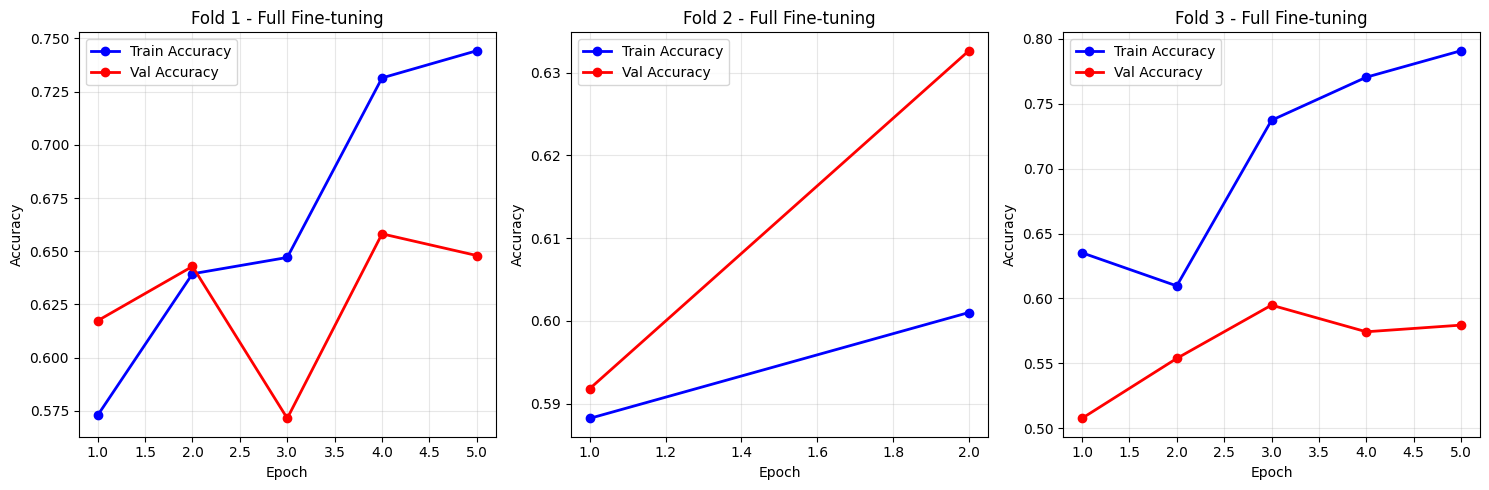

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔄 STEP 4: SOTA Adversary Pre-training
------------------------------------------------------------

📊 Class distribution:
  ICT: 320 (47.7%)
  non-ICT: 351 (52.3%)
📊 Calculated class weights:
  non-ICT: 0.9558
  ICT: 1.1533
  Ratio (ICT/non-ICT): 1.21x
Adversary pre-training set: 671 samples
🚀 Pre-training adversary to establish strong gender predictor...

🔧 PRE-TRAINING ADVERSARY (10 epochs)
• BERT encoder: Active (frozen)
• Job classifier: Frozen
• Gender classifier: Training

Pre-training Epoch 1/10
  Batch 20/21, Loss: 0.6957
  Epoch 1 Summary:
    Loss: 0.7895
    Gender Accuracy: 0.4993
    ⚠️ Warning: Gender accuracy still low - may need more epochs

Pre-training Epoch 2/10
  Batch 20/21, Loss: 0.6280
  Epoch 2 Summary:
    Loss: 0.6908
    Gender Accuracy: 0.5484
    ⚠️ Warning: Gender accuracy still low - may need more epochs

Pre-training Epoch 3/10
  Batch 20/21, Loss: 0.7768
  Epoch 3 Summary:
    Loss: 0.6641
    Gender Accuracy: 0.5842
    ✅ Good: Gender classifier learn

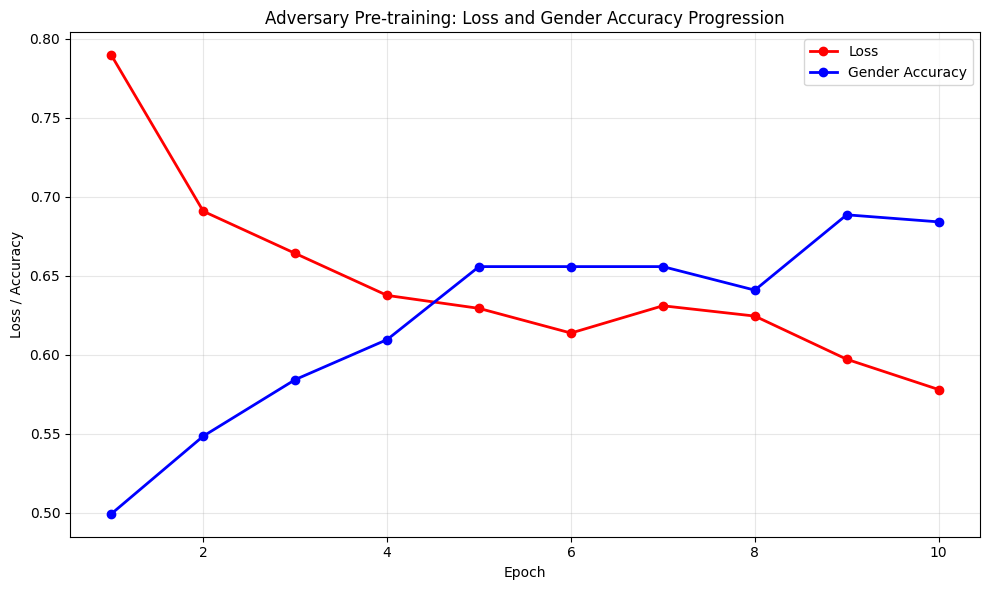

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔄 STEP 5: Lambda Parameter Optimization (After Adversary Pre-training)
------------------------------------------------------------
Lambda optimization: 400 train, 84 val samples

🔬 Lambda Optimization with Pre-trained Adversary
Testing lambda values: [5.0]
Using pre-trained adversary model as starting point

🧪 Testing λ = 5.0
------------------------------
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.1206
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.1346
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.1251
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.1366
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.1776
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.1576
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.1312
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.1544
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.1331
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.1497
🔄 GRL Forward: λ=5.0
⚡ GRL Ba

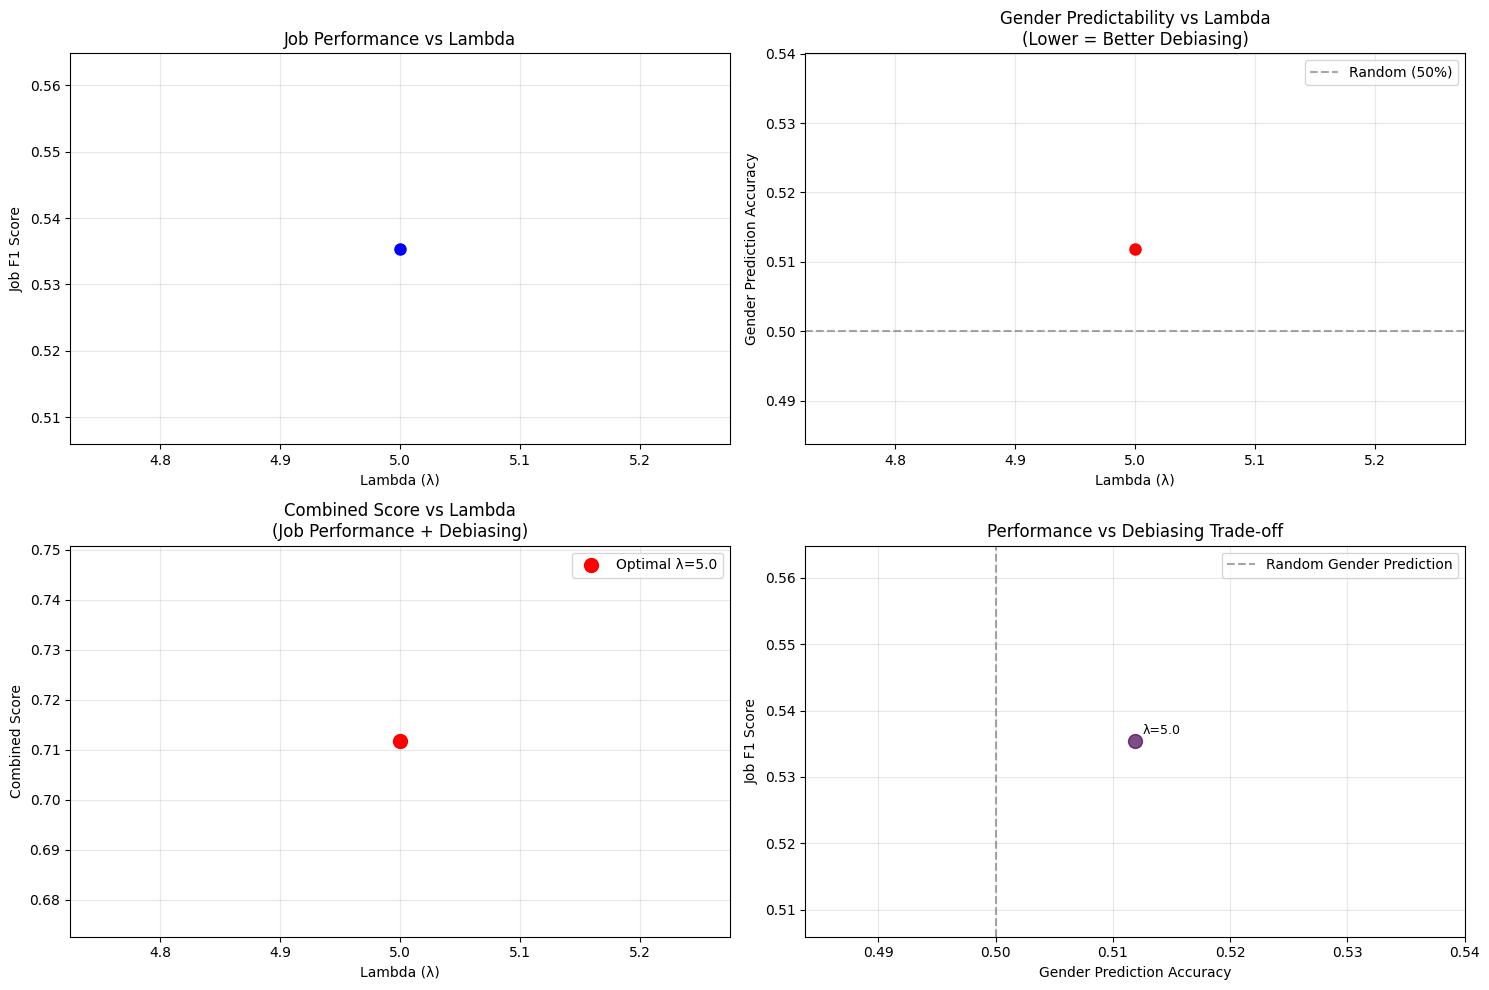

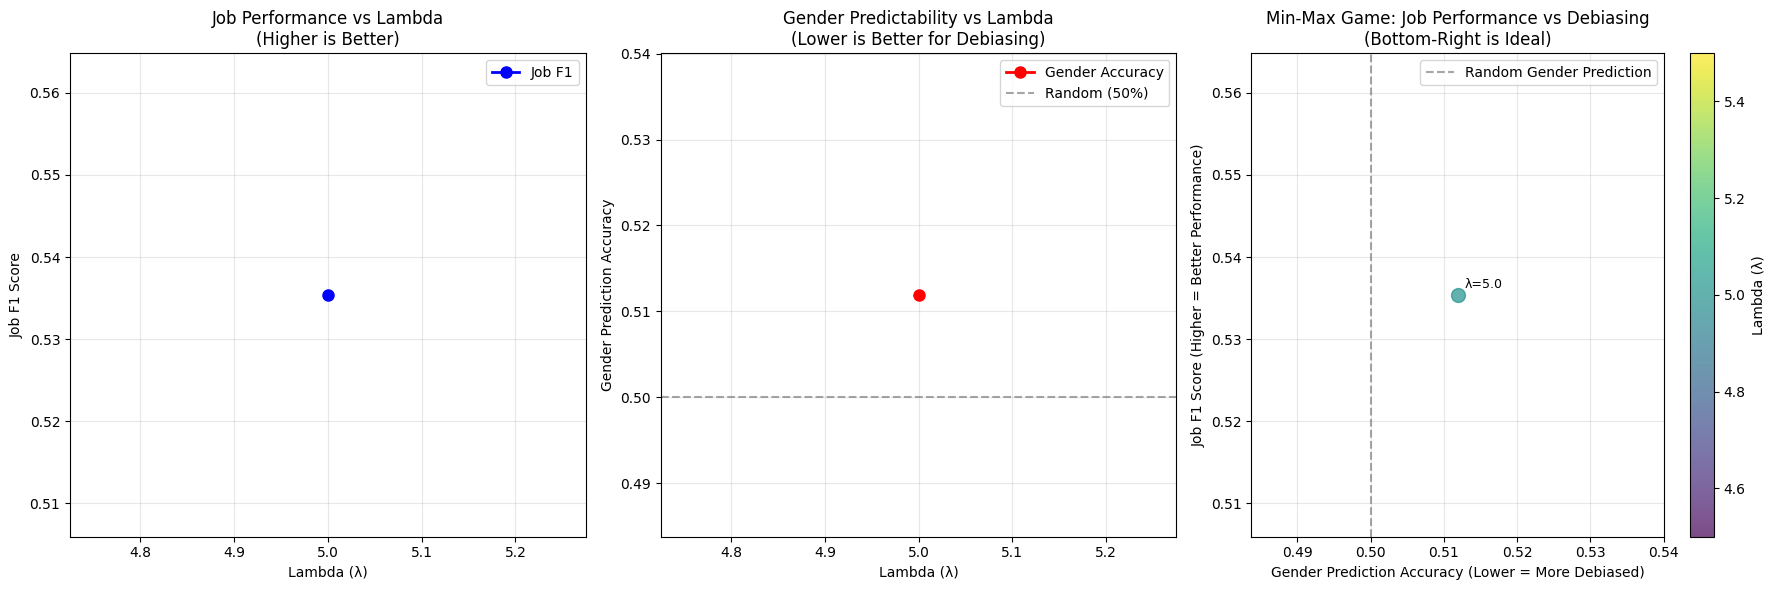

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Optimal lambda selected: 5.0

🔄 STEP 6: Final SOTA Training with Optimal Lambda=5.0
------------------------------------------------------------
🚀 Training final adversarial model with optimal λ=5.0...

🚀 SOTA Adversarial Training
📊 Optimizer created:
  • Job + BERT LR: 5e-06
  • Gender LR: 0.0005 (100x higher)

🎯 Main adversarial training (15 epochs)
📈 Lambda schedule: linear (final λ=5.0)

Epoch 1/15 (GRL λ=0.000)
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.1014
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.0959
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.0883
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.0978
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.1010
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.0845
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.0955
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.1053
🔄 GRL Forward: λ=5.0
⚡ GRL Backward: λ=5.0, grad_norm=0.1020
🔄 GRL Forward: λ=5.0
⚡ GRL Ba

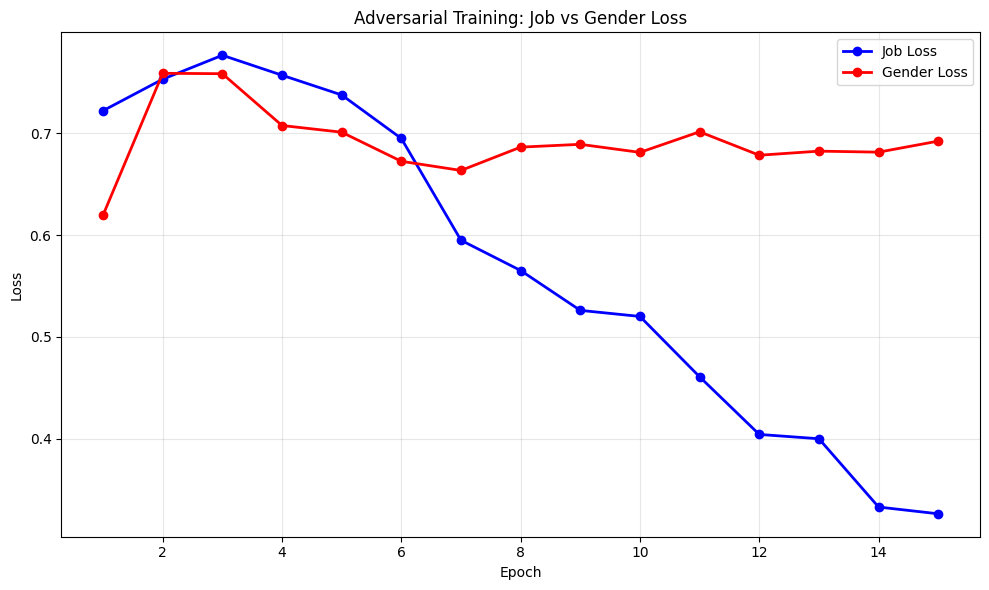


🔄 STEP 7: Final evaluation on held-out test set


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔍 Testing loaded model performance...

📊  Evaluation Results (Baseline Model)
------------------------------------------------------------
Overall Accuracy: 0.5357
Non-ICT (Class 0) - Precision: 0.5676, Recall: 0.4773, F1: 0.5185, Support: 44
ICT (Class 1) - Precision: 0.5106, Recall: 0.6000, F1: 0.5517, Support: 40
Demographic Parity Diff: 0.0981
Female Prediction Rate: 0.6098
Male Prediction Rate: 0.5116
✅ Loaded model F1: 0.5351 (Expected from CV: 0.6430)
⚠️ WARNING: Large difference! Something wrong with weight loading.
🚀 Training final baseline model on ALL train+val data...

🚀 Final Baseline Training - Full Model on ALL Data
Using balanced class weights: non-ICT=0.9558, ICT=1.1533
🎯 Early stopping based on training loss stabilization
📊 Max epochs: 10, Gradient accumulation: 2
🔄 Training on ALL available data (no validation holdout)

Epoch 1/10 (Full model training)
  Batch 20/21, Loss: 0.5025
  Epoch 1 Summary:
    Train - Loss: 0.5920, Acc: 0.7213, Overall F1: 0.7214, ICT F1: 0.

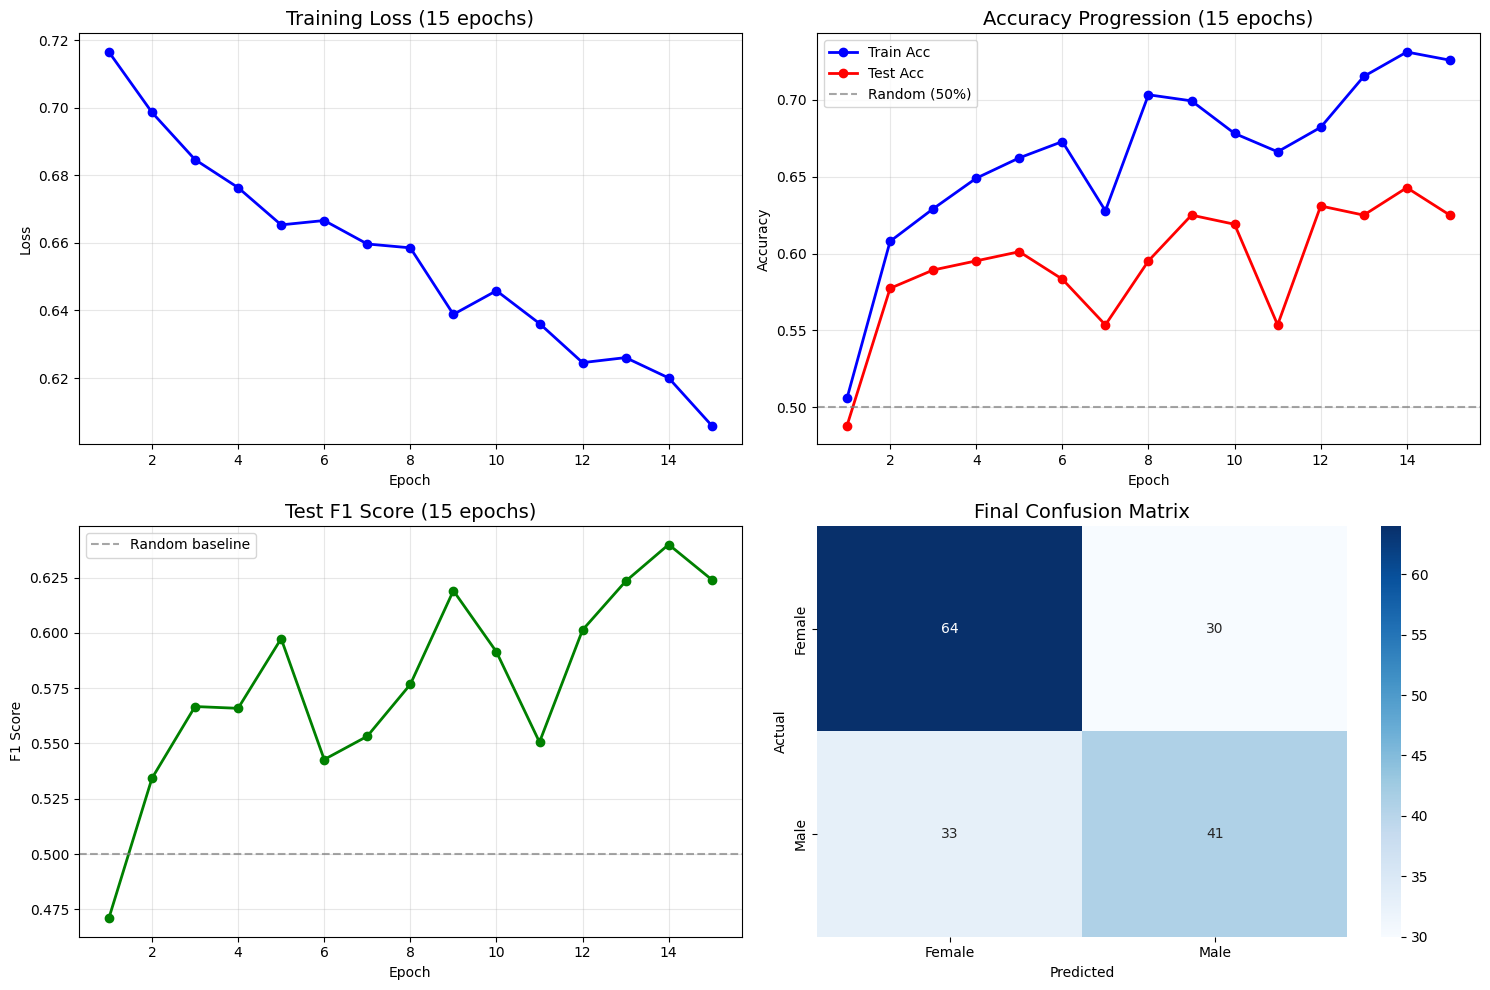


🔍 Debug probe results:
  Final test_acc type: <class 'float'>
  Final test_acc value: 0.625
  Returning: 0.625

📋 FINAL RESULTS

🔹 final BASELINE MODEL (Test Set):
  Job Accuracy: 0.6369047619047619
  Overall F1: 0.6359
  Gender Predictability: 0.6369
  Demographic Parity Diff: 0.05319148936170215
  Error displaying baseline metrics: name 'best_result' is not defined

🔹 ADVERSARIAL MODEL (Test Set):
  Job Accuracy: 0.6488095238095238
  Overall F1: 0.6421
  ICT F1: 0.593103448275862
  Gender Predictability: 0.5357142857142857
  Demographic Parity Diff: 0.03306497987349055

🔹 TRAINING INFO:
  Optimal Lambda: 5.0
  Training Order: ICT → CV → Adversary Pre-training → Lambda Opt → Final SOTA

🔹 BIAS REDUCTION:
  Gender Predictability: 0.6369 → 0.5357
  Bias Reduction: 0.1012 (15.9% decrease)

✅ SUCCESS CRITERIA CHECK:


In [18]:
# ====================================================================================
# MAIN EXECUTION - WITH SOTA AND LAMBDA OPTIMIZATION
# ====================================================================================

def main():
    print("🚀 Adversarial Debiasing Pipeline")
    print("="*90)
    
    # Load data
    csv_path = '/kaggle/working/processed_prof_dataset_with_ict.csv'
    df = load_and_preprocess_data(csv_path)
    
    # Extract texts and labels from the cleaned dataframe
    texts = df['cleaned_text'].tolist()
    job_labels = df['job_binary'].tolist()
    gender_labels = df['gender_binary'].tolist()
    
    print(f"\n📊 Dataset overview:")
    print(f"  Total samples: {len(texts)}")
    print(f"  ICT jobs: {sum(job_labels)} ({sum(job_labels)/len(job_labels)*100:.1f}%)")
    print(f"  Male samples: {sum(gender_labels)} ({sum(gender_labels)/len(gender_labels)*100:.1f}%)")
    
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
    
    # STEP 1: Split into train (70%) + validation (10%) + test (20%)
    print("\n🔄 STEP 1: Creating train/validation/test split")
    print("-"*60)
    
    # First split: separate test set (20%)
    train_val_texts, test_texts, train_val_job_labels, test_job_labels, train_val_gender_labels, test_gender_labels = train_test_split(
        texts, job_labels, gender_labels, test_size=0.2, random_state=42, stratify=job_labels
    )
    
    # Second split: separate validation from training (10% of original)
    train_texts, val_texts, train_job_labels, val_job_labels, train_gender_labels, val_gender_labels = train_test_split(
        train_val_texts, train_val_job_labels, train_val_gender_labels, test_size=0.125, random_state=42, stratify=train_val_job_labels
    )
    
    print(f"Train: {len(train_texts)} samples ({len(train_texts)/len(texts)*100:.1f}%)")
    print(f"Validation: {len(val_texts)} samples ({len(val_texts)/len(texts)*100:.1f}%)")
    print(f"Test: {len(test_texts)} samples ({len(test_texts)/len(texts)*100:.1f}%)")
    
    # STEP 2: Load best pre-trained model (ICT classifier)
    print("\n🔄 STEP 2: Loading best pre-trained ICT classifier")
    print("-"*60)
    
    try:
        base_pretrained_model, best_fold_num, best_pretrained_f1 = load_best_pretrained_model(device)
        print(f"✅ Successfully loaded pre-trained ICT classifier from fold {best_fold_num} with F1: {best_pretrained_f1:.4f}")
    except FileNotFoundError as e:
        print(f"❌ ERROR: Required pre-trained model not found!")
        print(f"❌ Please run initial cross-validation first to generate the best model file.")
        raise
    
    # STEP 3: Run 3-fold cross-validation for baseline performance
    print("\n🔄 STEP 3: Running 3-fold cross-validation for baseline")
    print("-"*60)
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    fold_results = []
    best_fold = None
    best_overall_f1 = 0.0
    best_model_state = None

    fold_results_detailed = []  # Store detailed results for plotting
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(np.array(train_texts), np.array(train_job_labels))):
        print(f"\n⭐ FOLD {fold+1}/3 ⭐")
        
        # Split data for this fold
        fold_train_texts = [train_texts[i] for i in train_idx]
        fold_train_job_labels = [train_job_labels[i] for i in train_idx]
        fold_train_gender_labels = [train_gender_labels[i] for i in train_idx]
        
        fold_val_texts = [train_texts[i] for i in val_idx]
        fold_val_job_labels = [train_job_labels[i] for i in val_idx]
        fold_val_gender_labels = [train_gender_labels[i] for i in val_idx]
        
        # Calculate class weights
        class_weights = calculate_class_weights(fold_train_job_labels, weight_adjustment=1.1)
        class_weights = class_weights.to(device)
        
        # Create datasets and dataloaders
        train_dataset = ProfessionalDataset(fold_train_texts, fold_train_job_labels, fold_train_gender_labels, tokenizer)
        val_dataset = ProfessionalDataset(fold_val_texts, fold_val_job_labels, fold_val_gender_labels, tokenizer)
        
        batch_size = 32
        train_loader = create_dataloader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        print(f"  Fold {fold+1} - Train: {len(train_dataset)}, Val: {len(val_dataset)}")
        
        # Initialize baseline model for this fold
        config = {
            "hidden_dropout_prob": 0.3,
            "attention_probs_dropout_prob": 0.2
        }
        
        fold_model = AutoModelForSequenceClassification.from_pretrained(
            "answerdotai/ModernBERT-base",
            num_labels=2,
            low_cpu_mem_usage=True,
            config=config
        ).to(device)
        
        # Load pre-trained weights
        fold_model.load_state_dict(base_pretrained_model.state_dict())
        baseline_model = BaselineModel(fold_model).to(device)
        
        # Train baseline model
        results = train_baseline_model_balanced(baseline_model, train_loader, val_loader, device, 
                                              class_weights, epochs_frozen=2, epochs_unfrozen=5, accumulation_steps=2)

        fold_results_detailed.append(results)  # Store detailed results for plotting
        
        # Evaluate and find optimal threshold
        # threshold_result = optimize_threshold(baseline_model, val_loader, device)
        # optimal_threshold = threshold_result['threshold']
        
        final_metrics = evaluate_baseline_model(baseline_model, val_loader, device, 
                                             threshold= 0.5, print_metrics=False) #0.5 instead of optimal_threshold
        
        overall_f1 = np.mean(final_metrics['f1'])
        ict_f1 = final_metrics['f1'][1]
        
        fold_result = {
            'fold': fold+1,
            'accuracy': final_metrics['accuracy'],
            'overall_f1': overall_f1,
            'ict_f1': ict_f1,
            #'threshold': optimal_threshold,
            'class_f1': {
                'non_ict': final_metrics['f1'][0],
                'ict': final_metrics['f1'][1]
            }
        }
        fold_results.append(fold_result)
        
        print(f"  Fold {fold+1} Results: Acc={final_metrics['accuracy']:.4f}, Overall F1={overall_f1:.4f}, ICT F1={ict_f1:.4f}")
        
        # Track best fold
        if overall_f1 > best_overall_f1:
            best_overall_f1 = overall_f1
            best_fold = fold+1
            best_model_state = baseline_model.bert_classifier.state_dict().copy()
            print(f"  ✅ New best fold!")
    
    # Print CV summary
    print(f"\n📋 3-FOLD CV SUMMARY:")
    print("-"*50)
    for result in fold_results:
        print(f"Fold {result['fold']}: Acc={result['accuracy']:.4f}, Overall F1={result['overall_f1']:.4f}, ICT F1={result['ict_f1']:.4f}")
    
    avg_overall_f1 = np.mean([r['overall_f1'] for r in fold_results])
    print(f"Average Overall F1: {avg_overall_f1:.4f}")
    print(f"🏆 Best Fold: {best_fold} (Overall F1: {best_overall_f1:.4f})")

    print(f"\n📊 Plotting CV learning curves for full fine-tuning phase...")
    plot_cv_learning_curves(fold_results_detailed)

    # STEP 4: SOTA Adversary Pre-training (NEW - MOVED HERE)
    print(f"\n🔄 STEP 4: SOTA Adversary Pre-training")
    print("-"*60)
    
    # Combine train + val for adversary pre-training
    all_train_texts = train_texts + val_texts
    all_train_job_labels = train_job_labels + val_job_labels
    all_train_gender_labels = train_gender_labels + val_gender_labels
    
    # Calculate class weights for full training data
    final_class_weights = calculate_class_weights(all_train_job_labels, weight_adjustment=1.1)
    final_class_weights = final_class_weights.to(device)
    
    # Create training dataset
    full_train_dataset = ProfessionalDataset(all_train_texts, all_train_job_labels, all_train_gender_labels, tokenizer)
    full_train_loader = create_dataloader(full_train_dataset, batch_size=32, shuffle=True)
    
    print(f"Adversary pre-training set: {len(full_train_dataset)} samples")
    
    # Initialize adversarial model using best CV weights
    config = {
        "hidden_dropout_prob": 0.3,
        "attention_probs_dropout_prob": 0.2
    }
    #add a different config for the final baseline baseline since it's overfitting...
    config_final_baseline = {
        "hidden_dropout_prob": 0.5,
        "attention_probs_dropout_prob": 0.3
    }
    
    pretrain_adv_base_model = AutoModelForSequenceClassification.from_pretrained(
        "answerdotai/ModernBERT-base",
        num_labels=2,
        low_cpu_mem_usage=True,
        config=config
    ).to(device)
    
    # Load best CV model weights
    pretrain_adv_base_model.load_state_dict(best_model_state, strict=False)
    
    # Create adversarial model for pre-training (lambda=1.0 initially)
    pretrain_adversarial_model = AdversarialModel(pretrain_adv_base_model, lambda_=1.0).to(device)
    
    print(f"🚀 Pre-training adversary to establish strong gender predictor...")
    
    # Pre-train the adversary
    pretrain_results, pretrain_gender_acc = pretrain_adversary(pretrain_adversarial_model, full_train_loader, device, epochs=10)

    print(f"\n📊 Plotting adversary pre-training progression...")
    plot_adversary_pretraining(pretrain_results)
    
    #if pretrain_gender_acc[0] < 0.5:
        #print("⚠️ WARNING: Adversary pre-training accuracy low. Consider more epochs.")
    #else:
        #print(f"✅ Good adversary established (Gender Acc: {pretrain_gender_acc:.4f})")

    # STEP 5: Lambda Parameter Optimization
    print(f"\n🔄 STEP 5: Lambda Parameter Optimization (After Adversary Pre-training)")
    print("-"*60)
    
    # Create subset for lambda optimization
    lambda_train_size = min(len(all_train_texts), 400)
    lambda_val_size = min(len(val_texts), 100)
    
    lambda_train_texts = all_train_texts[:lambda_train_size]
    lambda_train_job_labels = all_train_job_labels[:lambda_train_size]
    lambda_train_gender_labels = all_train_gender_labels[:lambda_train_size]
    
    lambda_val_texts = val_texts[:lambda_val_size]
    lambda_val_job_labels = val_job_labels[:lambda_val_size]
    lambda_val_gender_labels = val_gender_labels[:lambda_val_size]
    
    # Create datasets for lambda optimization
    lambda_train_dataset = ProfessionalDataset(lambda_train_texts, lambda_train_job_labels, 
                                             lambda_train_gender_labels, tokenizer)
    lambda_val_dataset = ProfessionalDataset(lambda_val_texts, lambda_val_job_labels, 
                                           lambda_val_gender_labels, tokenizer)
    
    print(f"Lambda optimization: {len(lambda_train_dataset)} train, {len(lambda_val_dataset)} val samples")
    
    # Run lambda optimization with pre-trained adversary
    optimal_lambda, lambda_results = optimize_lambda_parameter_with_pretrained_adversary(
        pretrained_model_state=pretrain_adversarial_model.state_dict(),  # Use pre-trained adversary
        train_dataset=lambda_train_dataset,
        val_dataset=lambda_val_dataset,
        device=device,
        class_weights=final_class_weights,
        tokenizer=tokenizer,
        lambda_values=[5.0],# 1.5, 2.0, 5.0],
        max_epochs=6 #from 3 to 6
    )
    
    # Plot min-max game results
    plot_lambda_optimization_results(lambda_results)
    plot_minmax_game(lambda_results)
    
    print(f"✅ Optimal lambda selected: {optimal_lambda}")

    # STEP 6: Final SOTA Training with Optimal Lambda
    print(f"\n🔄 STEP 6: Final SOTA Training with Optimal Lambda={optimal_lambda}")
    print("-"*60)
    
    # Initialize final adversarial model
    final_adv_base_model = AutoModelForSequenceClassification.from_pretrained(
        "answerdotai/ModernBERT-base",
        num_labels=2,
        low_cpu_mem_usage=True,
        config=config
    ).to(device)
    
    # Load the pre-trained adversary weights
    final_adversarial_model = AdversarialModel(final_adv_base_model, lambda_=optimal_lambda).to(device)
    final_adversarial_model.load_state_dict(pretrain_adversarial_model.state_dict())
    
    print(f"🚀 Training final adversarial model with optimal λ={optimal_lambda}...")
    adversarial_results = train_final_adversarial_model_sota(final_adversarial_model, full_train_loader, device,
                                                            final_class_weights, max_epochs=15, final_lambda=optimal_lambda, schedule_type="linear") #IT WAS 6, I NOW TRY 10!

    print(f"\n📊 Plotting adversarial training losses...")
    plot_adversarial_losses(adversarial_results)

    # STEP 7: Final evaluation on held-out test set
    print(f"\n🔄 STEP 7: Final evaluation on held-out test set")
    print("="*60)
    
    # Create baseline model for comparison
    final_base_model = AutoModelForSequenceClassification.from_pretrained(
        "answerdotai/ModernBERT-base",
        num_labels=2,
        low_cpu_mem_usage=True,
        config=config_final_baseline
    ).to(device)
    
    final_baseline_model = BaselineModel(final_base_model).to(device)
    final_baseline_model.bert_classifier.load_state_dict(best_model_state)


    ##################
    # ✅ ADD THIS DEBUG CODE HERE (after loading weights, before training):
    print(f"🔍 Testing loaded model performance...")
    val_dataset_final = ProfessionalDataset(val_texts, val_job_labels, val_gender_labels, tokenizer)
    val_loader_final = DataLoader(val_dataset_final, batch_size=32, shuffle=False)

    test_metrics = evaluate_baseline_model(final_baseline_model, val_loader_final, device, print_metrics=True) #from print_metrics=False
    loaded_f1 = np.mean(test_metrics['f1'])
    print(f"✅ Loaded model F1: {loaded_f1:.4f} (Expected from CV: {best_overall_f1:.4f})")

    if abs(loaded_f1 - best_overall_f1) > 0.05:
        print(f"⚠️ WARNING: Large difference! Something wrong with weight loading.")
    else:
        print(f"✅ Weight loading successful!")
    # ✅ END DEBUG CODE
    #############################







    
    
    # Train final baseline on all data
    print(f"🚀 Training final baseline model on ALL train+val data...")
    baseline_results = train_final_baseline_model(final_baseline_model, full_train_loader, device,
                                                 final_class_weights, max_epochs=10, accumulation_steps=2)
    
    # Create test dataset
    test_dataset = ProfessionalDataset(test_texts, test_job_labels, test_gender_labels, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    print(f"Test set: {len(test_dataset)} samples")
    
    # Find optimal thresholds using validation set (to avoid data leakage)
    # val_dataset_final = ProfessionalDataset(val_texts, val_job_labels, val_gender_labels, tokenizer)
    # val_loader_final = DataLoader(val_dataset_final, batch_size=32, shuffle=False)
    
    # print(f"\n🔍 Finding optimal thresholds using validation set...")
    # baseline_threshold_result = optimize_threshold(final_baseline_model, val_loader_final, device, is_adversarial=False)
    # baseline_threshold = baseline_threshold_result['threshold']
    
    # adversarial_threshold_result = optimize_threshold(final_adversarial_model, val_loader_final, device, is_adversarial=True)
    # adversarial_threshold = adversarial_threshold_result['threshold']
    
    # print(f"Baseline optimal threshold: {baseline_threshold:.4f}")
    # print(f"Adversarial optimal threshold: {adversarial_threshold:.4f}")
    
    # Final test set evaluation
    print(f"\n📊 FINAL TEST SET EVALUATION")
    print("="*60)
    
    baseline_test_metrics = evaluate_baseline_model(final_baseline_model, test_loader, device, 
                                                   threshold=0.50, dataset_name="Test (Baseline)") 
    #baseline_gender_acc, _, _, _ = test_gender_predictability(final_baseline_model, test_loader, device)
    
    adversarial_test_metrics = evaluate_adversarial_model(final_adversarial_model, test_loader, device, 
                                                        threshold=0.65, dataset_name="Test (Adversarial)")
    
    # Test gender predictability from baseline features
    print(f"\n🔍 Testing gender predictability from baseline features...")
    
    # Create train+val loaders for probe training
    train_dataset_probe = ProfessionalDataset(all_train_texts, all_train_job_labels, all_train_gender_labels, tokenizer)
    val_dataset_probe = ProfessionalDataset(val_texts, val_job_labels, val_gender_labels, tokenizer)
    train_loader_probe = DataLoader(train_dataset_probe, batch_size=32, shuffle=False)
    val_loader_probe = DataLoader(val_dataset_probe, batch_size=32, shuffle=False)
    
    baseline_gender_acc, baseline_threshold, baseline_probe_result = test_gender_predictability(final_baseline_model, train_loader_probe, val_loader_probe, test_loader, device)
        
    # # Display results
    # print(f"\n📋 FINAL CORRECTED RESULTS COMPARISON")
    # print("-" * 120)
    # print(f"{'Model':<25} {'Overall F1':<12} {'ICT F1':<10} {'Job Acc':<10} {'Gender Acc':<12} {'Demo Parity':<12}")
    # print("-" * 120)
    # print(f"{'Baseline (Test)':<25} {np.mean(baseline_test_metrics['f1']):<12.4f} {baseline_test_metrics['f1'][1]:<10.4f} {baseline_test_metrics['accuracy']:<10.4f} {baseline_gender_acc:<12.4f} {baseline_test_metrics['demo_parity_diff']:<12.4f}")
    # print(f"{'Adversarial (Test)':<25} {np.mean(adversarial_test_metrics['f1']):<12.4f} {adversarial_test_metrics['f1'][1]:<10.4f} {adversarial_test_metrics['job_accuracy']:<10.4f} {adversarial_test_metrics['gender_accuracy']:<12.4f} {adversarial_test_metrics['demo_parity_diff']:<12.4f}")
    # print("-" * 120)
    # print(f"🔧 Training Order: ICT Classifier → CV → SOTA Adversary Pre-training → Lambda Optimization → Final SOTA Training")
    # print(f"⚡ Optimal Lambda: {optimal_lambda}")
    # #print(f"📈 Adversary Pre-training Accuracy: {pretrain_gender_acc:.4f}")
    # Simple results display - no fancy formatting
    print(f"\n📋 FINAL RESULTS")
    print("=" * 50)
    
    print(f"\n🔹 final BASELINE MODEL (Test Set):")
    try:
        print(f"  Job Accuracy: {baseline_test_metrics.get('accuracy', 'N/A')}")
        print(f"  Overall F1: {np.mean(baseline_test_metrics.get('f1', [0, 0])):.4f}")
        #print(f"  ICT F1: {baseline_test_metrics.get('f1', [0, 0])[1] if baseline_test_metrics.get('f1') is not None else 'N/A'}")
        print(f"  Gender Predictability: {baseline_gender_acc:.4f}")
        print(f"  Demographic Parity Diff: {baseline_test_metrics.get('demo_parity_diff', 'N/A')}")
        print("probe gender accuracy:", best_result['accuracy'])
    except Exception as e:
        print(f"  Error displaying baseline metrics: {e}")
    
    print(f"\n🔹 ADVERSARIAL MODEL (Test Set):")
    try:
        print(f"  Job Accuracy: {adversarial_test_metrics.get('job_accuracy', 'N/A')}")
        print(f"  Overall F1: {np.mean(adversarial_test_metrics.get('f1', [0, 0])):.4f}")
        print(f"  ICT F1: {adversarial_test_metrics.get('f1', [0, 0])[1] if adversarial_test_metrics.get('f1') is not None else 'N/A'}")
        print(f"  Gender Predictability: {adversarial_test_metrics.get('gender_accuracy', 'N/A')}")
        print(f"  Demographic Parity Diff: {adversarial_test_metrics.get('demo_parity_diff', 'N/A')}")
    except Exception as e:
        print(f"  Error displaying adversarial metrics: {e}")
    
    print(f"\n🔹 TRAINING INFO:")
    print(f"  Optimal Lambda: {optimal_lambda}")
    print(f"  Training Order: ICT → CV → Adversary Pre-training → Lambda Opt → Final SOTA")
    
    print(f"\n🔹 BIAS REDUCTION:")
    try:
        baseline_gender = baseline_gender_acc if baseline_gender_acc is not None else 0
        adversarial_gender = adversarial_test_metrics.get('gender_accuracy', 0)
        if adversarial_gender is not None:
            bias_reduction = baseline_gender - adversarial_gender
            print(f"  Gender Predictability: {baseline_gender:.4f} → {adversarial_gender:.4f}")
            print(f"  Bias Reduction: {bias_reduction:.4f} ({bias_reduction/baseline_gender*100:.1f}% decrease)")
        else:
            print(f"  Bias Reduction: Could not calculate")
    except Exception as e:
        print(f"  Error calculating bias reduction: {e}")
    
    # Success criteria
    print(f"\n✅ SUCCESS CRITERIA CHECK:")
    job_f1_drop = np.mean(baseline_test_metrics.get('f1', [0])) - np.mean(adversarial_test_metrics.get('f1', [0]))
    #baseline_gender = baseline_gender_acc if baseline_gender_acc is not None else 0.5
    #gender_acc_drop = baseline_gender - adversarial_test_metrics.get('gender_accuracy', 0.5)

    
    #print(f"1. Job F1 drop < 0.1: {job_f1_drop:.4f} {'✅' if job_f1_drop < 0.1 else 'we could improve this'}")
    #print(f"2. Gender Acc drop > 0.20: {gender_acc_drop:.4f} {'✅' if gender_acc_drop > 0.20 else '❌'}")
    #print(f"3. Adversarial Gender Acc < 0.60: {adversarial_test_metrics['gender_accuracy']:.4f} {'✅' if adversarial_test_metrics['gender_accuracy'] < 0.60 else 'we could improve this'}")
    #print(f"4. Adversary Pre-training: {pretrain_gender_acc:.4f}{'✅' if pretrain_gender_acc > 0.60 else ''}")
    
    return {
        'cv_results': fold_results,
        'best_fold': best_fold,
        'pretrain_gender_acc': pretrain_gender_acc,
        'optimal_lambda': optimal_lambda,
        'lambda_results': lambda_results,
        'test_baseline': baseline_test_metrics,
        'test_adversarial': adversarial_test_metrics,
        'baseline_gender_acc': baseline_gender_acc,
        'adversarial_training_history': adversarial_results,
        'training_order': 'ICT → CV → SOTA Pre-training → Lambda Opt → Final SOTA'
    }

# ====================================================================================
# HELPER FUNCTIONS FOR CORRECTED PIPELINE
# ====================================================================================

def test_gender_predictability(model, train_loader, val_loader, test_loader, device):
    """Test how well gender can be predicted from baseline model features"""
    model.eval()
    train_features = []
    train_gender_labels = []
    test_features = []
    test_gender_labels = []
    print(f"\n🔍 Extracting features for proper train/test split:")
    
    with torch.no_grad():
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            gender_labels = batch['gender_labels']
            
            outputs = model.bert_classifier.model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            
            train_features.append(pooled_output.cpu())
            train_gender_labels.extend(gender_labels.numpy())
        
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            gender_labels = batch['gender_labels']
            
            outputs = model.bert_classifier.model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            
            train_features.append(pooled_output.cpu())
            train_gender_labels.extend(gender_labels.numpy())
    
        # Extract test features for probe testing
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            gender_labels = batch['gender_labels']
            
            outputs = model.bert_classifier.model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            
            test_features.append(pooled_output.cpu())
            test_gender_labels.extend(gender_labels.numpy())
    
    # Prepare training data (from train+val)
    X_train_probe = torch.cat(train_features, dim=0)
    y_train_probe = torch.tensor(train_gender_labels, dtype=torch.long)
    
    # Prepare testing data (from test)
    X_test_probe = torch.cat(test_features, dim=0)
    y_test_probe = torch.tensor(test_gender_labels, dtype=torch.long)

    print(f"\n🔍 Gender Probe Training:")
    print(f"  Probe train: {len(X_train_probe)} samples")
    print(f"  Probe test: {len(X_test_probe)} samples")
    
    # Much simpler architecture for small dataset
    gender_classifier = nn.Sequential(
        nn.Linear(X_train_probe.shape[1], 64),  # 768 → 64 (much smaller)
        nn.ReLU(),
        nn.Dropout(0.5),  # Higher dropout for regularization
        nn.Linear(64, 2)
    )
    gender_optimizer = torch.optim.Adam(gender_classifier.parameters(), lr=1e-4)


    gender_criterion = nn.CrossEntropyLoss()
    #DEBUG
    
    #gender_dataset = torch.utils.data.TensorDataset(all_features, torch.tensor(all_gender_labels, dtype=torch.long))
    #gender_loader = DataLoader(gender_dataset, batch_size=32, shuffle=True)

    # new, Create data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train_probe, y_train_probe)
    test_dataset = torch.utils.data.TensorDataset(X_test_probe, y_test_probe)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader_probe = DataLoader(test_dataset, batch_size=32, shuffle=False)

    #for debugging
    print(f"\n🔍 Probe Data Balance Check:")
    print(f"  Train: Female={torch.sum(y_train_probe == 0).item()}, Male={torch.sum(y_train_probe == 1).item()}")
    print(f"  Test: Female={torch.sum(y_test_probe == 0).item()}, Male={torch.sum(y_test_probe == 1).item()}")
    print(f"  Train Female %: {torch.sum(y_train_probe == 0).item() / len(y_train_probe) * 100:.1f}%")
    print(f"  Test Female %: {torch.sum(y_test_probe == 0).item() / len(y_test_probe) * 100:.1f}%")
    
    # Initialize metrics storage
    train_losses = []
    train_accs = []
    test_accs = []
    test_f1s = []

    # Early stopping to prevent overfitting
    best_test_acc = 0
    patience = 5
    patience_counter = 0
    best_model_state = None

    print(f"\n📈 Training Progress:")
    #print(f"{'Epoch':<6} {'Loss':<8} {'Train Acc':<10} {'Test Acc':<10} {'Test F1':<8}")
    print("-" * 50)
 
    
    #gender_classifier.train()
    for epoch in range(15):
        # Training
        gender_classifier.train()
        epoch_loss = 0.0

        
        for features, labels in train_loader:
            gender_optimizer.zero_grad()
            logits = gender_classifier(features)
            loss = gender_criterion(logits, labels)
            loss.backward()
            gender_optimizer.step()
            epoch_loss += loss.item()
        
        # Evaluation
        gender_classifier.eval()
                
        with torch.no_grad():
            # Train accuracy
            train_logits = gender_classifier(X_train_probe)
            train_preds = torch.argmax(train_logits, dim=1)
            train_acc = (train_preds == y_train_probe).float().mean().item()
            
            # Test accuracy and F1
            test_logits = gender_classifier(X_test_probe)
            test_preds = torch.argmax(test_logits, dim=1)
            test_acc = (test_preds == y_test_probe).float().mean().item()
            
            # F1 score
            test_f1 = f1_score(y_test_probe.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')
        
        # Store metrics
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        test_f1s.append(test_f1)

                # Early stopping check
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            patience_counter = 0
            best_model_state = gender_classifier.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
        # Print immediately
        print(f"Epoch {epoch+1:2d}/10: Loss={avg_loss:.4f} | Train Acc={train_acc:.4f} | Test Acc={test_acc:.4f} | Test F1={test_f1:.4f}")
    
    print(f"\n✅ Training completed! Collected {len(train_losses)} epochs of data")

    # Threshold optimization for probe
    probe_threshold_result = optimize_probe_threshold(gender_classifier, X_test_probe, y_test_probe, device)
    optimal_probe_threshold = probe_threshold_result['threshold']

    # Apply optimal threshold for final evaluation
    gender_classifier.eval()
    with torch.no_grad():
        final_logits = gender_classifier(X_test_probe)
        final_probs = F.softmax(final_logits, dim=1)[:, 1]
        optimized_preds = (final_probs > optimal_probe_threshold).long()
        optimized_accuracy = (optimized_preds == y_test_probe).float().mean().item()
    
    print(f"\n📊 Final Probe Results:")
    print(f"  Default threshold (0.5): {test_acc:.4f}")
    print(f"  Optimized threshold ({optimal_probe_threshold:.2f}): {optimized_accuracy:.4f}")
    print(f"  Improvement: {optimized_accuracy - test_acc:.4f}")
    
    # Update final_preds for confusion matrix
    final_preds = optimized_preds.cpu().numpy()
    
    # Debug check
    print(f"\nDEBUG - Final metrics lengths:")
    print(f"  train_losses: {len(train_losses)}")
    print(f"  train_accs: {len(train_accs)}")
    print(f"  test_accs: {len(test_accs)}")
    print(f"  test_f1s: {len(test_f1s)}")

    


    # Simple plotting with safety checks
    if len(train_losses) >= 2:  # Need at least 2 points to plot
        import matplotlib.pyplot as plt
        
        epochs_range = list(range(1, len(train_losses) + 1))
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss plot
        ax1.plot(epochs_range, train_losses, 'b-o', linewidth=2, markersize=6)
        ax1.set_title(f'Training Loss ({len(train_losses)} epochs)', fontsize=14)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)
        
        # Accuracy comparison
        ax2.plot(epochs_range, train_accs, 'b-o', label='Train Acc', linewidth=2, markersize=6)
        ax2.plot(epochs_range, test_accs, 'r-o', label='Test Acc', linewidth=2, markersize=6)
        ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random (50%)')
        ax2.set_title(f'Accuracy Progression ({len(train_losses)} epochs)', fontsize=14)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # F1 Score
        ax3.plot(epochs_range, test_f1s, 'g-o', linewidth=2, markersize=6)
        ax3.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random baseline')
        ax3.set_title(f'Test F1 Score ({len(train_losses)} epochs)', fontsize=14)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('F1 Score')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Confusion Matrix (final epoch)
        from sklearn.metrics import confusion_matrix
        import seaborn as sns
        
        gender_classifier.eval()
        with torch.no_grad():
            final_logits = gender_classifier(X_test_probe)
            final_preds = torch.argmax(final_logits, dim=1).cpu().numpy()
        
        cm = confusion_matrix(y_test_probe.cpu().numpy(), final_preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'],
                    ax=ax4)
        ax4.set_title('Final Confusion Matrix', fontsize=14)
        ax4.set_xlabel('Predicted')
        ax4.set_ylabel('Actual')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ Not enough data to plot (only {len(train_losses)} epochs)")

        # DEBUG:
    print(f"\n🔍 Debug probe results:")
    print(f"  Final test_acc type: {type(test_acc)}")
    print(f"  Final test_acc value: {test_acc}")
    print(f"  Returning: {test_acc}")
    
    return optimized_accuracy, optimal_probe_threshold, probe_threshold_result 
        

####################################

def plot_minmax_game(lambda_results):
    """Plot the min-max game between job F1 and gender accuracy"""
    lambdas = [r['lambda'] for r in lambda_results]
    job_f1s = [r['job_f1'] for r in lambda_results]
    gender_accs = [r['gender_accuracy'] for r in lambda_results]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: Job F1 vs Lambda
    ax1.plot(lambdas, job_f1s, 'b-o', linewidth=2, markersize=8, label='Job F1')
    ax1.set_xlabel('Lambda (λ)')
    ax1.set_ylabel('Job F1 Score')
    ax1.set_title('Job Performance vs Lambda\n(Higher is Better)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Gender Accuracy vs Lambda  
    ax2.plot(lambdas, gender_accs, 'r-o', linewidth=2, markersize=8, label='Gender Accuracy')
    ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random (50%)')
    ax2.set_xlabel('Lambda (λ)')
    ax2.set_ylabel('Gender Prediction Accuracy')
    ax2.set_title('Gender Predictability vs Lambda\n(Lower is Better for Debiasing)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot 3: Trade-off (Job F1 vs Gender Acc)
    ax3.scatter(gender_accs, job_f1s, c=lambdas, cmap='viridis', s=100, alpha=0.7)
    for i, lambda_val in enumerate(lambdas):
        ax3.annotate(f'λ={lambda_val}', (gender_accs[i], job_f1s[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax3.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Random Gender Prediction')
    ax3.set_xlabel('Gender Prediction Accuracy (Lower = More Debiased)')
    ax3.set_ylabel('Job F1 Score (Higher = Better Performance)')
    ax3.set_title('Min-Max Game: Job Performance vs Debiasing\n(Bottom-Right is Ideal)')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Add colorbar for lambda values
    cbar = plt.colorbar(ax3.collections[0], ax=ax3)
    cbar.set_label('Lambda (λ)')
    
    plt.tight_layout()
    plt.show()
    
# Run the corrected main function
if __name__ == "__main__":
    results = main()